
# YouTube

---
- Data collect

In [21]:
#!pip install apscheduler

In [60]:
#!pip install pendulum

In [ ]:
# cmd 에서 여기 폴더로 이동 후 python scheduler_collect.py 실행시키면 7,12,17시에 데이터가 2시간 버퍼로 증분 수집을 한다
# 이후 모아진 데이터를 합쳐서 ./Utube_data/data 파일로 일별로 모아준다

In [16]:
import os 
from pathlib import Path
folder = Path('./Utube_data/data_collect/Utube_data/data_collect/collect/')
csv_files = list(folder.glob('*.csv'))

file_names = [f.name for f in csv_files]
file_data = str(file_names).split('-')[0]
file_data[-4:]

'0815'

In [109]:
def collect_merge_df(root= './Utube_data/data_collect/Utube_data/data_collect/collect/'):
    import os
    from pathlib import Path
    import pandas as pd

    folder = Path(root)
    csv_files = list(folder.glob('*.csv'))

    file_names = [f.name for f in csv_files]
    file_data = str(file_names).split('-')[0]
    file_data = file_data[-4:]

    df_list = []

    for file in csv_files:
        temp_df = pd.read_csv(file)
        df_list.append(temp_df)

    merged_df = pd.concat(df_list, ignore_index=True)
    merged_df = merged_df.sort_values('created_at')
    merged_df = merged_df.drop_duplicates(subset='videoId' ,keep='last')
    
    merged_df = merged_df.to_csv(f'./Utube_data/data/youtubedata-{file_data}.csv',index=False)

    return merged_df

In [110]:
collect_merge_df()

In [ ]:
# 이후 data를 일별로 된 걸 다 합쳐주고 중복값을 최신으로 해준 후 필터링을 하여서 숏츠 데이터만 모아준다

---
- Data Merge

In [2]:
def merge_df(root):
    import os
    from pathlib import Path
    import pandas as pd

    folder = Path(root)
    csv_files = list(folder.glob('*.csv'))

    df_list = []

    for file in csv_files:
        temp_df = pd.read_csv(file)
        df_list.append(temp_df)

    merged_df = pd.concat(df_list, ignore_index=True)
    merged_df = merged_df.sort_values('created_at')
    merged_df = merged_df.drop_duplicates(subset='videoId' ,keep='last')
    
    return merged_df

In [3]:
merge_df = merge_df('./Utube_data/data')
merge_df.to_csv("./Utube_data/youtube_max180_clean_with_flag_2.csv", index=False)
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5507 entries, 1973 to 13012
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               5507 non-null   int64 
 1   videoId          5507 non-null   object
 2   title            5507 non-null   object
 3   description      3426 non-null   object
 4   channelTitle     5507 non-null   object
 5   publishedAt      5507 non-null   object
 6   category         5507 non-null   object
 7   shortsHashtags   1043 non-null   object
 8   fetchedDate      5507 non-null   object
 9   business_date    5507 non-null   object
 10  viewCount        5507 non-null   int64 
 11  likeCount        5507 non-null   int64 
 12  commentCount     5507 non-null   int64 
 13  subscriberCount  5507 non-null   int64 
 14  channelTier      5507 non-null   object
 15  url              5507 non-null   object
 16  created_at       1747 non-null   object
dtypes: int64(5), object(12)
memory usa

---
- Date Filter

In [4]:
# check_shorts_url_parallel.py
# -*- coding: utf-8 -*-
"""
/shorts URL 유효성 병렬 체크 + 체크포인트 저장 + 재시작 지원
- 입력: youtube_max180_clean_with_flag.csv  (duration_seconds, shorts_tag_flag 포함 가정)
- 출력: youtube_max180_with_shorts_url.csv  (shorts_url_valid, is_shorts_* 추가)
"""

import os, time, re
import pandas as pd
import requests
from concurrent.futures import ThreadPoolExecutor, as_completed
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

INPUT  = "./Utube_data/youtube_max180_clean_with_flag_2.csv"
OUTPUT = "./Utube_data/youtube_max180_with_shorts_url_2.csv"
MAX_WORKERS = 20          # 동시 스레드 수 (10~32 권장)
DELAY = 0.05              # 요청 간 딜레이(차단 방지)
CHECKPOINT_EVERY = 200    # 이 개수마다 중간 저장
TIMEOUT = 6

def build_session():
    s = requests.Session()
    retries = Retry(
        total=3, backoff_factor=0.4,
        status_forcelist=[429, 500, 502, 503, 504],
        allowed_methods=["GET", "HEAD"],
    )
    s.headers.update({"User-Agent":"Mozilla/5.0 (compatible; ShortsURLChecker/1.0)"})
    s.mount("https://", HTTPAdapter(max_retries=retries))
    return s

session = build_session()

def extract_video_id(x: str):
    if not isinstance(x, str): return None
    if re.fullmatch(r"[A-Za-z0-9_-]{11}", x): return x
    m = re.search(r"(?:[?&]v=|/shorts/)([A-Za-z0-9_-]{11})", x)
    return m.group(1) if m else None


def check_shorts_url(video_id: str):
    """최종 URL이 /shorts/VIDEO_ID 형태로 유지되면 True, 아니면 False, 실패시 None"""
    try:
        url = f"https://www.youtube.com/shorts/{video_id}"
        r = session.get(url, timeout=TIMEOUT, allow_redirects=True)
        final_url = getattr(r, "url", "")
        if r.status_code == 200 and "/shorts/" in final_url:
            return True
        if "/watch" in final_url or "v=" in final_url:
            return False
        return False
    except Exception:
        return None

def ensure_cols(df: pd.DataFrame) -> pd.DataFrame:
    # videoId 확보
    if "videoId" not in df.columns:
        df["videoId"] = df["url"].apply(extract_video_id)
    else:
        df["videoId"] = df["videoId"].apply(extract_video_id)

    # 보조 플래그(없으면 생성)
    if "shorts_tag_flag" not in df.columns:
        df["shorts_tag_flag"] = 0
    if "duration_seconds" not in df.columns:
        df["duration_seconds"] = None
    return df

def main():
    # 입력 로드 (출력 파일이 이미 있으면 그걸 이어서 사용)
    if os.path.exists(OUTPUT):
        df = pd.read_csv(OUTPUT)
        print(f"[재시작] 기존 출력 파일 로드: {OUTPUT} (rows={len(df)})")
    else:
        df = pd.read_csv(INPUT)
        print(f"[시작] 입력 파일 로드: {INPUT} (rows={len(df)})")

    df = ensure_cols(df)
    if "shorts_url_valid" not in df.columns:
        df["shorts_url_valid"] = pd.NA

    # 처리 대상 인덱스(아직 값이 비어있는 행만)
    todo_idx = df.index[df["shorts_url_valid"].isna()].tolist()
    print(f"처리 대상: {len(todo_idx)}개")

    futures = {}
    processed = 0
    start = time.time()

    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as ex:
        for i in todo_idx:
            vid = df.at[i, "videoId"]
            if not isinstance(vid, str) or len(vid) != 11:
                df.at[i, "shorts_url_valid"] = None
                continue
            futures[ex.submit(check_shorts_url, vid)] = i
            # 가벼운 지연(전체 속도 제어)
            time.sleep(DELAY)

        for fut in as_completed(futures):
            i = futures[fut]
            try:
                df.at[i, "shorts_url_valid"] = fut.result()
            except Exception:
                df.at[i, "shorts_url_valid"] = None

            processed += 1
            if processed % CHECKPOINT_EVERY == 0:
                df.to_csv(OUTPUT, index=False)
                print(f"중간 저장: {processed}/{len(todo_idx)}")

    # 최종 저장
    df.to_csv(OUTPUT, index=False)
    elapsed = time.time() - start
    print(f"완료 저장: {OUTPUT} (경과 {elapsed:.1f}s)")

    # 최종 숏츠 라벨(보수/넓게)
    # 보수: 180초 이하 AND (해시태그 or shorts_url_valid)
    def to_bool(x): 
        if pd.isna(x): return False
        return bool(x)

    # 1) duration_seconds 안전 계산
    sec = pd.to_numeric(df.get("duration_seconds"), errors="coerce")

    if sec.notna().any():
        # duration_seconds가 일부라도 있으면 있는 값 기준으로 판단
        df["duration_le_180"] = sec <= 180
    else:
        # 파일명이 max180이고 사전 필터링된 셋이라면 길이 조건을 True로 가정
        df["duration_le_180"] = True

    # 2) flag/URL 값도 안전하게 bool로 변환
    df["shorts_tag_flag"] = pd.to_numeric(df.get("shorts_tag_flag"), errors="coerce").fillna(0).astype(int)
    df["shorts_url_valid"] = df["shorts_url_valid"].apply(to_bool)

    # 3) 라벨 계산
    df["is_shorts_conservative"] = df["duration_le_180"] & (
        df["shorts_tag_flag"].astype(bool) | df["shorts_url_valid"]
    )
    df["is_shorts_broad"] = df["duration_le_180"] | df["shorts_tag_flag"].astype(bool) | df["shorts_url_valid"]


    #df["duration_le_180"] = pd.to_numeric(df["duration_seconds"], errors="coerce").fillna(10**9) <= 180
    #df["is_shorts_conservative"] = df["duration_le_180"] & (df["shorts_tag_flag"].astype(bool) | df["shorts_url_valid"].apply(to_bool))
    #df["is_shorts_broad"] = df["duration_le_180"] | df["shorts_tag_flag"].astype(bool) | df["shorts_url_valid"].apply(to_bool)

    df.to_csv(OUTPUT, index=False)
    print("요약:")
    print("shorts_url_valid =", df["shorts_url_valid"].value_counts(dropna=False).to_dict())
    print("is_shorts_conservative =", int(df["is_shorts_conservative"].sum()))
    print("is_shorts_broad =", int(df["is_shorts_broad"].sum()))

if __name__ == "__main__":
    main()

[재시작] 기존 출력 파일 로드: ./Utube_data/youtube_max180_with_shorts_url_2.csv (rows=3780)
처리 대상: 0개
완료 저장: ./Utube_data/youtube_max180_with_shorts_url_2.csv (경과 0.0s)
요약:
shorts_url_valid = {True: 2773, False: 1007}
is_shorts_conservative = 2773
is_shorts_broad = 3780


In [5]:
import pandas as pd

# ===== 설정 =====
INPUT_FILE = "./Utube_data/youtube_max180_with_shorts_url_2.csv"   # 원본 CSV
OUTPUT_FILE = "./Utube_data/youtube_filtered_clean_2.csv"          # 저장할 CSV
# ================

#  CSV 불러오기
df = pd.read_csv(INPUT_FILE)

#  is_shorts_conservative 값이 False인 데이터 전부 삭제
df = df[df['is_shorts_conservative'] == True].copy()

# 2. 지정된 6개 컬럼 삭제
cols_to_drop = [
    'shorts_url_valid',
    'duration_le_180',
    'shorts_tag_flag',
    'is_shorts_conservative',
    'is_shorts_broad',
    'shortsHashtags'
]

df = df.drop(columns=[col for col in cols_to_drop if col in df.columns])

#  category = 'Unknown' 데이터 삭제 (대소문자 구분 안 함)
if 'category' in df.columns:
    df = df[~df['category'].astype(str).str.lower().eq('unknown')].copy()

#  결과 저장
df.to_csv(OUTPUT_FILE, index=False)

print(f"필터링 완료! 저장 경로: {OUTPUT_FILE}")
print(f"최종 데이터 행 수: {len(df)}")


필터링 완료! 저장 경로: ./Utube_data/youtube_filtered_clean_2.csv
최종 데이터 행 수: 2716


----

In [6]:
import pandas as pd

df = pd.read_csv('./Utube_data/youtube_filtered_clean.csv')

In [7]:
def extract_clean_title(title):
    return str(title).split('#')[0].strip()

df['clean_title'] = df['title'].apply(extract_clean_title)

In [8]:
# 구독자 수 티어별 분류
def tier_four_classify(df):
    tier_1 = df[df['channelTier']==1].copy()
    tier_2 = df[df['channelTier']==2].copy()
    tier_3 = df[df['channelTier']==3].copy()
    tier_4 = df[df['channelTier']==4].copy()
    return tier_1, tier_2, tier_3, tier_4

In [9]:
df = df[df['clean_title'].str.contains(r'[가-힣]', regex=True)]

In [10]:
df['channelTier'].unique()

array([2, 3, 4], dtype=int64)

In [11]:
df['clean_title_len'] = df['clean_title'].str.len()

In [12]:
import pandas as pd
import numpy as np

# 제목과 설명문 뒤 # 만 가져온 것
def extract_hashtags(*texts):
    hashtags = []
    for text in texts:
        text = str(text)
        hashtags += [word.replace('#', '') for word in text.split() if '#' in word]
    return ' '.join(hashtags) if hashtags else '0'

df['hashtags'] = df.apply(lambda row: extract_hashtags(row['title'], row['description']), axis=1)

In [13]:
tier_1, tier_2, tier_3, tier_4 =  tier_four_classify(df)

---
- 범주형 ( title, description, hashtags ,category)


- 제목 길이 - 조회수

In [16]:
import koreanize_matplotlib

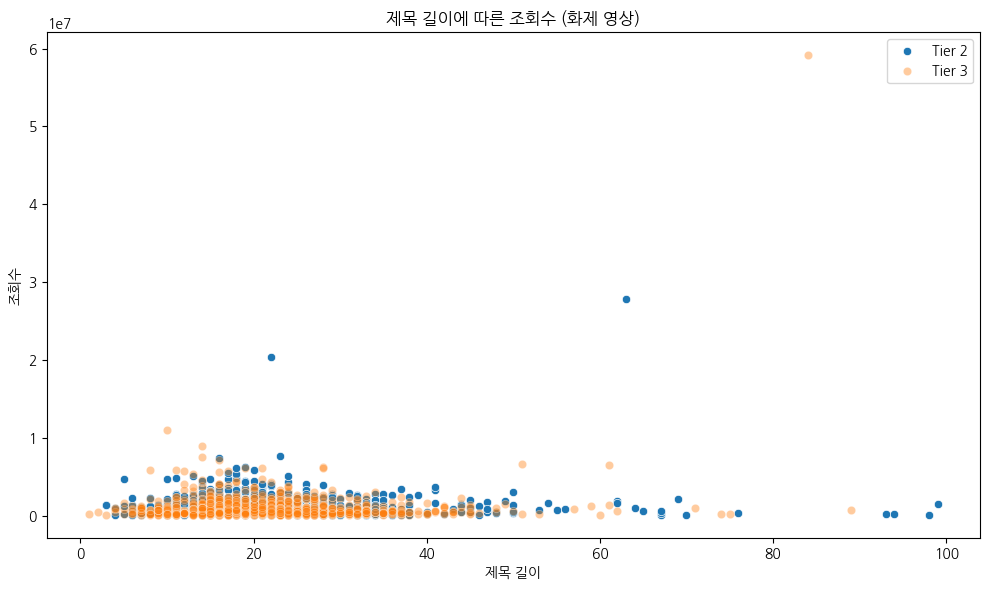

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

sns.scatterplot(data=tier_2, x='clean_title_len', y='viewCount', label='Tier 2')
sns.scatterplot(data=tier_3, x='clean_title_len', y='viewCount', label='Tier 3',alpha=0.4)

plt.title('제목 길이에 따른 조회수 (화제 영상)')
plt.xlabel('제목 길이')
plt.ylabel('조회수')
plt.legend()
plt.tight_layout()
plt.show()

---
- 티어별 카테고리 수

In [18]:
len(df['category'].unique())

12

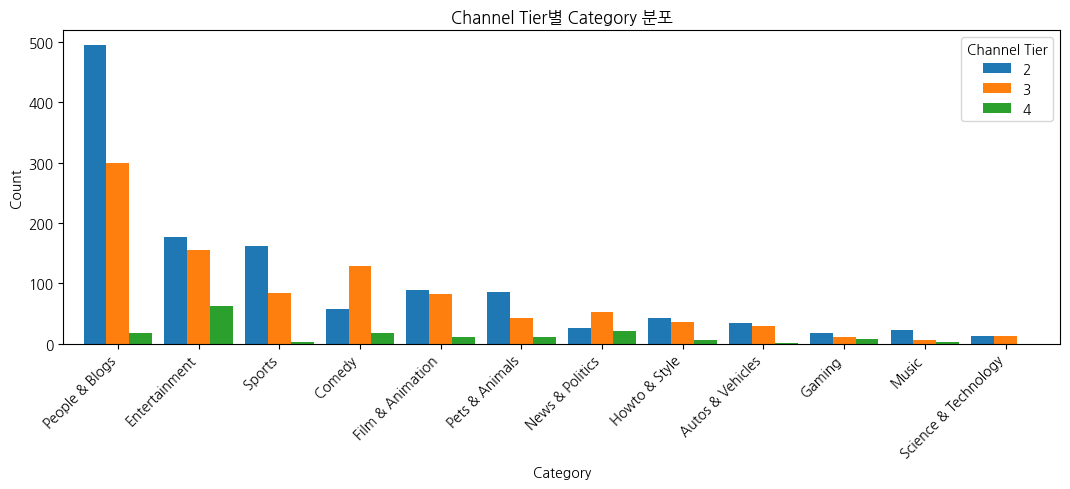

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

df_plot = df.copy()

# 티어×카테고리 카운트 → 피벗(가로: 티어, 세로: 카테고리)
df_plot = df.copy()
df_plot = df_plot.groupby(['category','channelTier']).size().unstack()


top_cats = df_plot.sum(axis=1).sort_values(ascending=False).index
count_pv = df_plot.loc[top_cats]


fig_w = max(10, len(count_pv) * 0.9)
ax = count_pv.plot(kind='bar', width=0.85, figsize=(fig_w, 5))
ax.set_xlabel('Category')
ax.set_ylabel('Count')
ax.set_title('Channel Tier별 Category 분포')
ax.legend(title='Channel Tier')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

---

In [20]:
# 이거 하나 바꾸면 밑에 다 적용
# tier_1, tier_2, tier_3, tier_4 , df 
DF = tier_2

---
- (티어) 카테고리별 자주 나오는 단어

In [21]:
# 카테고리별 자주 나오는 단어 
def category_by_word_count(df,ngram_range=(2,2),text_col='clean_title',category_col='category',top_k=15):
    
    # 문장을 토큰(단어, N-gram)으로 나누고, 각 토큰이 몇 번 등장했는지 세어주는 도구
    from sklearn.feature_extraction.text import CountVectorizer

    # 파이썬 내장 collections 모듈의 클래스, 아이템 등장 횟수를 쉽게 세고 순위 매길 때 사용
    from collections import Counter
    import pandas as pd
    
    categorys = df[category_col].unique()
    result = {}
    
    for cate in categorys:
        category_by_title = df[df[category_col]==cate][text_col]
            
        vec = CountVectorizer(ngram_range=ngram_range, stop_words='english') # CountVectorizer 객체 생성 / stop_word => english하면 불용어가 제거 됩니다 
        
        # 제목 데이터를 벡터화하여 희소행렬(sparse matrix)로 변환 / 행(row) =  제목 / 열(column) = 단어(N-gram) / 값(value) = 단어 등장 횟수
        X = vec.fit_transform(category_by_title)

        words = vec.get_feature_names_out()   # 벡터화한 단어(또는 N-gram) 목록을 리스트로 반환
        
        # 각 단어의 전체 등장 횟수를 구함 (axis=0 → 열 기준 합) / .A1은 numpy 배열을 1차원 리스트로 변환
        counts = X.sum(axis=0).A1 

        freq = dict(zip(words,counts))  
        top_words = Counter(freq).most_common(top_k)     # 자동 내림차순 정렬 , 상위 top_k개
        result[cate] = top_words
    
    return result

def category_ngram_n_print(df, ngram_range=(2, 2), top_k=15):
    top_ngrams_by_cat = category_by_word_count(df, ngram_range=ngram_range, top_k=top_k)     # {category: [(word, freq),(),(),()]}
    for category, ngrams in top_ngrams_by_cat.items():
        print(f"\n {category}")
        for word, freq in ngrams:
            print(f"  {word} → {freq}")
    return top_ngrams_by_cat


# 결과 딕셔너리를 DataFrame으로 변환
def cat_flatten_top_words_to_DataFrame(df, text_col ='clean_title', ngram_range=(2,2),top_k=15):
    import pandas as pd
    
    top_ngrams_by_cat = category_by_word_count(df, text_col=text_col ,ngram_range=ngram_range, top_k=top_k)
    rows = []
    for category, word_dict in top_ngrams_by_cat.items():
        for word, count in word_dict :
            rows.append({
                'category': category,
                'word': word,
                'count': count
            })

    return pd.DataFrame(rows)

In [22]:
#  파라미터 => df / ngram_range=(1,3) => 1~3단어 / top_k => 상위 n개
ngram_df = cat_flatten_top_words_to_DataFrame(DF,ngram_range=(2,2),top_k=10)   # 2단어 상위 10개

ngram_df

,category,word,count
0,Film & Animation,10살 차이,1
1,Film & Animation,18년동안 숨겨왔던,1
2,Film & Animation,19년 동안,1
3,Film & Animation,1분 안에,1
4,Film & Animation,1위 했을,1
...,...,...,...
115,Science & Technology,vs 갤럭시,1
116,Science & Technology,개미 독이,1
117,Science & Technology,갤럭시 ai로,1
118,Science & Technology,갤럭시로 바꾸면,1


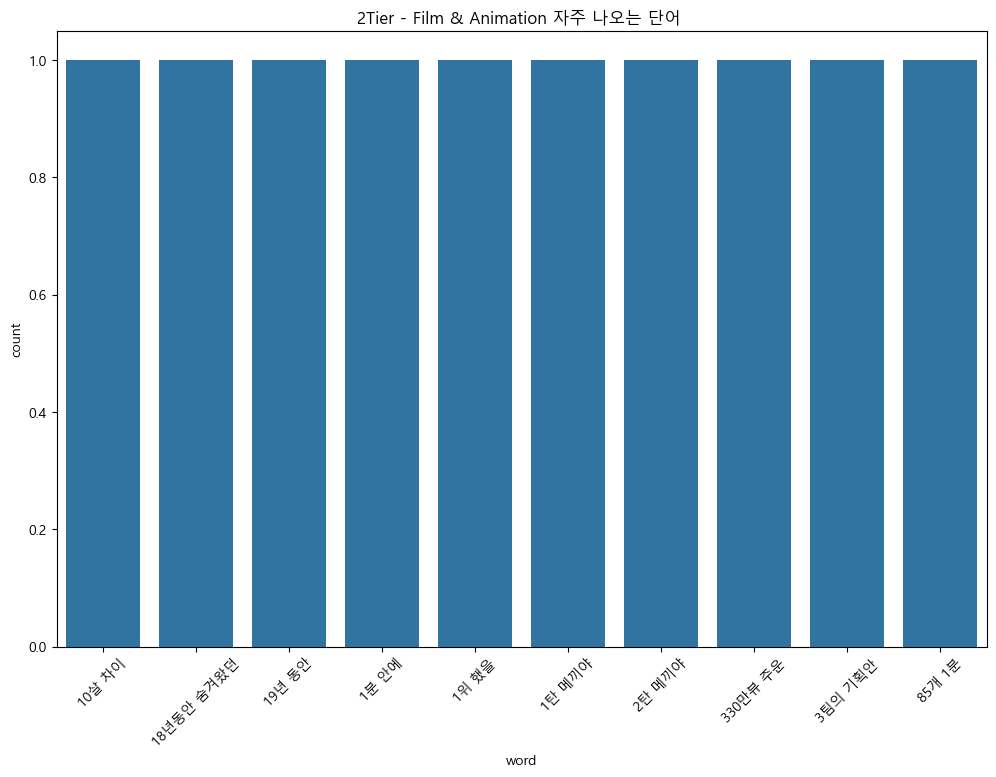

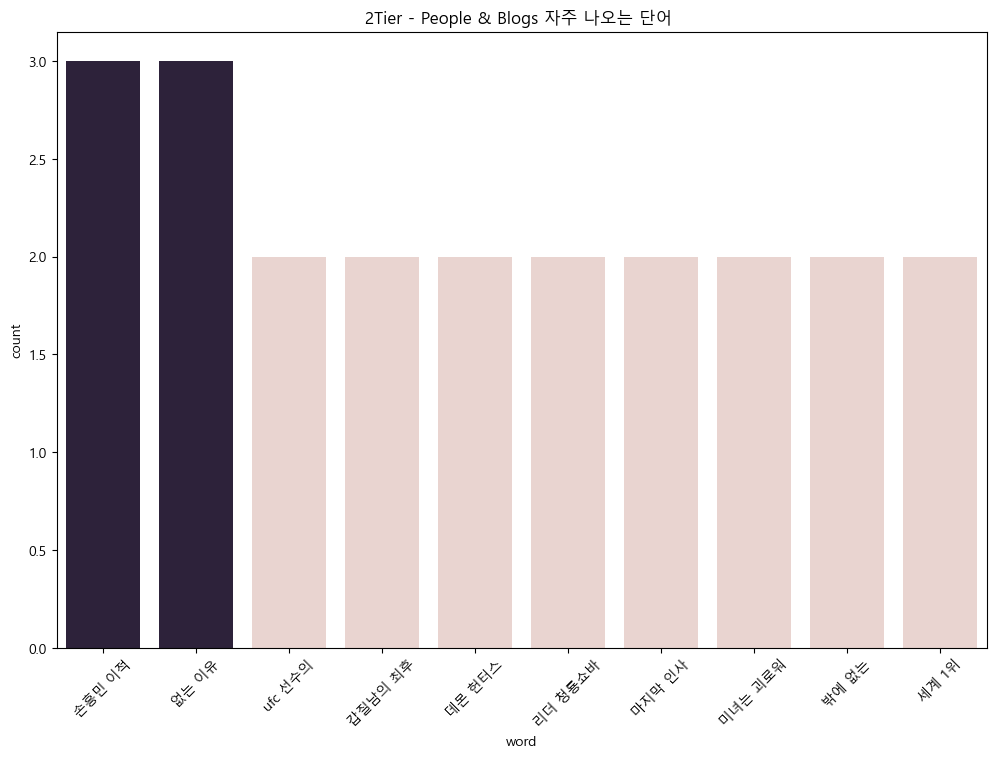

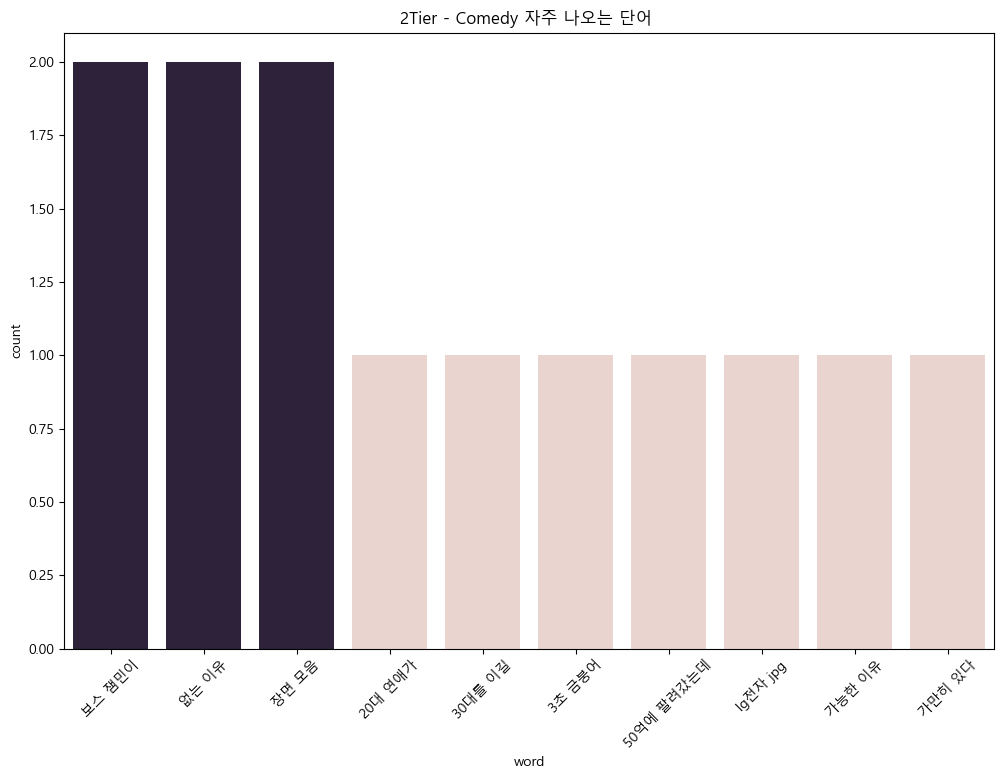

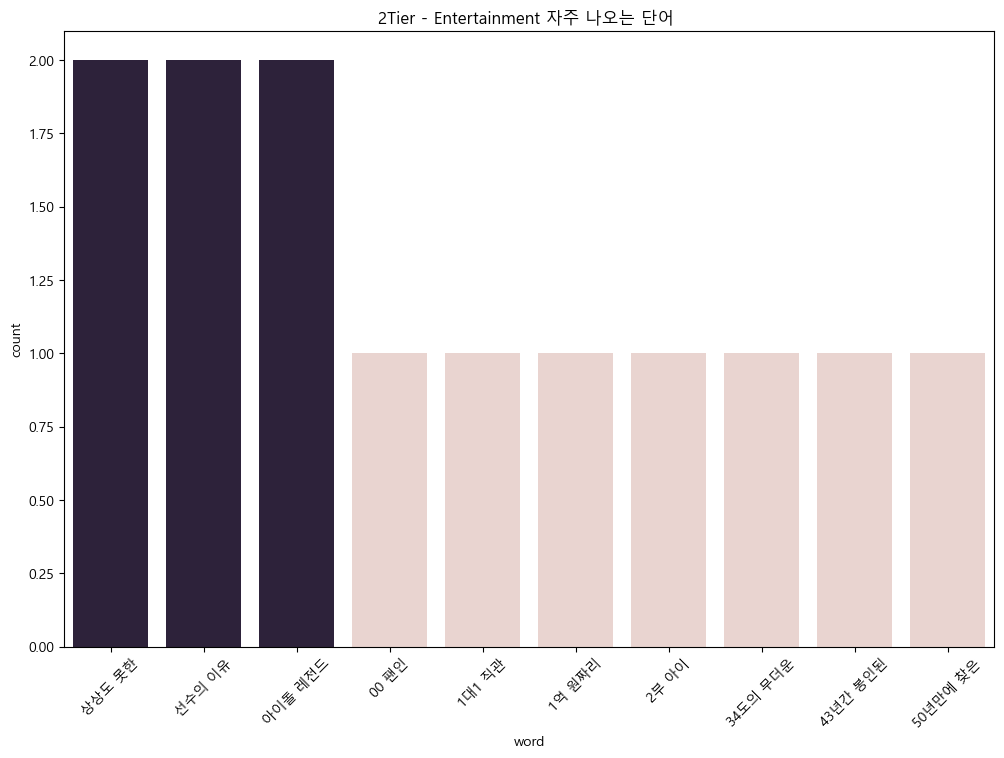

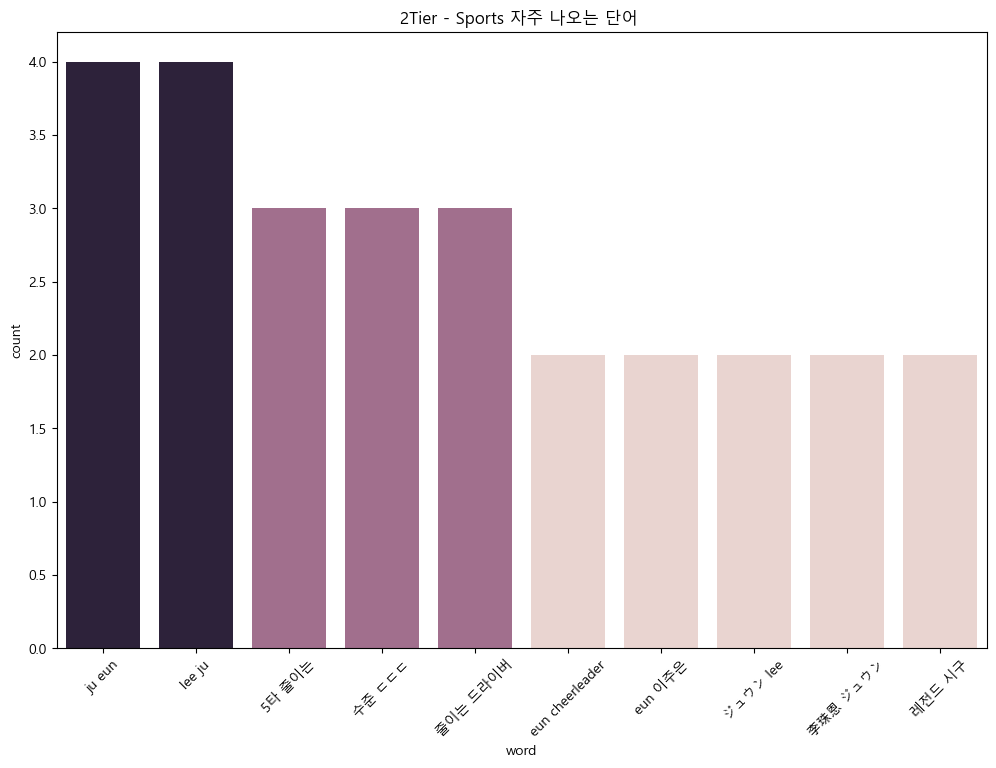

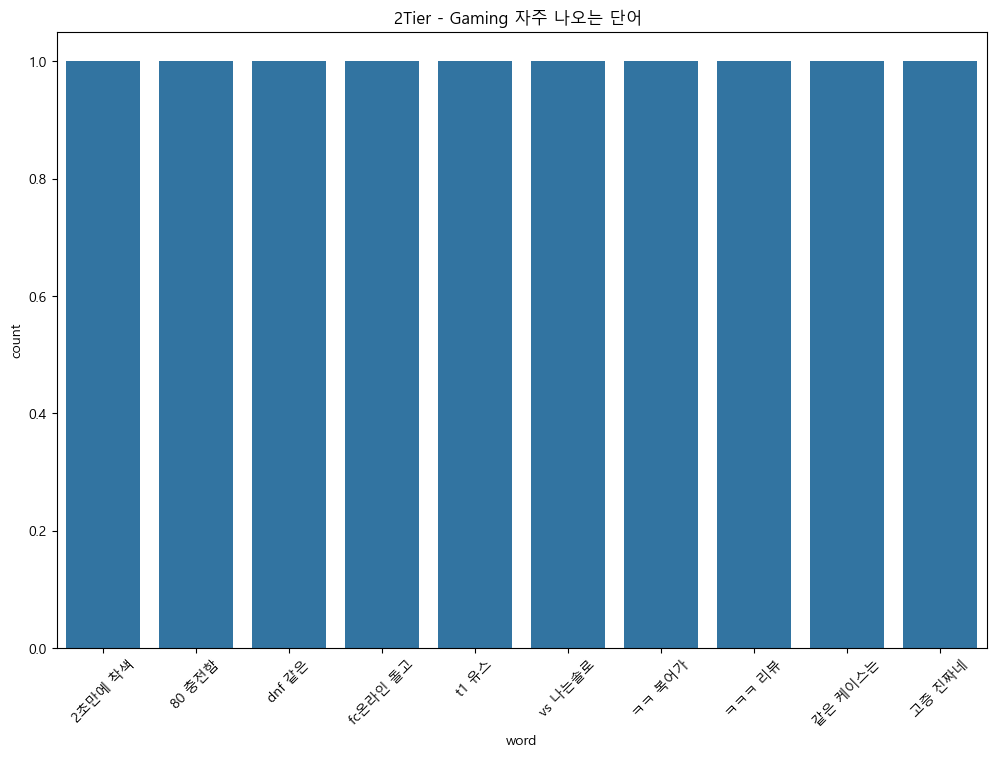

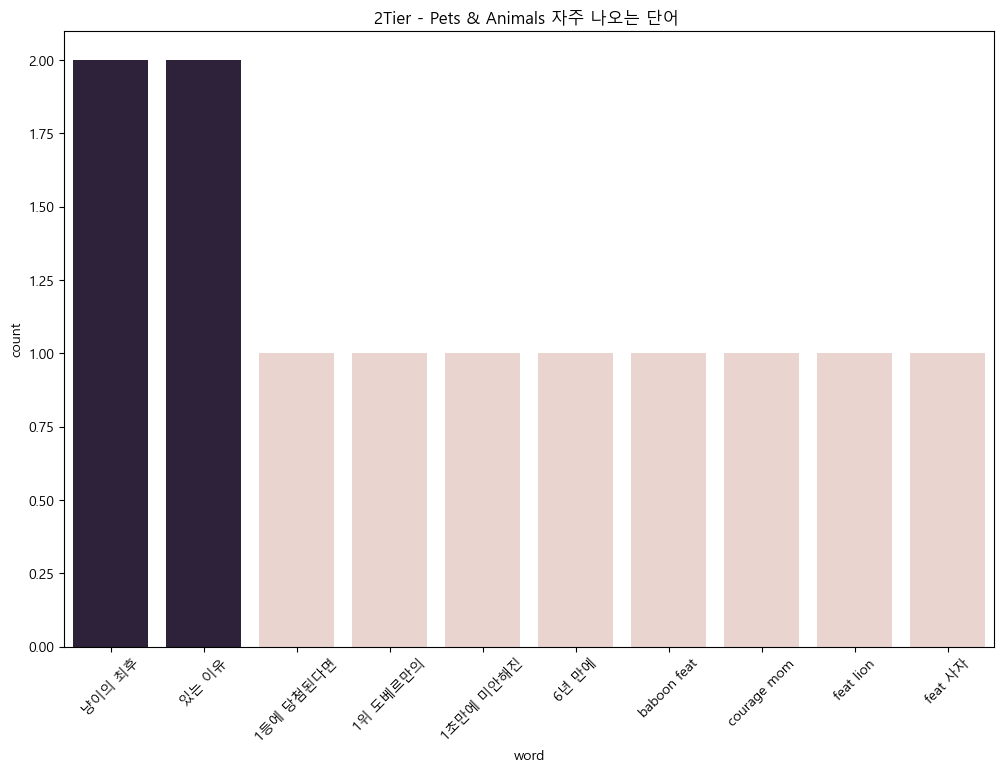

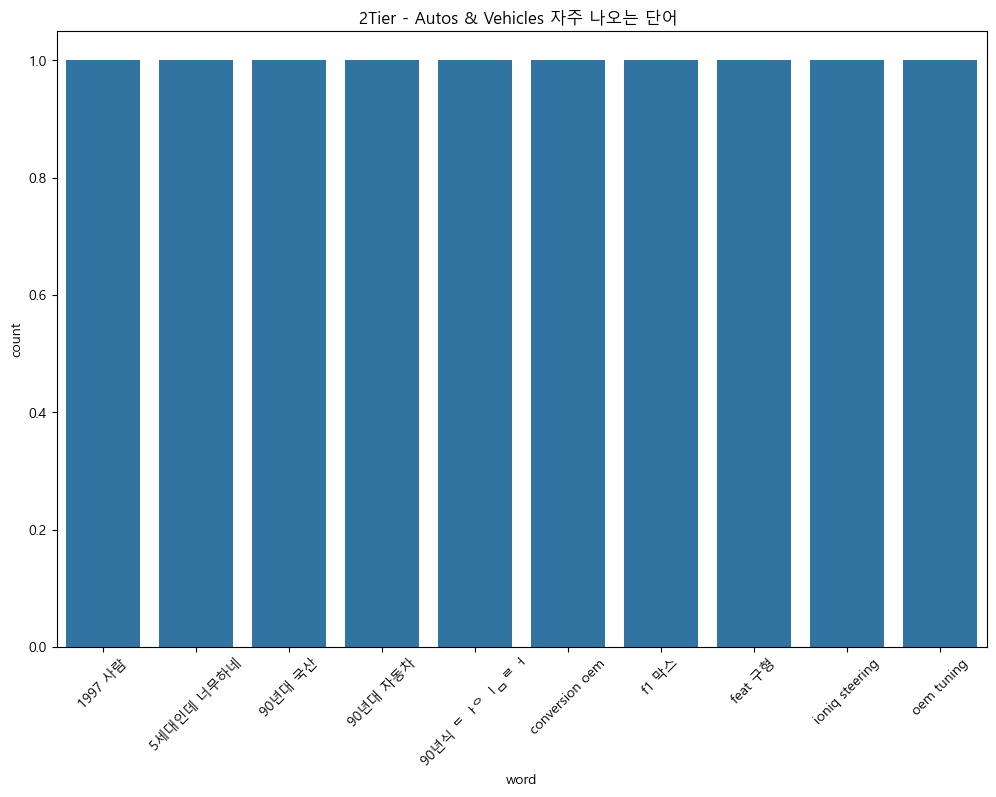

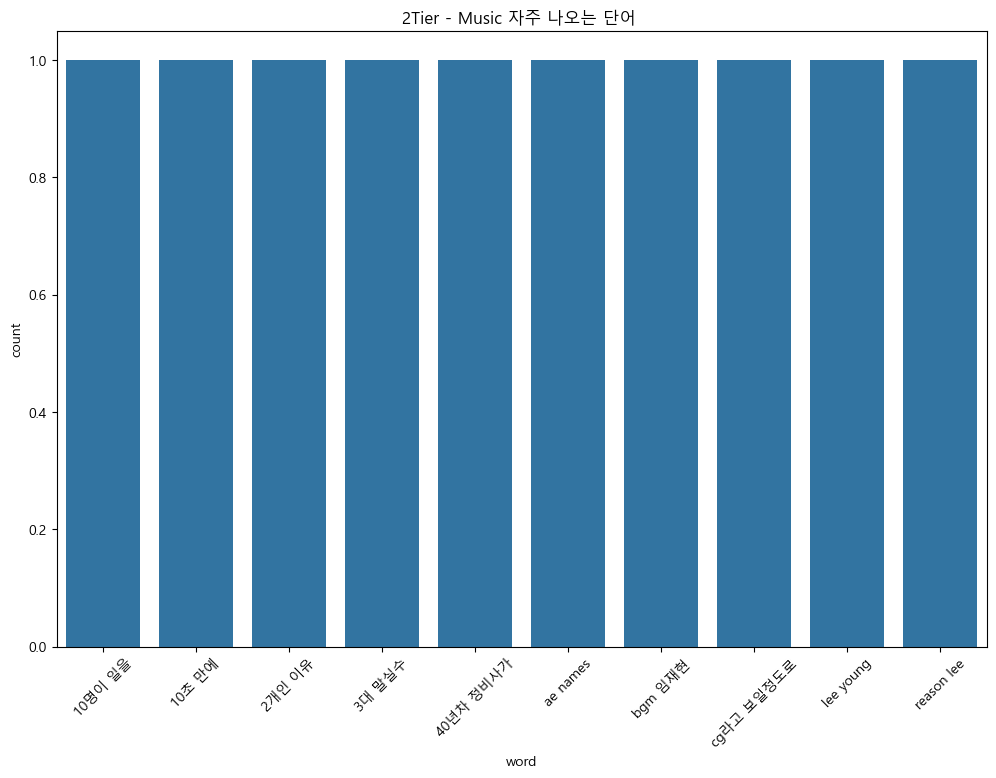

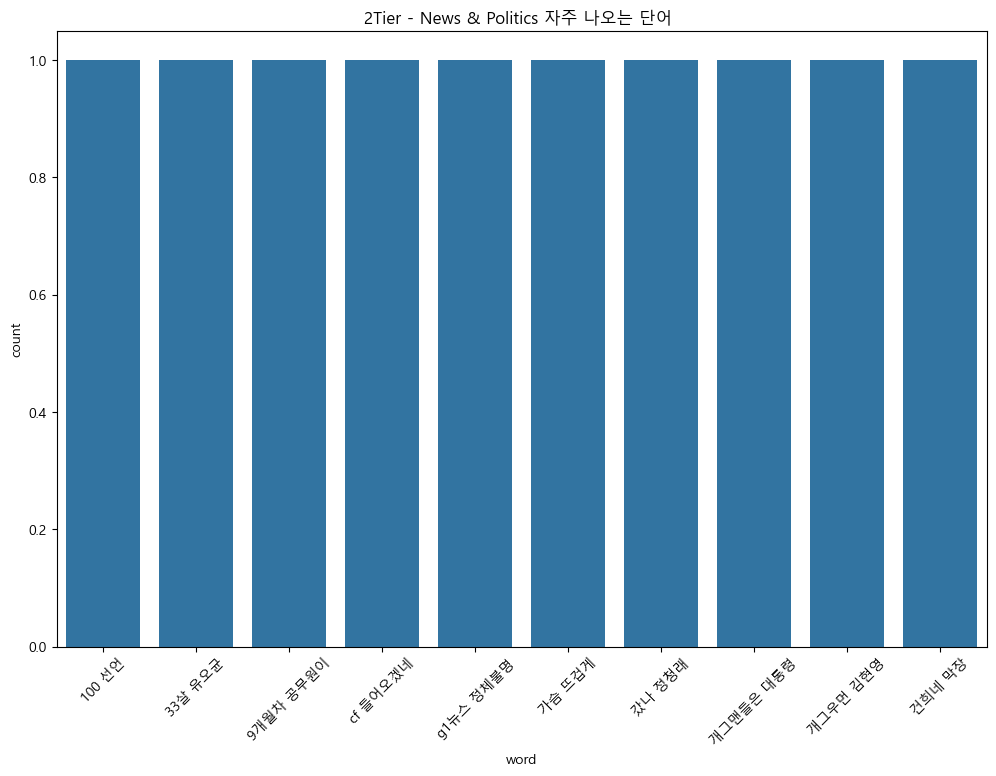

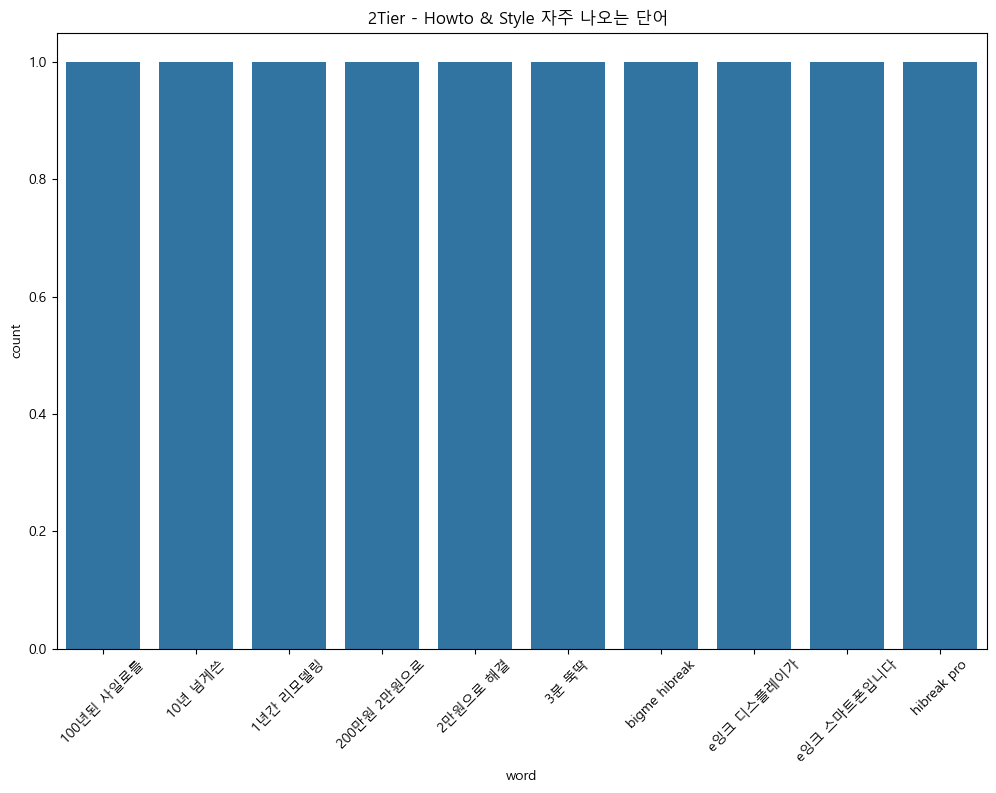

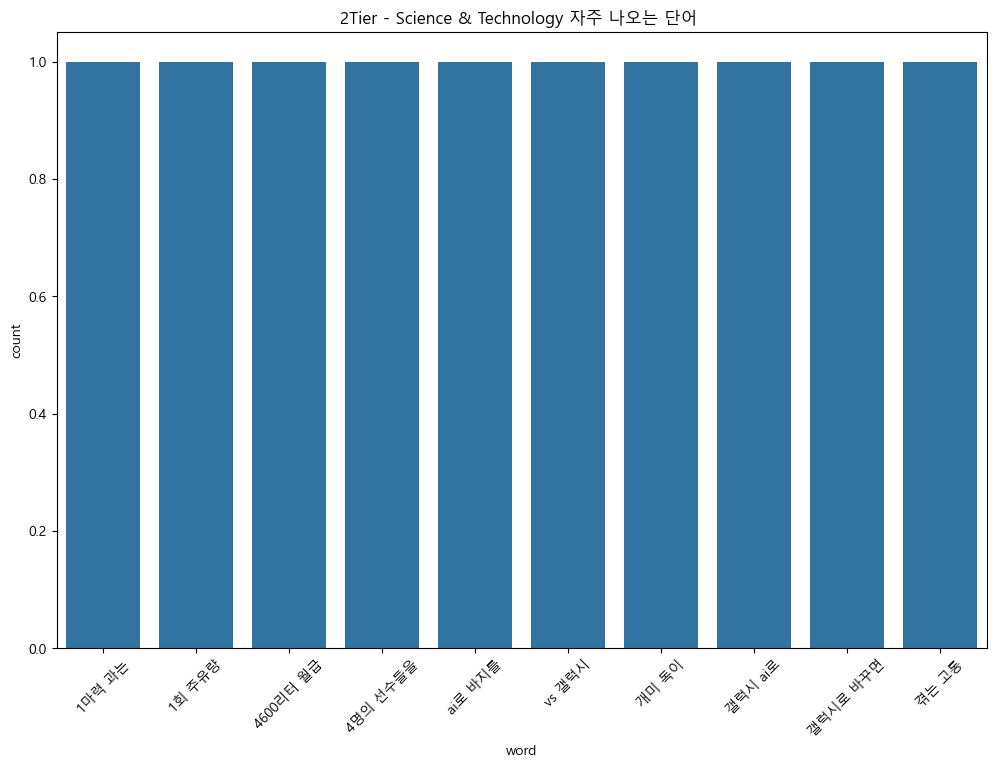

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm

plt.rcParams['font.family'] = 'Malgun Gothic'  # 윈도우 기본 한글 폰트
plt.rcParams['axes.unicode_minus'] = False   

categorys  = ngram_df['category'].unique()
tier = DF['channelTier'].unique()

for tier in tier:
    for cat in categorys:
        plt.figure(figsize=(12,8))
        cate_ngram_df = ngram_df[ngram_df['category']==cat]

        sns.barplot(
            data = cate_ngram_df,
            x= 'word',
            y='count',
            hue='count',
            legend=False
        )
        plt.title(f'{tier}Tier - {cat} 자주 나오는 단어 ')
        plt.xticks(rotation=45)
        plt.show()

---
- (티어) 카테고리별 성과 있는 단어 ( 제목 )

In [24]:
# 단어별 성과 비교 (조회수 평균)
def compare_word_performance(df, word_list, category):
    # 위 Top N개의 단어의 평균 조회수를 DF로 만든다 
    
    temp = []
    for word in word_list:
        sub_df = df[df['category'] == category]
        sub_df['has_word'] = sub_df['clean_title'].str.contains(word)       # True / False
        
        avg_views = sub_df.groupby('has_word')['viewCount'].mean().to_dict()
        count_with = sub_df[sub_df['has_word']].shape[0]
        
        temp.append({
            "category": category,
            "word": word,
            "count_with": count_with,
            "avg_views_with": avg_views.get(True, 0),       # 단어 포함 평균
            "avg_views_without": avg_views.get(False, 0)    # 단어 미포함 평균
        })

    return pd.DataFrame(temp)

# 카테고리별 Top 단어 성과 비교 테이블 만들기
performance_list = []
for cat in ngram_df['category'].unique():
    top_words_cat = ngram_df[ngram_df['category'] == cat]['word'].tolist()
    perf_df = compare_word_performance(DF, top_words_cat, cat)
    performance_list.append(perf_df)

final_perf_df = pd.concat(performance_list, ignore_index=True)

# 조회수 차이 컬럼 추가
final_perf_df['view_diff'] = final_perf_df['avg_views_with'] - final_perf_df['avg_views_without']

# 결과 출력
final_perf_df.sort_values(by='view_diff', ascending=False)

C:\Users\YUN\AppData\Local\Temp\ipykernel_3544\3738688370.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['has_word'] = sub_df['clean_title'].str.contains(word)       # True / False
C:\Users\YUN\AppData\Local\Temp\ipykernel_3544\3738688370.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['has_word'] = sub_df['clean_title'].str.contains(word)       # True / False
C:\Users\YUN\AppData\Local\Temp\ipykernel_3544\3738688370.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy

,category,word,count_with,avg_views_with,avg_views_without,view_diff
33,Entertainment,00 팬인,1,7689043.0,1.272018e+06,6.417025e+06
105,Howto & Style,3분 뚝딱,1,4724707.0,6.914531e+05,4.033254e+06
83,Music,3대 말실수,1,3073705.0,7.707558e+05,2.302949e+06
97,News & Politics,개그맨들은 대통령,1,2339563.0,4.336678e+05,1.905895e+06
65,Pets & Animals,6년 만에,1,2603030.0,1.256863e+06,1.346167e+06
...,...,...,...,...,...,...
68,Pets & Animals,feat lion,0,0.0,1.272516e+06,-1.272516e+06
66,Pets & Animals,baboon feat,0,0.0,1.272516e+06,-1.272516e+06
67,Pets & Animals,courage mom,0,0.0,1.272516e+06,-1.272516e+06
69,Pets & Animals,feat 사자,0,0.0,1.272516e+06,-1.272516e+06


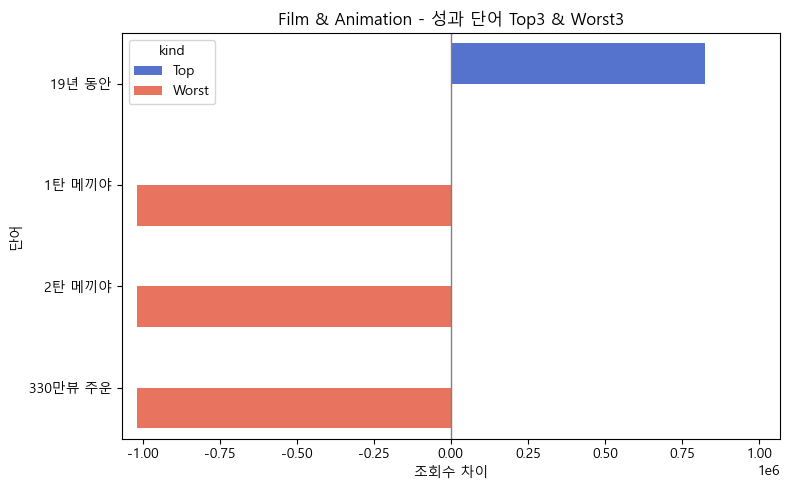

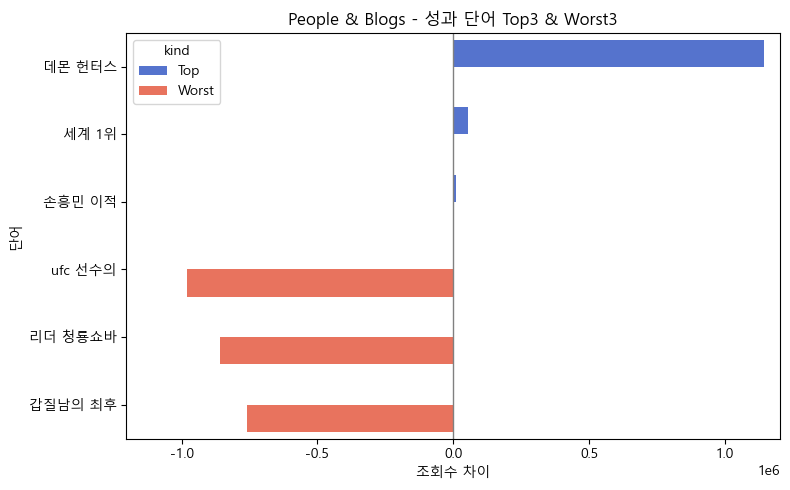

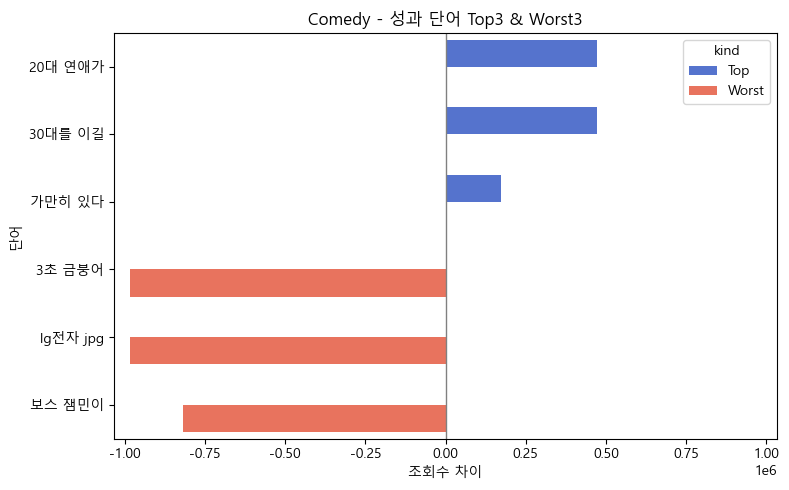

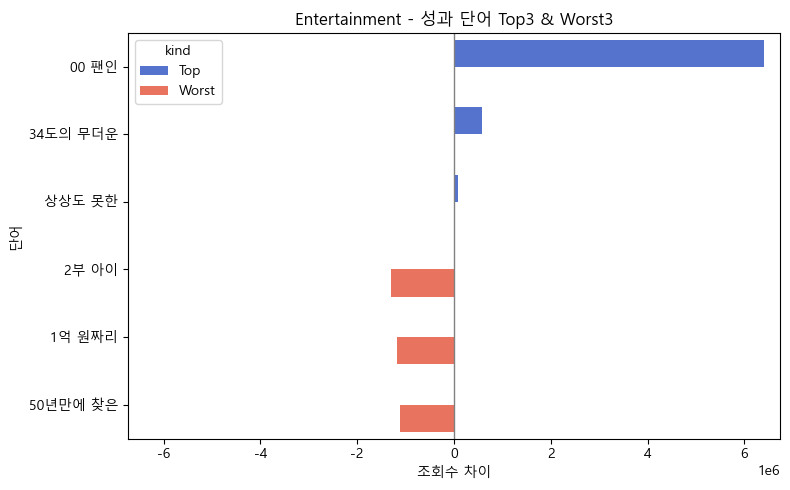

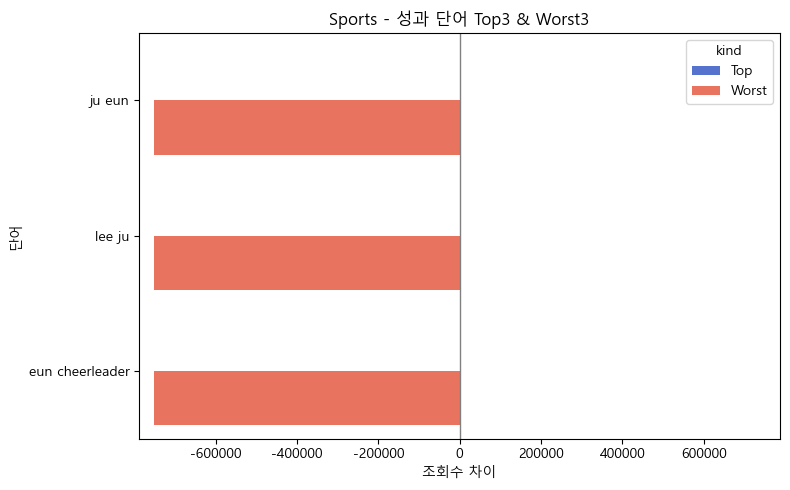

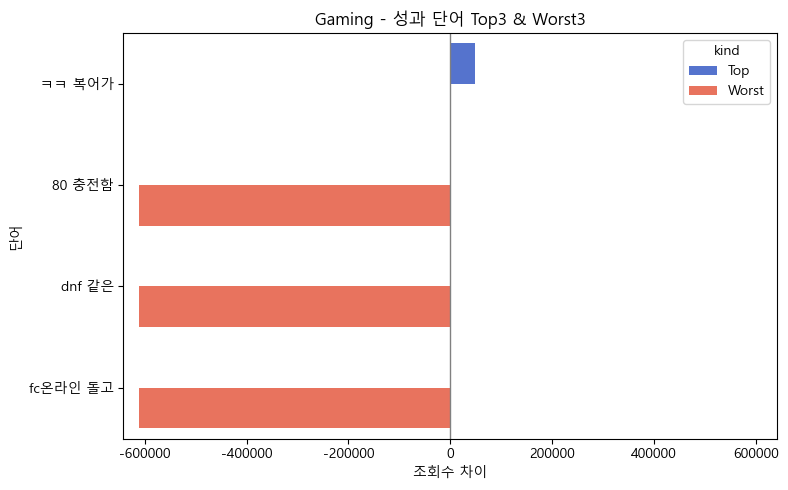

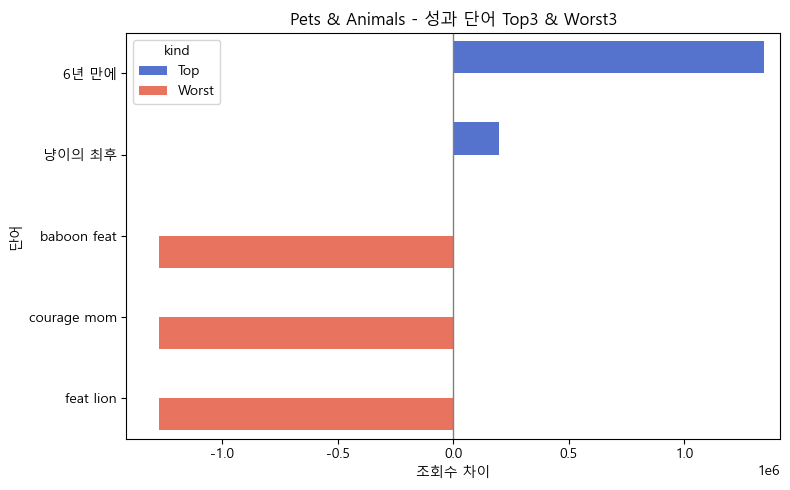

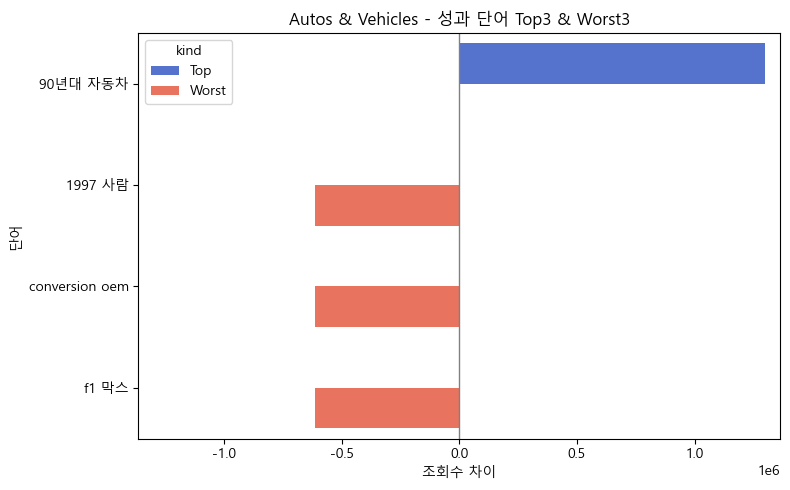

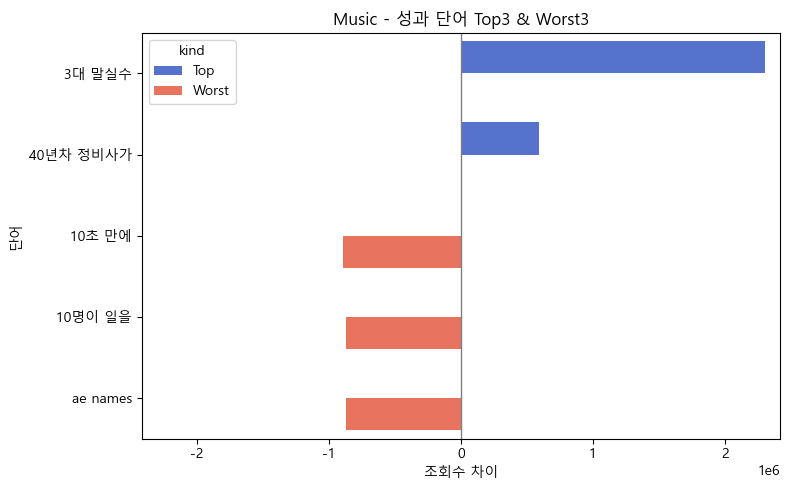

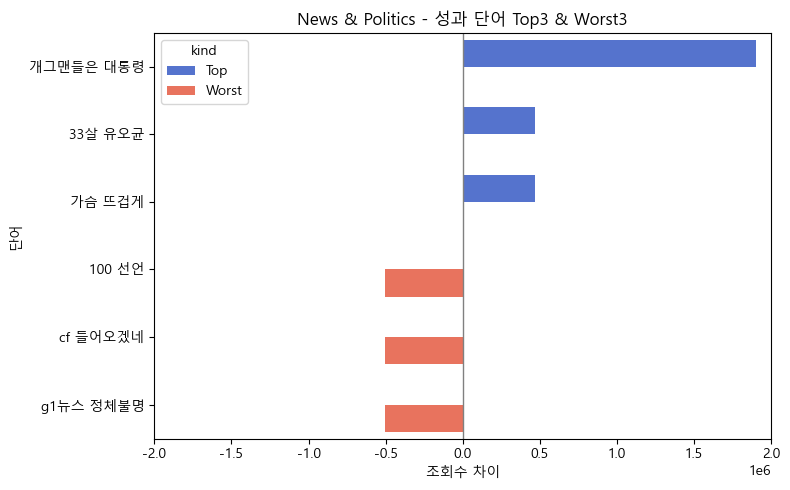

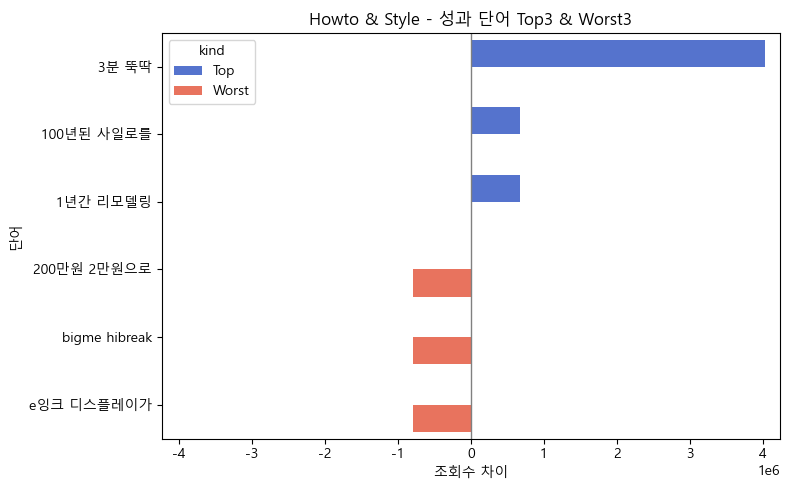

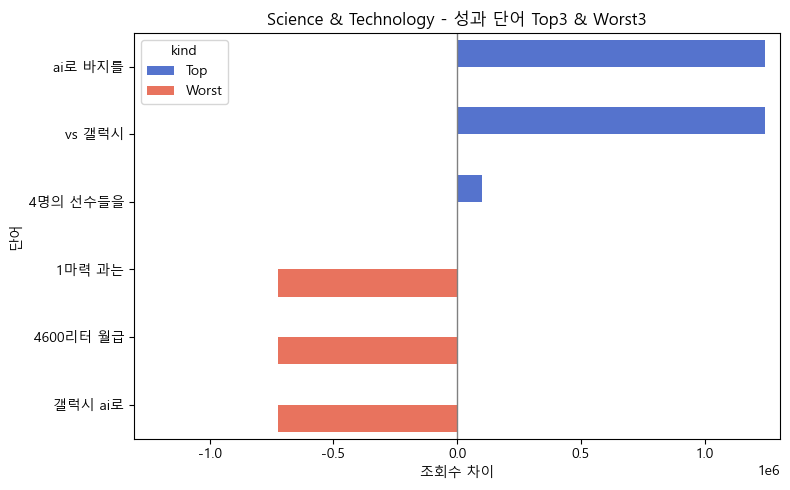

In [25]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

PALETTE = {'Top': 'royalblue', 'Worst': 'tomato'}  # 원하는 색으로 고정
HUE_ORDER = ['Top', 'Worst']

for cat in final_perf_df['category'].unique():
    cat_df = final_perf_df[final_perf_df['category'] == cat].copy()
    cat_df['view_diff'] = pd.to_numeric(cat_df['view_diff'], errors='coerce')

    pos = cat_df[cat_df['view_diff'] > 0]
    neg = cat_df[cat_df['view_diff'] < 0]

    top3   = pos.nlargest(min(3, len(pos)), 'view_diff').assign(kind='Top')
    worst3 = neg.nsmallest(min(3, len(neg)), 'view_diff').assign(kind='Worst')
    plot_df = pd.concat([top3, worst3], ignore_index=True)

    # 색이 항상 같도록 범주 순서 고정
    plot_df['kind'] = pd.Categorical(plot_df['kind'], categories=HUE_ORDER, ordered=True)

    plt.figure(figsize=(8,5))
    ax = sns.barplot(
        data=plot_df, x='view_diff', y='word',
        hue='kind', hue_order=HUE_ORDER, palette=PALETTE,
        orient='h', dodge=True, errorbar=None
    )

    mx = np.nanmax(np.abs(plot_df['view_diff'])) if len(plot_df) else 0
    if mx == 0: mx = 1
    ax.set_xlim(-mx*1.05, mx*1.05)
    ax.axvline(0, color='gray', lw=1)

    ax.set_title(f'{cat} - 성과 단어 Top3 & Worst3')
    ax.set_xlabel('조회수 차이'); ax.set_ylabel('단어')
    plt.tight_layout(); plt.show()


---
- hashtags

In [26]:
DF = DF[DF['hashtags'] != '0']
DF.head()

,id,videoId,title,description,channelTitle,publishedAt,fetchedDate,business_date,viewCount,likeCount,commentCount,category,subscriberCount,channelTier,url,duration_seconds,clean_title,clean_title_len,hashtags
0,26888,_-_X2UMbv0A,사랑과 돈 #맛있는영화 #무비 #영화 #film #movie,NaN,sun무비,2025-08-04 15:01,2025-08-10 16:28,2025-08-09,1237990,39231,834,Film & Animation,11300,2,https://www.youtube.com/watch?v=_-_X2UMbv0A,131,사랑과 돈,5,맛있는영화 무비 영화 film movie
1,29364,_1GYGVokIYo,누가 전원책을 화나게 한거야ㅋㅋ #앵그리버드2 #전원책 #화가많아,NaN,정치핫소스,2025-08-03 8:20,2025-08-10 19:02,2025-08-10,514905,16614,2377,People & Blogs,56200,2,https://www.youtube.com/watch?v=_1GYGVokIYo,103,누가 전원책을 화나게 한거야ㅋㅋ,17,앵그리버드2 전원책 화가많아
3,32956,_38a2Qw2IMo,범죄자에게까지 총이 배달되는 미친 세상 #netflix #범죄,풀 버전 감상을 적극 권장드립니다.\n( #넷플릭스 )\n\n트리거 (2025)\n...,핵심한컷,2025-08-04 9:18,2025-08-11 19:42,2025-08-11,753255,23922,404,People & Blogs,24100,2,https://www.youtube.com/watch?v=_38a2Qw2IMo,57,범죄자에게까지 총이 배달되는 미친 세상,21,netflix 범죄 넷플릭스 트리거 김남길 김영광 장영남 장동주 우지현 김원해 넷플릭스
5,32867,_3zlYiVuHEA,영화 신세계 명장면 (엘리베이터 신 ) #황정민 #정우성 # 나영석 #신세계영화 #...,NaN,Shortform Funny,2025-08-04 9:40,2025-08-11 19:42,2025-08-11,2147242,18242,232,Comedy,13800,2,https://www.youtube.com/watch?v=_3zlYiVuHEA,104,영화 신세계 명장면 (엘리베이터 신 ),21,황정민 정우성 신세계영화
7,17764,_5mKt_Yg1HU,살다보니 후회하는 인테리어 3가지 #인테리어 #살림,"안녕하세요, 헤이로라입니다 :)\n말없이 긴 시간을 보내고,\n이렇게 다시 인사드리...",헤이로라 HeyLaura,2025-07-25 2:35,2025-08-08 3:03,2025-08-07,879478,4649,136,People & Blogs,11000,2,https://www.youtube.com/watch?v=_5mKt_Yg1HU,45,살다보니 후회하는 인테리어 3가지,18,인테리어 살림


In [121]:
top_hashtags_ngrams = cat_flatten_top_words_to_DataFrame(DF, text_col='hashtags', ngram_range=(1,1), top_k=30)
top_hashtags_ngrams

,category,word,count
0,Film & Animation,영화,13
1,Film & Animation,shorts,9
2,Film & Animation,영화리뷰,7
3,Film & Animation,스케치코미디,6
4,Film & Animation,임창정,6
...,...,...,...
355,Gaming,칸나,1
356,Gaming,쿠팡,1
357,Gaming,쿠팡꿀템,1
358,Gaming,클렌징밤,1


In [131]:
top_hashtags_ngrams = top_hashtags_ngrams[~top_hashtags_ngrams['word'].str.contains('쇼츠')]
top_hashtags_ngrams = top_hashtags_ngrams[~top_hashtags_ngrams['word'].str.contains('shorts')]
top_hashtags_ngrams

,category,word,count
0,Film & Animation,영화,13
2,Film & Animation,영화리뷰,7
3,Film & Animation,스케치코미디,6
4,Film & Animation,임창정,6
5,Film & Animation,하지원,6
...,...,...,...
355,Gaming,칸나,1
356,Gaming,쿠팡,1
357,Gaming,쿠팡꿀템,1
358,Gaming,클렌징밤,1


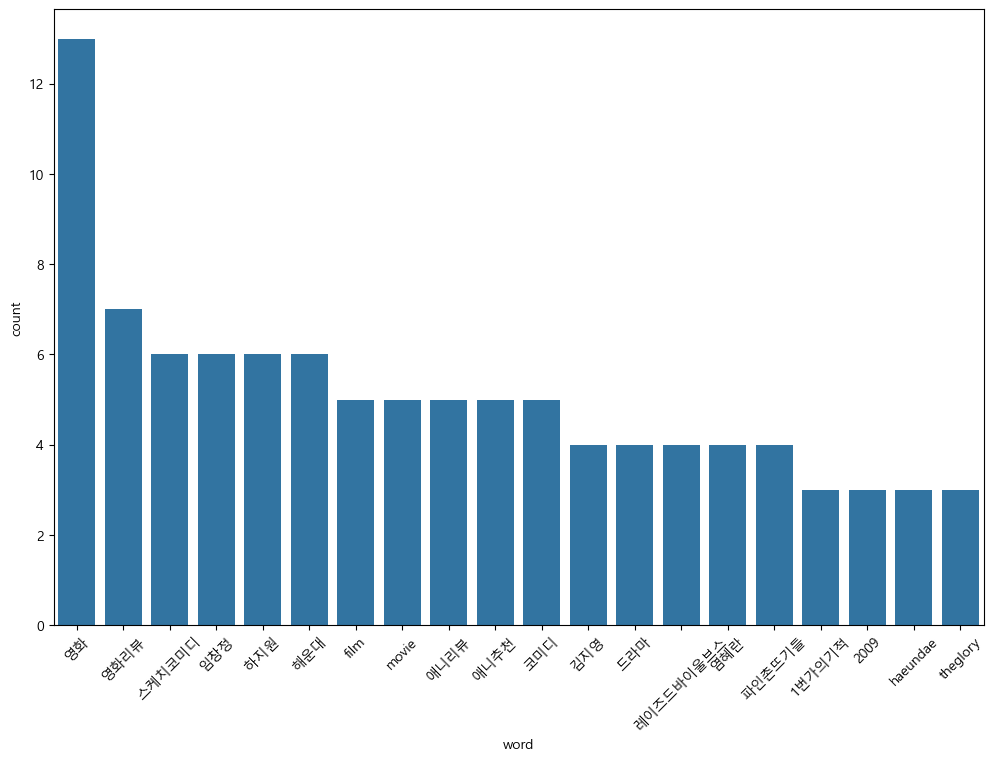

In [133]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(12,8))
sns.barplot(
    data = top_hashtags_ngrams.head(20),
    x='word',
    y='count'
)
plt.xticks(rotation=45)
plt.show()

In [134]:
# 카테고리별 Top 단어 성과 비교 테이블 만들기
performance_list = []
for cat in top_hashtags_ngrams['category'].unique():
    top_words_cat = top_hashtags_ngrams[top_hashtags_ngrams['category'] == cat]['word'].tolist()
    perf_df = compare_word_performance(DF, top_words_cat, cat)
    performance_list.append(perf_df)

final_perf_df = pd.concat(performance_list, ignore_index=True)

# 조회수 차이 컬럼 추가
final_perf_df['view_diff'] = final_perf_df['avg_views_with'] - final_perf_df['avg_views_without']

# 결과 출력
final_perf_df.sort_values(by='view_diff', ascending=False)

C:\Users\YUN\AppData\Local\Temp\ipykernel_5604\3738688370.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['has_word'] = sub_df['clean_title'].str.contains(word)       # True / False
C:\Users\YUN\AppData\Local\Temp\ipykernel_5604\3738688370.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['has_word'] = sub_df['clean_title'].str.contains(word)       # True / False
C:\Users\YUN\AppData\Local\Temp\ipykernel_5604\3738688370.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy

,category,word,count_with,avg_views_with,avg_views_without,view_diff
43,People & Blogs,cute,1,1.060749e+07,2.749543e+06,7.857944e+06
54,People & Blogs,ai,6,1.032193e+07,2.625118e+06,7.696813e+06
175,Music,baby,1,7.866338e+06,2.799491e+06,5.066847e+06
31,People & Blogs,animals,2,6.221412e+06,2.752531e+06,3.468881e+06
265,Howto & Style,赤ちゃん,1,4.533221e+06,1.421834e+06,3.111387e+06
...,...,...,...,...,...,...
290,Science & Technology,amazingview,0,0.000000e+00,3.951288e+06,-3.951288e+06
288,Science & Technology,aerialview,0,0.000000e+00,3.951288e+06,-3.951288e+06
287,Science & Technology,aerialphotography,0,0.000000e+00,3.951288e+06,-3.951288e+06
285,Science & Technology,4k,0,0.000000e+00,3.951288e+06,-3.951288e+06


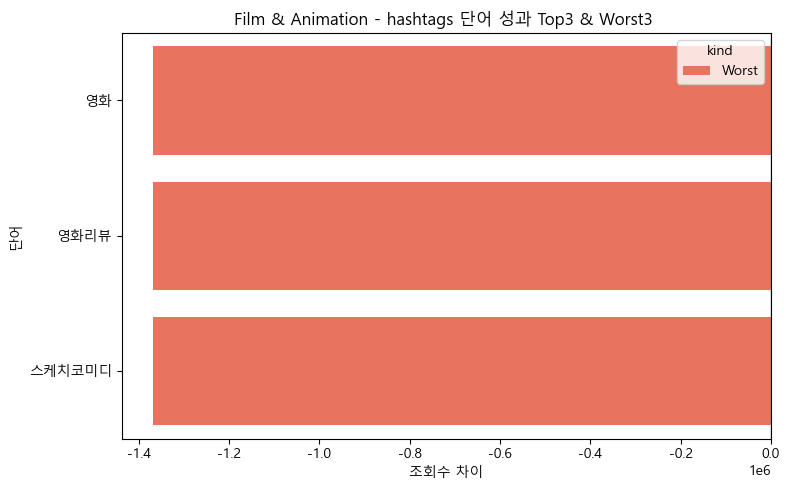

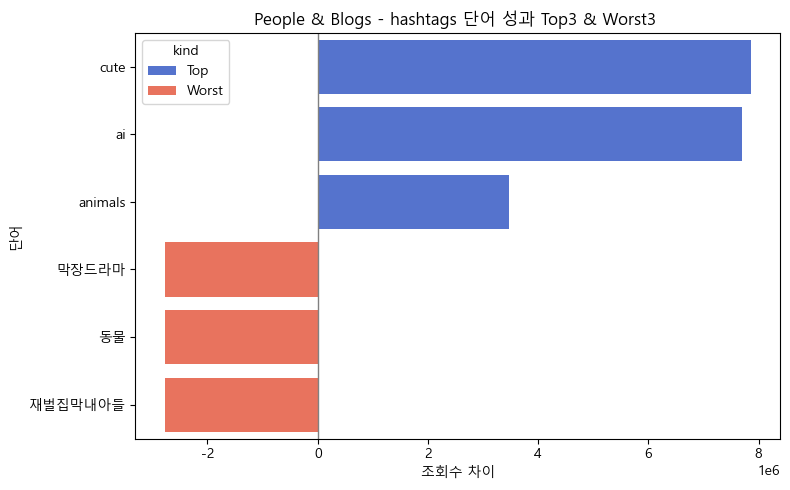

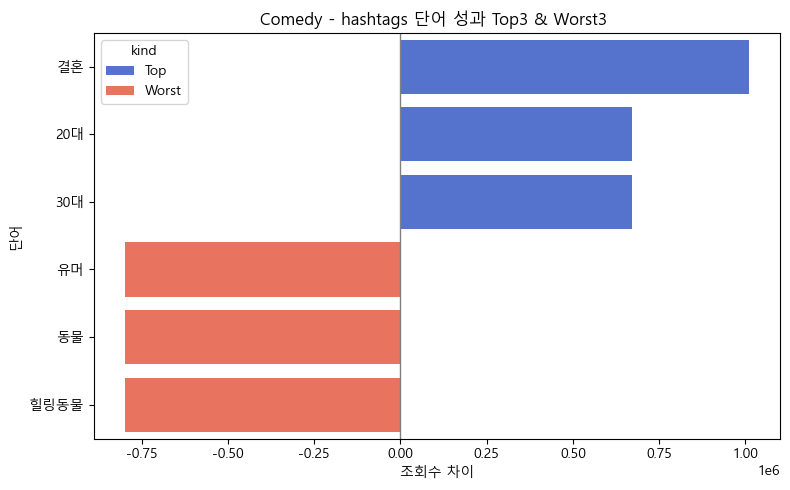

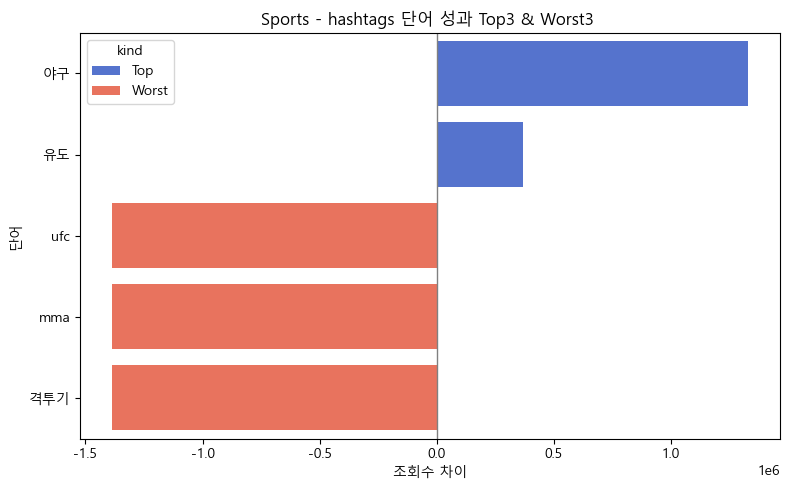

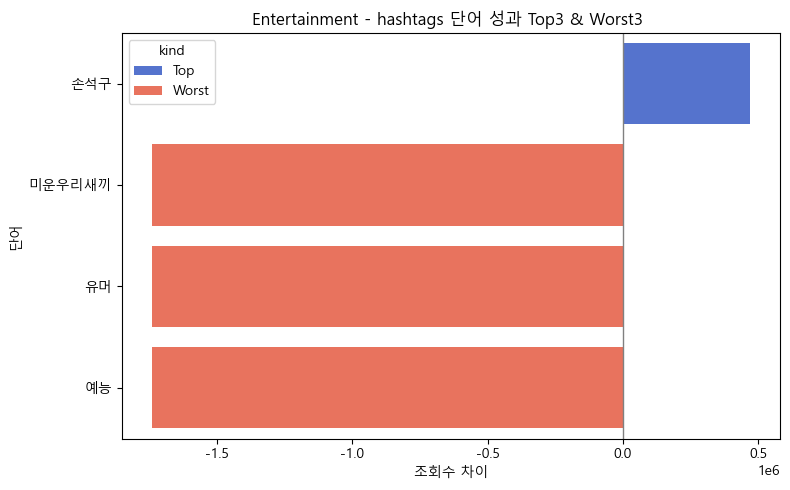

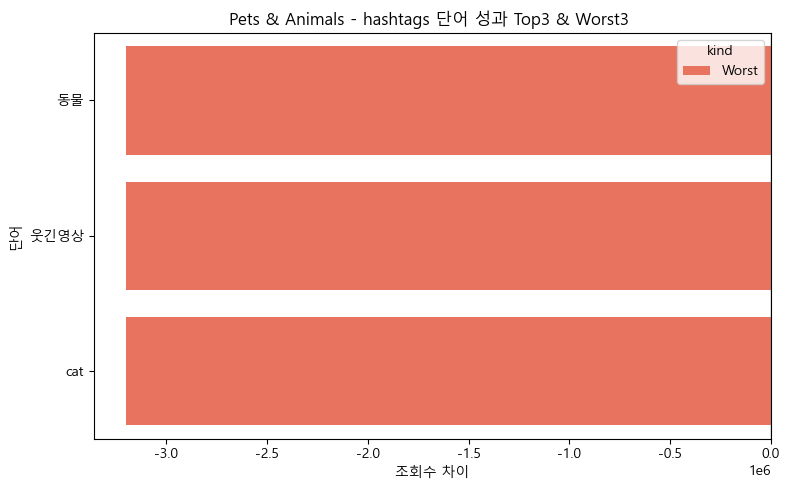

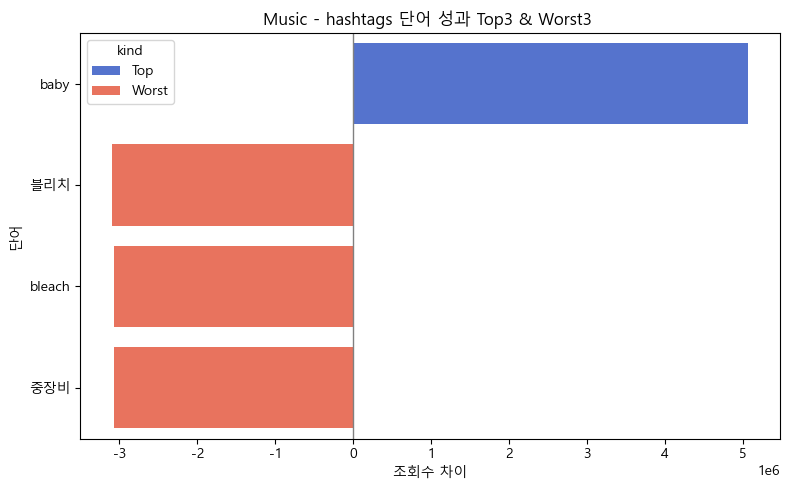

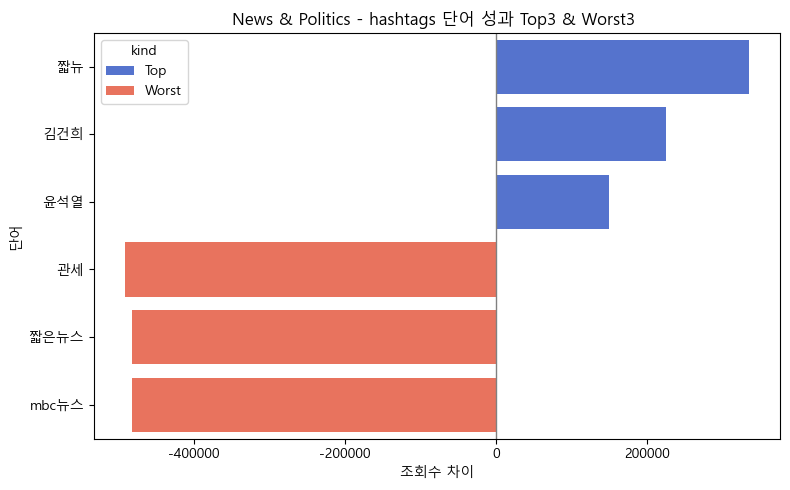

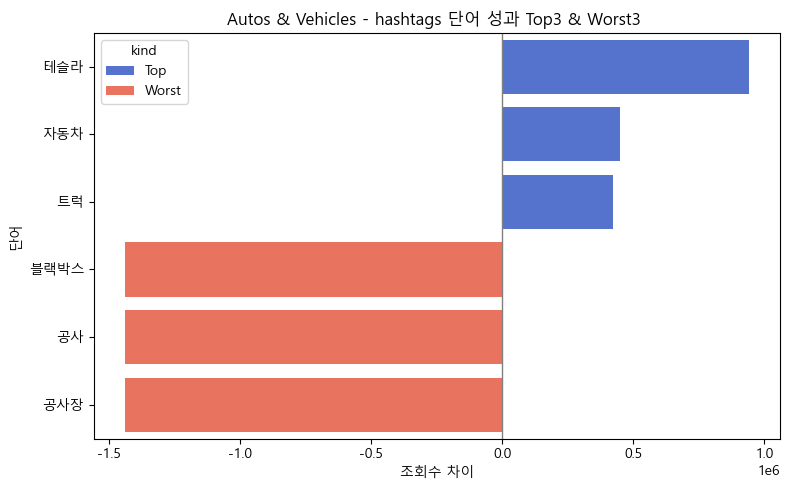

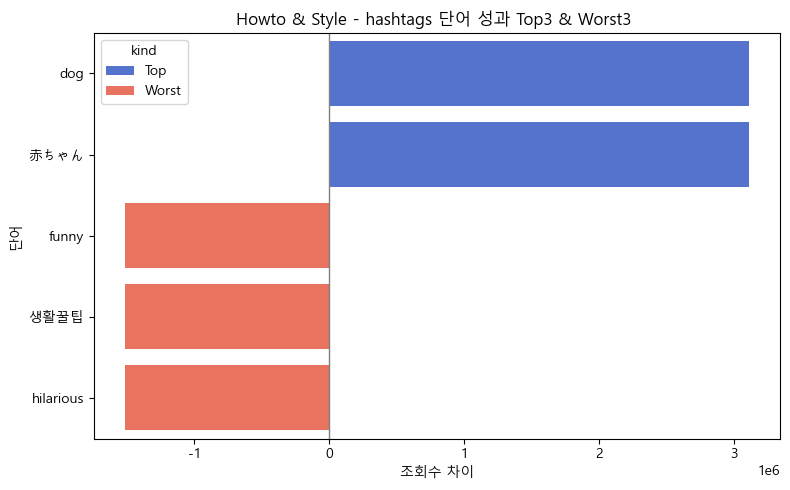

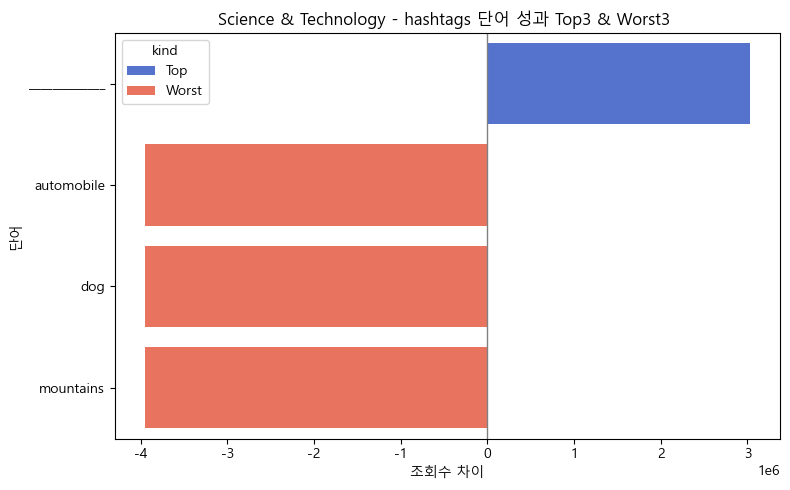

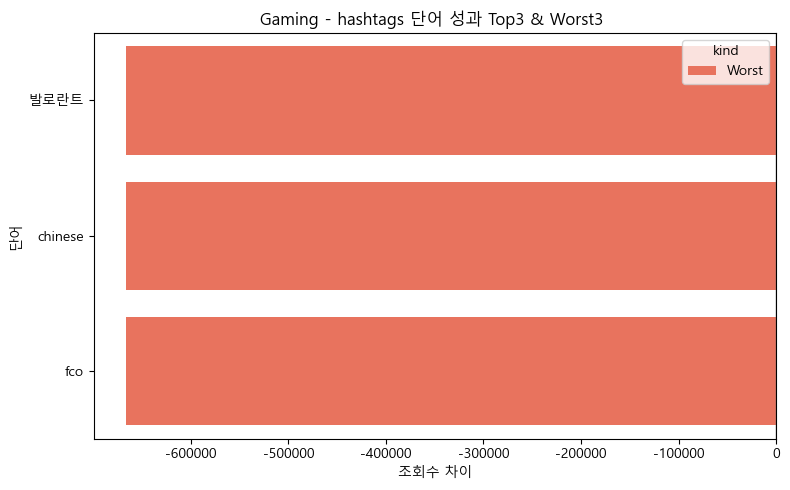

In [135]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.rcParams['font.family'] = 'Malgun Gothic'  # 한글 폰트
plt.rcParams['axes.unicode_minus'] = False

palette = {'Top': 'royalblue', 'Worst': 'tomato'}

for cat in final_perf_df['category'].unique():
    cat_df = final_perf_df[final_perf_df['category'] == cat].copy()

    # 0 기준 양수/음수 나눠서 상위 3개씩
    top3 = cat_df[cat_df['view_diff'] > 0].nlargest(3, 'view_diff').assign(kind='Top')
    worst3 = cat_df[cat_df['view_diff'] < 0].nsmallest(3, 'view_diff').assign(kind='Worst')

    plot_hash_df = pd.concat([top3, worst3], ignore_index=True)

    # 그래프
    plt.figure(figsize=(8, 5))
    sns.barplot(
        data=plot_hash_df,
        x='view_diff', y='word',
        hue='kind', dodge=False, orient='h',
        palette=palette
    )
    plt.axvline(0, color='gray', lw=1)  # 기준선
    plt.title(f"{cat} - hashtags 단어 성과 Top3 & Worst3 ")
    plt.xlabel('조회수 차이')
    plt.ylabel('단어')
    plt.tight_layout()
    plt.show()

---
- ML

In [18]:
import pandas as pd

df = pd.read_csv('./Utube_data/youtube_filtered_clean.csv')

In [19]:
#  문자열 보장 + 첫 번째 # 기준으로만 자르기 + 앞뒤 공백 제거
df['clean_title'] = (
    df['title'].astype(str)
                 .str.split('#', n=1)
                 .str[0]
                 .str.strip()
)

In [20]:
import emoji

# 이모지 제거
def emoji_remove(text):
    text = str(text).lower()
    text = emoji.replace_emoji(text, replace='')  
    return text

df['clean_title'] = df['clean_title'].apply(emoji_remove)

In [21]:
def extract_hashtags(*texts):
    hashtags = []
    for text in texts:
        text = str(text)
        hashtags += [word.replace('#', '') for word in text.split() if '#' in word]
    return ' '.join(hashtags) if hashtags else 0

df['hashtags'] = df.apply(lambda row: extract_hashtags(row['title'], row['description']), axis=1)

---
- clustering ( 구독자, 조회수, 좋아요수 )

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2725 entries, 0 to 2724
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                2725 non-null   int64 
 1   videoId           2725 non-null   object
 2   title             2725 non-null   object
 3   description       1602 non-null   object
 4   channelTitle      2725 non-null   object
 5   publishedAt       2725 non-null   object
 6   fetchedDate       2725 non-null   object
 7   business_date     2725 non-null   object
 8   viewCount         2725 non-null   int64 
 9   likeCount         2725 non-null   int64 
 10  commentCount      2725 non-null   int64 
 11  category          2725 non-null   object
 12  subscriberCount   2725 non-null   int64 
 13  channelTier       2725 non-null   int64 
 14  url               2725 non-null   object
 15  duration_seconds  2725 non-null   int64 
 16  clean_title       2725 non-null   object
 17  hashtags      

In [141]:
from sklearn.cluster import KMeans
feature = df[['viewCount','likeCount','commentCount']]

model = KMeans(n_clusters=3, random_state=13)

model.fit(feature)

KMeans(n_clusters=3, random_state=13)

In [142]:
model.labels_

array([0, 0, 0, ..., 0, 0, 0])

In [143]:
model.cluster_centers_

array([[1.38677829e+06, 3.01775522e+04, 4.84254192e+02],
       [2.62754840e+07, 6.12939333e+05, 2.93847126e+03],
       [7.15311488e+07, 1.56683107e+06, 5.69292857e+03]])

In [146]:
import numpy as np
import matplotlib.pyplot as plt

def plot_clusters_3d(X, labels, centers=None, feature_names=None, title="KMeans Clusters (3D)"):
    if hasattr(X, "values"):
        X_values = X.values
        cols = list(X.columns)
    else:
        X_values = np.asarray(X)
        cols = None

    n_features = X_values.shape[1]
    use_pca = n_features > 3

    pca_model = None
    if use_pca:
        from sklearn.decomposition import PCA
        pca_model = PCA(n_components=3, random_state=42)
        X_plot = pca_model.fit_transform(X_values)
        centers_plot = pca_model.transform(np.asarray(centers)) if centers is not None else None
        feature_names_plot = ["PC1", "PC2", "PC3"]
    else:
        X_plot = X_values[:, :3]
        centers_plot = np.asarray(centers)[:, :3] if centers is not None else None
        if feature_names is not None and len(feature_names) >= 3:
            feature_names_plot = feature_names[:3]
        elif cols is not None and len(cols) >= 3:
            feature_names_plot = cols[:3]
        else:
            feature_names_plot = ["x1", "x2", "x3"]

    from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    labels = np.asarray(labels)
    unique_labels = np.unique(labels)

    for lab in unique_labels:
        mask = labels == lab
        ax.scatter(X_plot[mask, 0], X_plot[mask, 1], X_plot[mask, 2], s=12, label=f"Cluster {lab}", alpha=0.8)

    if centers_plot is not None:
        ax.scatter(centers_plot[:, 0], centers_plot[:, 1], centers_plot[:, 2],
                   s=160, marker='X', edgecolors='k', linewidths=1.0, alpha=0.95, label="Centroids")

    ax.set_xlabel(feature_names_plot[0])
    ax.set_ylabel(feature_names_plot[1])
    ax.set_zlabel(feature_names_plot[2])
    ax.set_title(title)
    ax.legend(loc="best")
    plt.tight_layout()
    plt.show()


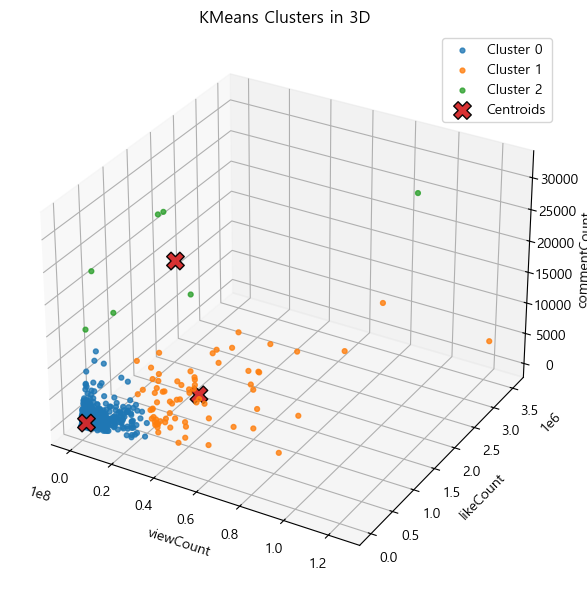

In [147]:
num_cols = ["viewCount", "likeCount", "commentCount"]
X3 = df[num_cols].astype(float)

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

scaler = StandardScaler()
X3s = scaler.fit_transform(X3)

kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
labels = kmeans.fit_predict(X3s)

plot_clusters_3d(
    X3,   # 3개 컬럼만 넘기기
    labels,
    centers=scaler.inverse_transform(kmeans.cluster_centers_),
    feature_names=num_cols,
    title="KMeans Clusters in 3D"
)

In [149]:
# 필요한 라이브러리
# !pip install plotly scikit-learn pandas  # 필요 시 한 번만
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import plotly.express as px

# 1) 숫자 3컬럼만 사용
num_cols = ["viewCount", "likeCount", "commentCount"]   # 실제 컬럼명과 일치하게
X3 = df[num_cols].astype(float)

# 2) (권장) 스케일링 후 KMeans
scaler = StandardScaler()
X3s = scaler.fit_transform(X3)

kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
labels = kmeans.fit_predict(X3s)
'''
# 3) Plotly 3D 산점도 (인터랙티브)
plot_df = X3.copy()
plot_df["cluster"] = labels.astype(str)  # 색상 구분용 문자열 라벨

fig = px.scatter_3d(
    plot_df,
    x="viewCount", y="likeCount", z="commentCount",
    color="cluster",
    opacity=0.8,
    title="KMeans Clusters (views / likes / comments)"
)
fig.update_traces(marker=dict(size=4))
fig.show()
'''
# --- (선택) 센트로이드도 같이 보고 싶다면 ---
# 원공간(스케일 해제) 좌표로 변환하여 X 모양으로 추가 표시
centers_orig = scaler.inverse_transform(kmeans.cluster_centers_)
centers_df = pd.DataFrame(centers_orig, columns=num_cols)
centers_df["cluster"] = [f"C{i}" for i in range(len(centers_df))]

fig2 = px.scatter_3d(
    plot_df, x="viewCount", y="likeCount", z="commentCount",
    color="cluster", opacity=0.7,
    title="KMeans Clusters with Centroids"
)
fig2.add_scatter3d(
    x=centers_df["viewCount"], y=centers_df["likeCount"], z=centers_df["commentCount"],
    mode="markers",
    marker=dict(size=8, symbol="x"),
    name="Centroids"
)
fig2.show()


In [152]:
num_cols = ["viewCount", "likeCount", "commentCount"]
corr_matrix = df[num_cols].corr(method="pearson")  # 피어슨 상관계수 (기본)
print(corr_matrix)

              viewCount  likeCount  commentCount
viewCount      1.000000   0.861190      0.419244
likeCount      0.861190   1.000000      0.520659
commentCount   0.419244   0.520659      1.000000


In [150]:
import numpy as np
centers_scaled = model.cluster_centers_

# 각 변수별 절대값 합을 가중치로 계산 
importance = np.abs(centers_scaled).mean(axis=0)
importance = importance / importance.sum()

print("변수 중요도(가중치 비율):")
for col, imp in zip(['viewCount','likeCount','commentCount'], importance):
    print(f"{col}: {imp:.2%}")

변수 중요도(가중치 비율):
viewCount: 97.81%
likeCount: 2.18%
commentCount: 0.01%


---
- 지도학습 (title -> viewCount)

In [29]:
df['like_ratio'] = df['likeCount'] / df['viewCount'].replace(0, np.nan)
df['comment_ratio'] = df['commentCount'] / df['viewCount'].replace(0, np.nan)

In [85]:
#!pip install sentence_transformers

In [1]:
#!pip uninstall -y torch torchvision torchaudio
#!pip install torch==2.3.1+cpu torchvision==0.18.1+cpu torchaudio==2.3.1+cpu \
#    --index-url https://download.pytorch.org/whl/cpu

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2725 entries, 0 to 2724
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                2725 non-null   int64  
 1   videoId           2725 non-null   object 
 2   title             2725 non-null   object 
 3   description       1602 non-null   object 
 4   channelTitle      2725 non-null   object 
 5   publishedAt       2725 non-null   object 
 6   fetchedDate       2725 non-null   object 
 7   business_date     2725 non-null   object 
 8   viewCount         2725 non-null   int64  
 9   likeCount         2725 non-null   int64  
 10  commentCount      2725 non-null   int64  
 11  category          2725 non-null   object 
 12  subscriberCount   2725 non-null   int64  
 13  channelTier       2725 non-null   int64  
 14  url               2725 non-null   object 
 15  duration_seconds  2725 non-null   int64  
 16  like_ratio        2725 non-null   float64


In [34]:
# ===== 1) 준비 =====
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingRegressor
import torch
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer   # => 가중치 반영


# df: 제목 컬럼과 타깃(조회수)이 있다고 가정
# df['clean_title'] = ... (앞서 만든 전처리 사용)
# 타깃은 log1p로 안정화하는 걸 권장
y = np.log1p(df['viewCount'])   # 로그변환으로 분산을 줄이고, 학습을 안정화되고, 큰채널의 영향이 과도하게 커지는걸 완화 
X = df[['clean_title', 'like_ratio', 'comment_ratio', 'category']]

# ===== 2) 임베딩 트랜스포머 =====
# sentence-transformers 모델을 sklearn Pipeline에서 쓰려면 fit/transform을 구현해야 함
from sentence_transformers import SentenceTransformer

class SBERTEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, model_name='paraphrase-multilingual-MiniLM-L12-v2', batch_size=256, device=None):
        # 기본 모델: paraphrase-multilingual-MiniLM-L12-v2 (한국어 포함 멀티링구얼; 임베딩 차원 384)
        self.model_name = model_name
        self.batch_size = batch_size
        self.device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = None


    def fit(self, X, y=None):
        if self.model is None:
            self.model = SentenceTransformer(self.model_name, device=self.device)
        return self

    # transform에서 실제로 텍스트 리스트를 임베딩 벡터로 변환
    def transform(self, X):
        # X: iterable of strings
        if self.model is None:
            self.model = SentenceTransformer(self.model_name, device=self.device)
        # encode returns np.array (n_samples, dim)
        emb = self.model.encode(
            list(X),
            batch_size=self.batch_size,
            convert_to_numpy=True,
            show_progress_bar=True,
            normalize_embeddings=True  
# normalize_embeddings=True: 임베딩을 L2 정규화해서 코사인 공간과 유사하게 만듭니다. 회귀/트리 모델에 안정적으로 들어가도록 스케일을 맞추는 효과가 큽니다.
        )
        return emb      # 반환값: (샘플 수, 임베딩 차원)의 np.array.


In [35]:
from sklearn.model_selection import KFold

---
- 모델 다양성

In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [38]:
# 분류기 성능 평가 함수
def get_clf_eval(y_test,pred):
    acc = accuracy_score(y_test,pred)
    pre = precision_score(y_test,pred)
    re = recall_score(y_test,pred)
    f1 = f1_score(y_test,pred)
    auc = roc_auc_score(y_test,pred)
    
    return acc, pre, re, f1, auc

In [39]:
from sklearn.metrics import confusion_matrix

def print_clf_eval(y_test,pred):
    acc, pre, re, f1, auc = get_clf_eval(y_test,pred)
    confusion = confusion_matrix(y_test,pred)

    print('==> Congusion matrix')
    print(confusion)
    print('==================================================================================')
    print('==> accuracy:{0:.4f}, precision:{1:.4f}'.format(acc,pre))
    print('==> Recall:{0:.4f}, F1 Score:{1:.4f}, Roc Auc Score:{2:.4f}'.format(re,f1,auc))  

In [40]:
from sklearn.model_selection import train_test_split

X = df[['clean_title', 'like_ratio', 'comment_ratio', 'category']]
y = np.log1p(df['viewCount'])   # 로그변환으로 분산을 줄이고, 학습을 안정화되고, 큰채널의 영향이 과도하게 커지는걸 완화 

X_train_2 , X_test_2, y_train_2, y_test_2 = train_test_split(X,y, test_size=0.2, random_state=13)

In [23]:
#!pip install xgboost

---
- 선형 모델 비교

In [53]:
# ============================ 선형모델 5개 비교: 전체 코드 ============================
# 필요한 import들
import numpy as np
import pandas as pd
from typing import Optional, Dict
from collections import OrderedDict

from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline

# 선형 회귀기들 (5개)
from sklearn.linear_model import (
    LinearRegression,
    RidgeCV,
    Lasso,
    ElasticNetCV,
    HuberRegressor,
)

# 전처리
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer

# 텍스트 임베딩 변환기 (프로젝트에 이미 정의되어 있어야 합니다)
# 예: from your_module import SBERTEncoder
# 여기서는 사용 환경에 SBERTEncoder 클래스가 존재한다고 가정합니다.
# ---------------------------------------------------------------------

# ------------------------------------------------------------
# 회귀 모델 비교 함수
# ------------------------------------------------------------
def compare_regressors(models: Dict[str, object],
                       X_train, y_train, X_test, y_test,
                       preprocessor,
                       kfold: Optional[KFold] = None,
                       call_print_clf_eval: bool = False):   # 회귀라 기본 False 권장
    """
    models: {"모델이름": regressor_instance, ...}
    preprocessor: ColumnTransformer (SBERT/원핫/가중치 등 포함)
    kfold: KFold(...) 넣으면 CV RMSE도 계산
    """
    results = []
    fitted = OrderedDict()

    for name, reg in models.items():
        pipe = Pipeline([("pre", preprocessor), ("reg", reg)])
        pipe.fit(X_train, y_train)
        fitted[name] = pipe

        pred = pipe.predict(X_test)

        # 기본 회귀 지표
        rmse = np.sqrt(mean_squared_error(y_test, pred))
        mae  = mean_absolute_error(y_test, pred)
        r2   = r2_score(y_test, pred)

        # y가 log1p(viewCount)인 경우 실제 스케일 RMSE
        rmse_real = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(pred)))

        # KFold CV (선택)
        cv_rmse = cv_std = np.nan
        if kfold is not None:
            cv_scores = -cross_val_score(
                pipe, X_train, y_train,
                cv=kfold, scoring="neg_root_mean_squared_error", n_jobs=1
            )
            cv_rmse, cv_std = cv_scores.mean(), cv_scores.std()

        results.append({
            "Model": name,
            "RMSE(log1p)": rmse,
            "MAE(log1p)": mae,
            "R2": r2,
            "CV_RMSE(log1p)": cv_rmse,
            "CV_std": cv_std,
            "RMSE(real)": rmse_real
        })

        # (선택) 분류용 print_clf_eval이 있으면 호출 — 회귀에선 보통 False로 두세요
        if call_print_clf_eval:
            try:
                print(f"\n[{name}] print_clf_eval 출력")
                print_clf_eval(y_test, pred)
            except NameError:
                pass

    results_df = pd.DataFrame(results).sort_values("RMSE(log1p)").reset_index(drop=True)
    return results_df, fitted

#----------------------------------------------------------------------------------------------------------------
# 숫자 전처리: 가중치만 적용
numeric_features = ['like_ratio', 'comment_ratio']         # 숫자: 표준화
#numeric_transformer = StandardScaler()

# 가중치 적용 (좋아요 0.2, 댓글 0.01, 댓글 가중치 빼고 싶으면 0.0으로)
LIKE_WEIGHT = 0.2
COMMENT_WEIGHT = 0.01   # 필요 없으면 0.0

def apply_weights(X):
    import numpy as np
    X = np.array(X, dtype=float, copy=True)
    # X shape: (n_samples, 2) -> [like_ratio, comment_ratio]
    X[:, 0] *= LIKE_WEIGHT
    if X.shape[1] > 1:
        X[:, 1] *= COMMENT_WEIGHT
    return X

numeric_transformer = Pipeline(steps=[
    #('scaler', StandardScaler()),
    ('weights', FunctionTransformer(apply_weights, validate=False)),
])

# 범주 전처리: 원-핫
categorical_features = ['category']
# scikit-learn 1.2+ 이면 sparse_output=False, 낮으면 sparse=False 사용
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# 텍스트 전처리: SBERT 임베딩 (사용 중인 구현체 사용)
text_features = 'clean_title'
text_transformer = SBERTEncoder()

# (2) 서로 다른 전처리를 합치는 ColumnTransformer
# ColumnTransformer가 각 컬럼을 해당 변환기로 병렬 처리하고 가로로 이어붙여 단일 특성 행렬을 만듭니다.
# 최종 차원 예: 2(숫자) + 카테고리 개수(원핫) + 임베딩 차원(예:384)
preprocessor = ColumnTransformer(
    transformers=[
        ('num',  numeric_transformer,     numeric_features),    # like_ratio, comment_ratio
        ('cat',  categorical_transformer, categorical_features),# category -> one-hot
        ('text', text_transformer,        text_features),       # clean_title -> embeddings
    ],
    remainder='drop'
)

#----------------------------------------------------------------------------------------------------------------
# 모델들: 선형 5개만
ridge_alphas = np.logspace(-3, 3, 13)

models = OrderedDict({
    "LinearRegression": LinearRegression(),                         # 일반 선형회귀
    "RidgeCV":         RidgeCV(alphas=ridge_alphas, cv=5),          # L2 규제 + CV
    "Lasso":           Lasso(alpha=1e-3, max_iter=10000),           # L1 규제
    "ElasticNetCV":    ElasticNetCV(l1_ratio=[0.15,0.5,0.85],       # L1/L2 혼합 + CV
                                    alphas=np.logspace(-3,1,10),
                                    cv=5, max_iter=20000),
    "HuberRegressor":  HuberRegressor(epsilon=1.35, max_iter=1000)  # 이상치 강건 선형회귀
})

# 교차검증 설정
kf = KFold(n_splits=5, shuffle=True, random_state=13)

# 실행 (X_train_2, X_test_2, y_train_2, y_test_2는 이미 준비되어 있다고 가정)
results_df, fitted_pipes = compare_regressors(
    models=models,
    X_train=X_train_2, y_train=y_train_2,
    X_test=X_test_2,   y_test=y_test_2,
    preprocessor=preprocessor,
    kfold=kf,
    call_print_clf_eval=False
)

print(results_df)

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

c:\Users\YUN\miniconda3\envs\my_mL\lib\site-packages\sklearn\linear_model\_huber.py:343: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

c:\Users\YUN\miniconda3\envs\my_mL\lib\site-packages\sklearn\linear_model\_huber.py:343: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

c:\Users\YUN\miniconda3\envs\my_mL\lib\site-packages\sklearn\linear_model\_huber.py:343: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

c:\Users\YUN\miniconda3\envs\my_mL\lib\site-packages\sklearn\linear_model\_huber.py:343: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

c:\Users\YUN\miniconda3\envs\my_mL\lib\site-packages\sklearn\linear_model\_huber.py:343: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

c:\Users\YUN\miniconda3\envs\my_mL\lib\site-packages\sklearn\linear_model\_huber.py:343: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

              Model  RMSE(log1p)  MAE(log1p)        R2  CV_RMSE(log1p)  \
0           RidgeCV     1.026848    0.809521  0.043897        0.993841   
1      ElasticNetCV     1.027725    0.810257  0.042263        0.995441   
2             Lasso     1.029694    0.812516  0.038590        0.994962   
3  LinearRegression     1.167476    0.906426 -0.235914        1.173827   
4    HuberRegressor     1.204574    0.935144 -0.315708        1.173097   

     CV_std    RMSE(real)  
0  0.060482  1.754149e+06  
1  0.057600  1.753124e+06  
2  0.057758  1.752787e+06  
3  0.058006  1.796558e+06  
4  0.048333  1.835996e+06  


In [90]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import KFold
from dataclasses import dataclass
from typing import Tuple, Sequence, Union   # FIX: Union 추가

# ---------------------------------------------
# RidgeCV용 설정 dataclass
# - n-gram/희귀어 컷오프/그룹 최소 표본/알파 후보 등을 한 곳에서 제어
# ---------------------------------------------
@dataclass(frozen=True)
class RidgeCfg:  # FIX
    ngram_range: Tuple[int, int] = (1, 2)     # FIX: 기본 (1,2)
    min_df: int = 2                            # 전체에서 2개 미만 토큰 제거(완화)
    min_group_n: int = 30                      # 그룹 최소 표본(완화)
    min_count_in_group: Union[str, int] = 'auto'  # FIX: Python 3.9 호환(Union 사용)
    cv_alphas: Sequence[float] = (0.1, 0.3, 1.0, 3.0, 10.0, 30.0)  # 과적합 방지 계수
    random_state: int = 42

DEFAULT_RIDGE_CFG = RidgeCfg()  # FIX

def _fit_group_ridge_and_rank(
    gdf: pd.DataFrame,
    text_col='clean_title',
    target_col='viewCount',
    ngram_range=(1,2),
    min_df=2,                 # 전체에서 2개 미만 토큰 제거(완화)
    min_count_in_group=10,    # 이 그룹에서 최소 등장 문서 수(완화)
    cv_alphas=(0.1, 0.3, 1.0, 3.0, 10.0, 30.0),     # 과적합 방지 계수 
    random_state=42
):
    gdf = gdf.copy()
    y = np.log1p(gdf[target_col].astype(float).values)
    # 타깃을 로그 변환(log1p) → 곱셈적(비율) 효과를 덧셈적으로 모델링하게 만듦 (뒤에서 coef를 다시 exp로 되돌림)

    vec = CountVectorizer(ngram_range=ngram_range, 
                          min_df=min_df,
                          binary=True,                      # 단어 “존재/부재”(0/1)로 단순화
                          lowercase=False,                  # 한글/대문자 보존
                          token_pattern=r'(?u)\b\w+\b'      # 단어 토큰 정의(한글/영문/숫자 포함)
                          )
    X = vec.fit_transform(gdf[text_col].fillna(''))        
     # X는 희소행렬(문서 × 단어). binary=True라 각 단어는 있으면 1, 없으면 0 => 계수 해석이 깔끔함

    # 5-fold CV로 **가장 성능이 좋은 alpha_**를 고르고, 그 값으로 최종 모델 학습 완료.
    ridge = RidgeCV(alphas=cv_alphas, cv=KFold(n_splits=5, shuffle=True, random_state=random_state))
    ridge.fit(X, y)

    vocab = np.array(vec.get_feature_names_out())
    coefs = ridge.coef_.astype(float)
    # ridge.coef_는 X의 열 순서 그대로 각 열의 계수(가중치) 를 담음
    # coefs[0]는 X의 0번째 열(= vocab[0] 단어)의 가중치
    # vocab[i] ↔ coefs[i] 1:1 대응. coefs[i]는 로그 스케일에서 단어 i의 기여도(가중치)

    word_n = np.asarray(X.sum(axis=0)).ravel().astype(int)  # 각 단어가 등장한 개수 / ravel => 평탄화
    group_n = X.shape[0]                                    # 그룹 전체 동영상 수
    share = word_n / max(group_n, 1)                        # 그룹 내 점유율    

    # 너무 희귀한 단어 제거(과적합/우연효과 방지).
    m = word_n >= min_count_in_group    # 각 단어 등장 횟수가 10보다 클 경우 
    vocab, coefs, word_n, share = vocab[m], coefs[m], word_n[m], share[m]

    # -------------------- 무조건 결과 보장(1): 필터 후 특성 0개 방어 --------------------
    # FIX: 희귀어 필터링 후 남는 단어가 없을 때, 빈도 기반 테이블을 만들어 반환
    if len(vocab) == 0:
        base_vocab = np.array(vec.get_feature_names_out())
        base_wn = np.asarray(X.sum(axis=0)).ravel().astype(int)
        base_share = base_wn / max(group_n, 1)
        base = pd.DataFrame({
            'word': base_vocab,
            'coef': np.zeros(len(base_vocab), dtype=float),
            'uplift_pct': np.zeros(len(base_vocab), dtype=float),
            'word_n': base_wn,
            'share_in_group': base_share,
            'group_n': group_n,
            'cv_r2': np.nan,
            'baseline_views': np.expm1(y.mean())
        }).sort_values(['word_n','share_in_group'], ascending=False).reset_index(drop=True)
        pos = base.copy()
        neg = base.sort_values(['uplift_pct','word_n'], ascending=[True, False]).reset_index(drop=True)
        return pos, neg, ridge.alpha_
    # ------------------------------------------------------------------------------

    # 로그모델에서 ŷ = β0 + βᵢ·xᵢ + ... 이므로, 단어 i가 추가되면 로그예측이 +β
    # 로그 스케일에서의 증가량(가중치) = 차이가 바로 βᵢ(coefs) 
    # 원래 조회수 스케일에서의 퍼센트 변화를 보고 싶을 때의 공식 
    uplift_pct = (np.exp(coefs) - 1.0) * 100.0

    # 선택된 alpha_로 다시 5-fold 분할을 돌려 fold 바깥 예측(OOF) 을 만들고, 그걸로 R² 계산.
    # 이 R²는 해당 그룹에서 모델이 얼마나 설명하는지의 대략적 신뢰도 지표
    kf = KFold(n_splits=5, shuffle=True, random_state=random_state)
    oof = np.zeros_like(y, dtype=float)                     # zero_like => y과 같은 배열을 0으로 채움
    for tr, va in kf.split(X):                              # tr = 학습용 인덱스(4), va = 검증용 인덱스(1) / n_splits => 5 
        m = RidgeCV(alphas=[ridge.alpha_], cv=None)         # cv = None => RidgeCV 안에서 교차검증을 돌리지 않겠다는 뜻
        # 앞에서 이미 고른 최적의 α(규제 강도) 를 그대로 고정해서, 새 모델 m 을 하나 만든다 / 더 이상 α를 고르지 않고 그 α로만 학습하겠다는 뜻.  
        m.fit(X[tr], y[tr])
        oof[va] = m.predict(X[va])
    ybar = y.mean()                                         # 조회수 평균 
    ss_res = np.sum((y - oof) ** 2)                         # OOF 예측이 실제값과 얼마나 차이나는지의 총합.            => 모델 누수
    ss_tot = np.sum((y - ybar) ** 2)                        # 그냥 평균만 예측”했을 때의 오차 총합(데이터 자체 변동성)   => 평군 누수
    cv_r2 = 1 - ss_res/ss_tot if ss_tot > 0 else np.nan     # R2 공식 1 - 모델누수 / 평균누수

    out = pd.DataFrame({
        'word': vocab,
        'coef': coefs,
        'uplift_pct': uplift_pct,
        'word_n': word_n,
        'share_in_group': share,
        'group_n': group_n,
        'cv_r2': cv_r2,
        'baseline_views': np.expm1(y.mean())    # baseline_views: 그룹 평균 로그뷰를 원스케일로 되돌린 값(대략 “기본 조회수”).
    })

    # 상승 단어(pos): uplift_pct가 큰 순, 동일하면 등장 수 많은 순.
    pos = out.sort_values(['uplift_pct','word_n'], ascending=[False, False]).reset_index(drop=True)
    neg = out.sort_values(['uplift_pct','word_n'], ascending=[True, False]).reset_index(drop=True)
    return pos, neg, ridge.alpha_

# 이 함수는 전체 데이터에 대해 여러 레벨로 모델을 미리 학습하고 사전(rec_map) 에 저장한다.
def build_recommender_by_group(
    df: pd.DataFrame,
    category_col='category',
    tier_col='channelTier',
    text_col='clean_title',
    target_col='viewCount',
    ngram_range=(1,2),
    min_df=2,
    min_group_n=30,                 # 그룹 최소 표본(완화) 이보다 적으면 그 그룹은 학습/저장하지 않음
    min_count_in_group='auto',      
    # 'auto'면 그룹의 1% 또는 최소 5회 / 자동이면 max(5, ceil(1% * 그룹 크기))로 희귀어 커트라인을 그룹 크기에 맞춰 동적으로 설정.
):
    
    rec_map = {}

    def fit_and_store(key, g):
        # FIX: 소표본 그룹이라도 '빈도 기반 백업'으로 강제 등록하여 항상 결과 보장
        if len(g) < min_group_n:
            vec = CountVectorizer(ngram_range=ngram_range, min_df=1, binary=True, lowercase=False,
                                  token_pattern=r'(?u)\b\w+\b')
            Xf = vec.fit_transform(g[text_col].fillna(''))
            vocab = np.array(vec.get_feature_names_out())
            wn = np.asarray(Xf.sum(axis=0)).ravel().astype(int)
            share = wn / max(Xf.shape[0], 1)
            base = pd.DataFrame({
                'word': vocab,
                'coef': 0.0,
                'uplift_pct': 0.0,
                'word_n': wn,
                'share_in_group': share,
                'group_n': Xf.shape[0],
                'cv_r2': np.nan,
                'baseline_views': np.expm1(np.log1p(g[target_col].astype(float).values).mean())
            }).sort_values(['word_n','share_in_group'], ascending=False).reset_index(drop=True)
            rec_map[key] = {'pos': base, 'neg': base, 'alpha': None, 'n': len(g)}
            return

        # 밑에서 풀링한 데이터의 길이를 0.01과 곱함 => 영상에 최소 단어가 나온 횟수를 정함 ( 과적합 방지 )
        # auto => 그룹 크기에 맞춰 희귀어 컷오프를 자동 계산
        # 희귀어 컷오프 => 이 그룹에서 너무 적게 나온 단어는 버리자는 "최소 등장 기준"    
        mg = max(3, int(np.ceil(0.01 * len(g)))) if min_count_in_group == 'auto' else min_count_in_group

        pos, neg, alpha = _fit_group_ridge_and_rank(
            g, text_col=text_col, target_col=target_col,
            ngram_range=ngram_range, min_df=min_df, min_count_in_group=mg
        )
        rec_map[key] = {'pos': pos, 'neg': neg, 'alpha': alpha, 'n': len(g)}

    # 1) (카테고리, 티어)
    for (cate, tier), g in df.groupby([category_col, tier_col], dropna=False):
        fit_and_store((cate, tier), g)

    # 2) 카테고리만 풀링
    for cate, g in df.groupby(category_col, dropna=False):
        fit_and_store((cate, 'ALL'), g)

    # 3) 티어만 풀링
    for tier, g in df.groupby(tier_col, dropna=False):
        fit_and_store(('ALL', tier), g)

    # 4) 전체 풀
    fit_and_store(('ALL', 'ALL'), df)

    return rec_map

class RidgeWordRecommender:
    def __init__(self, df, category_col='category', tier_col='channelTier',
                 text_col='clean_title', target_col='viewCount',
                 cfg: RidgeCfg = DEFAULT_RIDGE_CFG):  # FIX: dataclass로 인수 단순화
        self.category_col = category_col
        self.tier_col = tier_col
        self.cfg = cfg
        self.map = build_recommender_by_group(
            df, category_col, tier_col, text_col, target_col,
            cfg.ngram_range, cfg.min_df, cfg.min_group_n, cfg.min_count_in_group
        )

    # 원하는 그룹을 찾는 것 
    # if문을 거쳐서 데이터가 있으면 그것을 return하고 
    # 없으면 fallback을 보고 False가 정확하게 보는건데 if not fallback을 거쳐서 True가 되니까 데이터가 없다는거고 
    # True로 하면 이제 유사하게 보는 함수 
    def _get(self, category, tier, fallback=True):
        key = (category, tier)
        if key in self.map:
            return self.map[key]
        if not fallback:
            raise ValueError(f'해당 그룹이 없거나 표본이 부족합니다: {key}')        # raise => 즉시 중단 시키고 에러를 발생
        # Fallback: 카테고리 전체 → 티어 전체 → 전체 풀
        for k in [(category, 'ALL'), ('ALL', tier), ('ALL', 'ALL')]:
            if k in self.map:
                return self.map[k]
        raise ValueError(f'해당 그룹이 없고 폴백도 없습니다: {key}')

    def recommend(self, category, tier, top_k=20, min_share=0.005, fallback=True):
        d = self._get(category, tier, fallback=fallback)
        t = d['pos'].copy()
        # 그룹 평균 대비 더 좋은 단어만 남김 & 해당 그룹 안에서 최소 비중 이상 쓰이는 단어만 남김
        t = t[(t['uplift_pct'] > 0) & (t['share_in_group'] >= min_share)]
        # 결과가 비면 빈도 상위로 강제 반환(항상 결과 보장)
        if t.empty:
            t = d['pos'].copy().sort_values(['word_n','share_in_group'], ascending=False)
        t['uplift_pct'] = t['uplift_pct'].round(1)                  # 반올림
        t['share_in_group'] = (t['share_in_group']*100).round(1)    # 반올림
        t['word_n'] = t['word_n'].astype(int)                       # int
        t['group_n'] = t['group_n'].astype(int)                     # int 
        return t[['word','uplift_pct','word_n','share_in_group','group_n']].head(top_k)

    def available_groups(self):
        # category, tier , 데이터 개수를 데이터 프레임으로 만들어 retrun 
        return (pd.DataFrame([(k[0], k[1], v['n']) for k, v in self.map.items()],
                             columns=['category','tier','n'])
                  .sort_values('n', ascending=False)
                  .reset_index(drop=True))

In [ ]:
cfg = RidgeCfg(
    ngram_range=(2,2),
    min_df=1,
    min_group_n=10,           # 표본 적으면 10~20으로 더 낮춰도 됨
    min_count_in_group='auto',
    cv_alphas=(0.1,0.3,1,3,10,30),
    random_state=42
)

rec = RidgeWordRecommender(
    df,
    category_col='category',
    tier_col='channelTier',
    text_col='clean_title',
    target_col='viewCount',
    cfg=cfg
)

rec.available_groups().head(20)
rec.recommend('People & Blogs', 2, top_k=20)
    

# uplift_pct => 쓰지 않은 단어와 비교시 단어의 영향력
# word_n => 단어 개수 
# share_in_group => 단어 비중
# group_n => 카테고리, 티어 설정 했을 때 데이터 수

,word,uplift_pct,word_n,share_in_group,group_n
0,생기는 일,-12.5,9,1.8,495


In [93]:
df['category'].unique()

array(['Film & Animation', 'People & Blogs', 'Sports', 'Comedy',
       'Entertainment', 'Howto & Style', 'Autos & Vehicles',
       'News & Politics', 'Gaming', 'Pets & Animals', 'Music',
       'Science & Technology'], dtype=object)

---
- 비선형 모델 비교

In [54]:
import pandas as pd
from typing import Optional, Dict
from collections import OrderedDict

from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.pipeline import Pipeline

# 비선형 회귀기들 (5개)
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    HistGradientBoostingRegressor,
)
from sklearn.svm import SVR
from xgboost import XGBRegressor  # XGBoost

# 전처리
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer

# 텍스트 임베딩 변환기 (프로젝트에 이미 정의되어 있어야 합니다)
# 예: from your_module import SBERTEncoder
# 여기서는 SBERTEncoder 클래스가 존재한다고 가정합니다.
# ---------------------------------------------------------------------

# ------------------------------------------------------------
# 회귀 모델 비교 함수 (R2 제거)
# ------------------------------------------------------------
def compare_regressors(models: Dict[str, object],
                       X_train, y_train, X_test, y_test,
                       preprocessor,
                       kfold: Optional[KFold] = None,
                       call_print_clf_eval: bool = False):
    """
    models: {"모델이름": regressor_instance, ...}
    preprocessor: ColumnTransformer (SBERT/원핫/가중치 등 포함)
    kfold: KFold(...) 넣으면 CV RMSE도 계산
    """
    results = []
    fitted = OrderedDict()

    for name, reg in models.items():
        pipe = Pipeline([("pre", preprocessor), ("reg", reg)])
        pipe.fit(X_train, y_train)
        fitted[name] = pipe

        pred = pipe.predict(X_test)

        # 기본 회귀 지표 (R2 제거)
        rmse = np.sqrt(mean_squared_error(y_test, pred))
        mae  = mean_absolute_error(y_test, pred)

        # y가 log1p(viewCount)인 경우 실제 스케일 RMSE
        rmse_real = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(pred)))

        # KFold CV (선택)
        cv_rmse = cv_std = np.nan
        if kfold is not None:
            cv_scores = -cross_val_score(
                pipe, X_train, y_train,
                cv=kfold, scoring="neg_root_mean_squared_error", n_jobs=1
            )
            cv_rmse, cv_std = cv_scores.mean(), cv_scores.std()

        results.append({
            "Model": name,
            "RMSE(log1p)": rmse,
            "MAE(log1p)": mae,
            "CV_RMSE(log1p)": cv_rmse,
            "CV_std": cv_std,
            "RMSE(real)": rmse_real
        })

        if call_print_clf_eval:
            try:
                print(f"\n[{name}] print_clf_eval 출력")
                print_clf_eval(y_test, pred)
            except NameError:
                pass

    results_df = pd.DataFrame(results).sort_values("RMSE(log1p)").reset_index(drop=True)
    return results_df, fitted

#----------------------------------------------------------------------------------------------------------------
# 숫자 전처리: 가중치만 적용
numeric_features = ['like_ratio', 'comment_ratio']
LIKE_WEIGHT = 0.2
COMMENT_WEIGHT = 0.01   # 필요 없으면 0.0

def apply_weights(X):
    import numpy as np
    X = np.array(X, dtype=float, copy=True)
    # X shape: (n_samples, 2) -> [like_ratio, comment_ratio]
    X[:, 0] *= LIKE_WEIGHT
    if X.shape[1] > 1:
        X[:, 1] *= COMMENT_WEIGHT
    return X

numeric_transformer = Pipeline(steps=[
    #('scaler', StandardScaler()),
    ('weights', FunctionTransformer(apply_weights, validate=False)),
])

# 범주 전처리: 원-핫
categorical_features = ['category']
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# 텍스트 전처리: SBERT 임베딩 (사용 중인 구현체 사용)
text_features = 'clean_title'
text_transformer = SBERTEncoder()

# (2) 서로 다른 전처리를 합치는 ColumnTransformer
# 최종 차원 예: 2(숫자) + 카테고리 개수(원핫) + 임베딩 차원(예:384)
preprocessor = ColumnTransformer(
    transformers=[
        ('num',  numeric_transformer,     numeric_features),
        ('cat',  categorical_transformer, categorical_features),
        ('text', text_transformer,        text_features),
    ],
    remainder='drop'
)

#----------------------------------------------------------------------------------------------------------------
# 모델들: 비선형 5개 (SVR 하나만, XGBoost 포함)
models = OrderedDict({
    "RandomForest":        RandomForestRegressor(n_estimators=300, random_state=13, n_jobs=-1),
    "GradientBoosting":    GradientBoostingRegressor(random_state=13),
    "HistGB":              HistGradientBoostingRegressor(random_state=13),
    "SVR(RBF)":            SVR(kernel="rbf", C=1.0, epsilon=0.1),
    "XGBoost":             XGBRegressor(
                               n_estimators=800,
                               learning_rate=0.05,
                               objective="reg:squarederror",
                               random_state=13,
                               nthread=-1
                           )
})

# 교차검증 설정
kf = KFold(n_splits=5, shuffle=True, random_state=13)

# 실행 (X_train_2, X_test_2, y_train_2, y_test_2는 이미 준비되어 있다고 가정)
results_df, fitted_pipes = compare_regressors(
    models=models,
    X_train=X_train_2, y_train=y_train_2,
    X_test=X_test_2,   y_test=y_test_2,
    preprocessor=preprocessor,
    kfold=kf,
    call_print_clf_eval=False
)

print(results_df)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

c:\Users\YUN\miniconda3\envs\my_mL\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] 지정된 파일을 찾을 수 없습니다
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\YUN\miniconda3\envs\my_mL\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\YUN\miniconda3\envs\my_mL\lib\subprocess.py", line 505, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\YUN\miniconda3\envs\my_mL\lib\subprocess.py", line 951, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\YUN\miniconda3\envs\my_mL\lib\subprocess.py", line 1436, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

              Model  RMSE(log1p)  MAE(log1p)  CV_RMSE(log1p)    CV_std  \
0      RandomForest     0.970227    0.761222        0.976944  0.050128   
1           XGBoost     0.986116    0.774307        0.986470  0.054316   
2  GradientBoosting     0.986481    0.774564        0.984905  0.046204   
3            HistGB     1.017629    0.792642        1.010861  0.044698   
4          SVR(RBF)     1.035963    0.817212        1.002726  0.061223   

     RMSE(real)  
0  1.738378e+06  
1  1.734527e+06  
2  1.743275e+06  
3  1.750562e+06  
4  1.751011e+06  


In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from dataclasses import dataclass
from typing import Tuple, Optional

# ---------------------------------------------
# n-gram 및 학습 관련 설정을 담는 데이터클래스
# - 희귀어 필터 기준을 낮춰 소표본에서도 결과를 강제로 내기 위함
# ---------------------------------------------
@dataclass(frozen=True)
class NgramCfg:
    ngram: Tuple[int, int] = (2, 2)     # 사용할 n-그램 범위(예: (2,2) = 빅그램만)
    min_df: int = 1                     # 전체 말뭉치에서 최소 등장 문서 수(1로 완화)
    min_count_in_group: int = 1         # 그룹 내 최소 등장 수(1로 완화, 사실상 필터 해제)
    random_state: int = 42
    pdp_sample: Optional[int] = None    # PDP 근사 계산 시 사용할 서브샘플 크기(None이면 전체)

# 기본 설정(필요 시 호출부에서 다른 값으로 재정의)
DEFAULT_NGRAM_CFG = NgramCfg()

# -----------------------------------------------------------
# 단일 그룹(gdf)에 대해 XGBoost를 학습하고 단어 랭킹을 계산
# - 소표본에서도 "빈도 기반 백업"으로 결과를 보장
# -----------------------------------------------------------
def _fit_group_xgb_and_rank(
    gdf: pd.DataFrame,
    text_col='clean_title',
    target_col='viewCount',
    cfg: NgramCfg = DEFAULT_NGRAM_CFG
):
    gdf = gdf.copy()

    # 타깃을 log1p로 변환하여 비율 효과를 덧셈적으로 모델링
    y = np.log1p(gdf[target_col].astype(float).values)

    # 텍스트 → n-그램 바이너리 행렬
    vec = CountVectorizer(
        analyzer='word',
        ngram_range=cfg.ngram,
        min_df=cfg.min_df,               # 1로 완화하여 희귀어도 남김
        binary=True,                     # 존재/부재(0/1)로 단순화
        lowercase=False,
        token_pattern=r'(?u)\b\w+\b'
    )
    X_full = vec.fit_transform(gdf[text_col].fillna(''))
    vocab_full = np.array(vec.get_feature_names_out())      # 전체 단어 목록

    # 단어 빈도·점유율 계산
    word_n_full = np.asarray(X_full.sum(axis=0)).ravel().astype(int)  # 각 단어 등장 횟수
    group_n = X_full.shape[0]                                         # 그룹 내 문서 수
    share_full = word_n_full / max(group_n, 1)                        # 그룹 내 점유율

    # 그룹 내 최소 등장 기준으로 열 필터링(1로 완화되어 사실상 대부분 통과)
    m_mask = word_n_full >= cfg.min_count_in_group
    vocab = vocab_full[m_mask]
    word_n = word_n_full[m_mask]
    share  = share_full[m_mask]
    X      = X_full[:, m_mask]

    # -------------------- 무조건 결과 보장(1): 학습 불가 백업 --------------------
    # 필터링 후 특성이 0개면 모델 학습이 불가. 이때는 빈도 기반 랭킹을 만들어 반환
    if X.shape[1] == 0:
        base = pd.DataFrame({
            'word': vocab_full if len(vocab_full) > 0 else np.array([], dtype=str),
            'coef': np.zeros_like(word_n_full, dtype=float)[:len(vocab_full)],      # 0으로 채움
            'uplift_pct': np.zeros_like(word_n_full, dtype=float)[:len(vocab_full)],# 0%로 채움
            'word_n': word_n_full[:len(vocab_full)],
            'share_in_group': share_full[:len(vocab_full)],
            'group_n': group_n,
            'cv_r2': np.nan,
            'baseline_views': np.expm1(y.mean()) if len(y) else np.nan
        }).sort_values(['word_n', 'share_in_group'], ascending=False).reset_index(drop=True)
        pos = base.copy()  # 상승률이 0이므로 사실상 빈도 정렬
        neg = base.sort_values(['uplift_pct','word_n'], ascending=[True, False]).reset_index(drop=True)
        return pos, neg, None
    # ---------------------------------------------------------------------------

    # XGBoost 회귀 모델(가볍게 완화한 파라미터)
    xgb = XGBRegressor(
        n_estimators=1200,            # 트리 수 완화
        learning_rate=0.05,           # 러닝레이트 상향
        max_depth=6,
        min_child_weight=1,
        subsample=0.9,                # 서브샘플 비율 완화
        colsample_bytree=0.9,         # 피처 서브샘플 비율 완화
        reg_lambda=1.0,
        objective="reg:squarederror",
        tree_method="hist",
        nthread=-1,
        random_state=cfg.random_state
    )
    xgb.fit(X, y)

    # PDP 근사: 단어 j를 0/1로 바꿔 예측 차이의 평균을 Δ로 정의
    n = X.shape[0]
    if cfg.pdp_sample is not None and n > cfg.pdp_sample:
        rng = np.random.RandomState(cfg.random_state)
        idx = rng.choice(n, size=cfg.pdp_sample, replace=False)
    else:
        idx = np.arange(n)
    Xs = X[idx].toarray()                        # 소샘플만 밀집행렬로 변환(메모리 절약)
    deltas = np.zeros(Xs.shape[1], dtype=np.float32)
    for j in range(Xs.shape[1]):
        Xj0 = Xs.copy(); Xj0[:, j] = 0.0        # 단어가 없는 경우
        Xj1 = Xs.copy(); Xj1[:, j] = 1.0        # 단어가 있는 경우
        pred0 = xgb.predict(Xj0)
        pred1 = xgb.predict(Xj1)
        deltas[j] = float(np.mean(pred1 - pred0))  # 로그스케일 평균 증분(β에 대응)

    # 모델 예측이 거의 상수이거나 deltas가 0에 수렴하면 경험적 uplift로 대체
    preds_full = xgb.predict(X)                                                     
    if float(np.std(preds_full)) < 1e-6 or np.allclose(deltas, 0.0, atol=1e-6):     
        deltas_emp = np.zeros(X.shape[1], dtype=np.float32)                          
        X_csr = X.tocsr()                                                            
        for j in range(X.shape[1]):                                                  
            col = X_csr[:, j].toarray().ravel() > 0                                  
            if col.any() and (~col).any():                                           
                deltas_emp[j] = float(np.mean(y[col]) - np.mean(y[~col]))           
            else:
                deltas_emp[j] = 0.0                                                  
        deltas = deltas_emp                                                          

    # 로그 증분을 원스케일 퍼센트 상승으로 변환
    uplift_pct = (np.exp(deltas) - 1.0) * 100.0

    # 교차검증 R²(소표본 방어: 분할 개수 자동 축소)
    try:
        n_splits = min(5, max(2, len(y)//5))    # 표본에 맞춰 유연 조정
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=cfg.random_state)
        oof = np.zeros_like(y, dtype=float)
        for tr, va in kf.split(X):
            m = XGBRegressor(
                n_estimators=800,               #  CV는 더 가볍게
                learning_rate=0.06,             
                max_depth=6,
                min_child_weight=1,
                subsample=0.9,
                colsample_bytree=0.9,
                reg_lambda=1.0,
                objective="reg:squarederror",
                tree_method="hist",
                nthread=-1,
                random_state=cfg.random_state
            )
            m.fit(X[tr], y[tr])
            oof[va] = m.predict(X[va])
        ybar = y.mean()
        ss_res = np.sum((y - oof) ** 2)
        ss_tot = np.sum((y - ybar) ** 2)
        cv_r2 = 1 - ss_res/ss_tot if ss_tot > 0 else np.nan
    except Exception:
        cv_r2 = np.nan  # CV 실패 시 NaN으로 처리(소표본 안전장치)

    # 단어별 결과 테이블 구성
    out = pd.DataFrame({
        'word': vocab,
        'coef': deltas,                 # 평균 증분 Δ(로그 스케일)
        'uplift_pct': uplift_pct,       # 원스케일 상승률(%)
        'word_n': word_n,               # 그룹 내 단어 등장 수
        'share_in_group': share,        # 그룹 내 점유율
        'group_n': group_n,             # 그룹 표본 수
        'cv_r2': cv_r2,
        'baseline_views': np.expm1(y.mean())
    })

    # 정렬 기준: 상승률 우선, 동률이면 빈도 우선
    pos = out.sort_values(['uplift_pct','word_n'], ascending=[False, False]).reset_index(drop=True)
    neg = out.sort_values(['uplift_pct','word_n'], ascending=[True,  False]).reset_index(drop=True)
    return pos, neg, None

# -------------------------------------------------------------------
# 전체 데이터프레임을 그룹 단위로 나눠 학습 결과를 사전에 저장
# - 표본 부족 그룹은 "빈도 기반 백업"으로 강제 등록하여 결과 보장
# -------------------------------------------------------------------
def build_recommender_by_group(
    df: pd.DataFrame,
    category_col='category',
    tier_col='channelTier',
    text_col='clean_title',
    target_col='viewCount',
    cfg: NgramCfg = DEFAULT_NGRAM_CFG,
    min_group_n: int = 5                 #  최소 표본 5로 완화(기존 30)
):
    rec_map = {}

    def fit_and_store(key, g):
        # -------------------- 무조건 결과 보장(2): 빈도 기반 백업 --------------------
        if len(g) < min_group_n:
            # 표본이 너무 적으면 모델 없이 빈도 기반 랭킹을 생성
            vec = CountVectorizer(
                analyzer='word', ngram_range=cfg.ngram,
                min_df=1, binary=True, lowercase=False,
                token_pattern=r'(?u)\b\w+\b'
            )
            Xf = vec.fit_transform(g[text_col].fillna(''))
            vocab = np.array(vec.get_feature_names_out())
            word_n = np.asarray(Xf.sum(axis=0)).ravel().astype(int)
            share  = word_n / max(Xf.shape[0], 1)
            base = pd.DataFrame({
                'word': vocab,
                'coef': 0.0,                          # 상승률 계산 불가 → 0으로 고정
                'uplift_pct': 0.0,
                'word_n': word_n,
                'share_in_group': share,
                'group_n': Xf.shape[0],
                'cv_r2': np.nan,
                'baseline_views': np.expm1(np.log1p(g[target_col].astype(float).values).mean())
            }).sort_values(['word_n','share_in_group'], ascending=False).reset_index(drop=True)
            rec_map[key] = {'pos': base, 'neg': base, 'alpha': None, 'n': len(g)}
            return
        # ------------------------------------------------------------------------

        # 표본이 충분하면 정상적인 XGB + PDP 랭킹 사용
        pos, neg, alpha = _fit_group_xgb_and_rank(
            g, text_col=text_col, target_col=target_col, cfg=cfg
        )
        rec_map[key] = {'pos': pos, 'neg': neg, 'alpha': alpha, 'n': len(g)}

    # (카테고리, 티어) 단위
    for (cate, tier), g in df.groupby([category_col, tier_col], dropna=False):
        fit_and_store((cate, tier), g)

    # 카테고리 전체 풀
    for cate, g in df.groupby(category_col, dropna=False):
        fit_and_store((cate, 'ALL'), g)

    # 티어 전체 풀
    for tier, g in df.groupby(tier_col, dropna=False):
        fit_and_store(('ALL', tier), g)

    # 전체 풀
    fit_and_store(('ALL', 'ALL'), df)

    return rec_map

# -------------------------------------------------------------
# 추천기 클래스
# - recommend에서 비어도 다시 빈도 상위로 채워 결과를 보장
# -------------------------------------------------------------
class MLWordRecommender:
    def __init__(self, df, category_col='category', tier_col='channelTier',
                 text_col='clean_title', target_col='viewCount',
                 cfg: NgramCfg = DEFAULT_NGRAM_CFG,
                 min_group_n: int = 5):                    #  소표본 허용
        self.category_col = category_col
        self.tier_col = tier_col
        self.cfg = cfg
        self.map = build_recommender_by_group(
            df, category_col, tier_col, text_col, target_col, cfg=cfg,
            min_group_n=min_group_n
        )

    # 그룹 키 조회 + 폴백(카테고리 전체 → 티어 전체 → 전체 풀)
    def _get(self, category, tier, fallback=True):
        key = (category, tier)
        if key in self.map:
            return self.map[key]
        if not fallback:
            raise ValueError(f'해당 그룹이 없거나 표본이 부족합니다: {key}')
        for k in [(category, 'ALL'), ('ALL', tier), ('ALL', 'ALL')]:
            if k in self.map:
                return self.map[k]
        raise ValueError(f'해당 그룹이 없고 폴백도 없습니다: {key}')

    # ---------------------------------------------------------
    # 추천 함수
    # - require_positive=False면 음/0 uplift도 허용
    # - min_share=0.0이면 점유율 제한 없음
    # - 비어 있으면 빈도 정렬로 강제 반환
    # ---------------------------------------------------------
    def recommend(self, category, tier, top_k=20, min_share=0.0,       #  0으로 완화
                  require_positive=False,                              #  양의 상승만 강제할지 선택
                  fallback=True):
        d = self._get(category, tier, fallback=fallback)
        t = d['pos'].copy()

        # 양의 상승만 보고 싶을 때만 필터
        if require_positive:
            t = t[t['uplift_pct'] > 0]

        # 그룹 내 점유율 하한(0이면 제한 없음)
        if min_share > 0:
            t = t[t['share_in_group'] >= min_share]

        # -------------------- 무조건 결과 보장(3): 결과 비면 채우기 --------------------
        if t.empty:
            # 빈도 상위로 재정렬하여 강제 반환
            t = d['pos'].copy().sort_values(
                ['word_n','share_in_group'], ascending=False
            )
        # ------------------------------------------------------------------------

        # 보기 좋게 반올림 및 형 변환
        t['uplift_pct'] = t['uplift_pct'].round(1)
        t['share_in_group'] = (t['share_in_group']*100).round(1)
        t['word_n'] = t['word_n'].astype(int)
        t['group_n'] = t['group_n'].astype(int)
        return t[['word','uplift_pct','word_n','share_in_group','group_n']].head(top_k)

    # 사용 가능한 그룹 목록 보기(표본 수와 함께)
    def available_groups(self):
        return (pd.DataFrame([(k[0], k[1], v['n']) for k, v in self.map.items()],
                             columns=['category','tier','n'])
                  .sort_values('n', ascending=False)
                  .reset_index(drop=True))


In [78]:
df['category'].unique()

array(['Film & Animation', 'People & Blogs', 'Sports', 'Comedy',
       'Entertainment', 'Howto & Style', 'Autos & Vehicles',
       'News & Politics', 'Gaming', 'Pets & Animals', 'Music',
       'Science & Technology'], dtype=object)

In [ ]:
cfg = NgramCfg(ngram=(2,2), min_df=1, min_count_in_group=1, pdp_sample=300)
rec = MLWordRecommender(df,
                        category_col='category',
                        tier_col='channelTier',
                        text_col='clean_title',
                        target_col='viewCount',
                        cfg=cfg,
                        min_group_n=5)  # 소표본 허용
rec.available_groups().head(20)

rec.recommend('People & Blogs', 2, top_k=20)

# uplift_pct => 쓰지 않은 단어와 비교시 단어의 영향력
# word_n => 단어 개수 
# share_in_group => 단어 비중
# group_n => 카테고리, 티어 설정 했을 때 데이터 수

,word,uplift_pct,word_n,share_in_group,group_n
0,그자체 데빌빈이,873.900024,1,0.2,495
1,데빌빈이 치과가는날,873.900024,1,0.2,495
2,순수악 그자체,873.900024,1,0.2,495
3,Boys 조선,752.700012,1,0.2,495
4,SAjA Boys,752.700012,1,0.2,495
5,조선 아재들,752.700012,1,0.2,495
6,경기장 만들기,677.200012,1,0.2,495
7,만들기 대작전,677.200012,1,0.2,495
8,갑자기 멈췄습니다,671.500000,1,0.2,495
9,멧돼지 갑자기,671.500000,1,0.2,495


---
- RidgeCV + XGBoost

In [105]:
import numpy as np
import pandas as pd
from dataclasses import dataclass
from typing import Tuple, Sequence, Optional, Union

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler

# ============================================================
# RidgeCV / XGBoost 공통: 설정 dataclass
# ============================================================

# ---------------------------------------------
# RidgeCV용 설정 dataclass
# - n-gram/희귀어 컷오프/그룹 최소 표본/알파 후보 등을 한 곳에서 제어
# ---------------------------------------------
@dataclass(frozen=True)
class RidgeCfg:
    ngram_range: Tuple[int, int] = (2, 2)                       # (1,2) 유니그램+바이그램
    min_df: int = 2                                             # 전체에서 2개 미만 토큰 제거(완화)
    min_group_n: int = 30                                       # 그룹 최소 표본(완화)
    min_count_in_group: Union[str, int] = 'auto'                # 'auto'면 max(3, ceil(1%*n))
    cv_alphas: Sequence[float] = (0.1, 0.3, 1.0, 3.0, 10.0, 30.0)
    random_state: int = 42

DEFAULT_RIDGE_CFG = RidgeCfg()

# ---------------------------------------------
# XGBoost용 설정 dataclass
# - 희귀어 필터 기준과 XGB 하이퍼파라미터, PDP 샘플 크기
# ---------------------------------------------
@dataclass(frozen=True)
class XgbCfg:
    ngram_range: Tuple[int, int] = (2, 2)                       # 기본 빅그램
    min_df: int = 1                                             # FIX: 텍스트 전역 최소 등장(완화)
    min_group_n: int = 5                                        # FIX: 소표본 허용
    min_count_in_group: int = 1                                 # FIX: 그룹 내 최소 등장(완화)
    random_state: int = 42
    pdp_sample: Optional[int] = None                            # PDP 계산용 서브샘플(None=전수)

    # XGBoost 하이퍼파라미터(안정성 중심의 기본값)
    n_estimators: int = 1200
    learning_rate: float = 0.05
    max_depth: int = 6
    min_child_weight: float = 1.0
    subsample: float = 0.9
    colsample_bytree: float = 0.9
    reg_lambda: float = 1.0
    reg_alpha: float = 0.0                                     # FIX: 필요 시 L1 규제 사용
    tree_method: str = "hist"                                   # GPU면 'gpu_hist' 권장
    nthread: int = -1

DEFAULT_XGB_CFG = XgbCfg()

# ============================================================
# RidgeCV: 단일 그룹 학습 + 랭킹
# ============================================================

def _fit_group_ridge_and_rank(
    gdf: pd.DataFrame,
    text_col='clean_title',
    target_col='viewCount',
    ngram_range=(1,2),
    min_df=2,                 # 전체에서 2개 미만 토큰 제거(완화)
    min_count_in_group=10,    # 이 그룹에서 최소 등장 문서 수(완화)
    cv_alphas=(0.1, 0.3, 1.0, 3.0, 10.0, 30.0),     # 과적합 방지 계수 
    random_state=42
):
    gdf = gdf.copy()
    y = np.log1p(gdf[target_col].astype(float).values)
    # 타깃을 로그 변환(log1p) → 곱셈적(비율) 효과를 덧셈적으로 모델링하게 만듦 (뒤에서 coef를 다시 exp로 되돌림)

    vec = CountVectorizer(ngram_range=ngram_range, 
                          min_df=min_df,
                          binary=True,                      # 단어 “존재/부재”(0/1)로 단순화
                          lowercase=False,                  # 한글/대문자 보존
                          token_pattern=r'(?u)\b\w+\b'      # 단어 토큰 정의(한글/영문/숫자 포함)
                          )
    X = vec.fit_transform(gdf[text_col].fillna(''))        
     # X는 희소행렬(문서 × 단어). binary=True라 각 단어는 있으면 1, 없으면 0 => 계수 해석이 깔끔함

    # 5-fold CV로 **가장 성능이 좋은 alpha_**를 고르고, 그 값으로 최종 모델 학습 완료.
    ridge = RidgeCV(alphas=cv_alphas, cv=KFold(n_splits=5, shuffle=True, random_state=random_state))
    ridge.fit(X, y)

    vocab = np.array(vec.get_feature_names_out())
    coefs = ridge.coef_.astype(float)
    # ridge.coef_는 X의 열 순서 그대로 각 열의 계수(가중치) 를 담음
    # coefs[0]는 X의 0번째 열(= vocab[0] 단어)의 가중치
    # vocab[i] ↔ coefs[i] 1:1 대응. coefs[i]는 로그 스케일에서 단어 i의 기여도(가중치)

    word_n = np.asarray(X.sum(axis=0)).ravel().astype(int)  # 각 단어가 등장한 개수 / ravel => 평탄화
    group_n = X.shape[0]                                    # 그룹 전체 동영상 수
    share = word_n / max(group_n, 1)                        # 그룹 내 점유율    

    # 너무 희귀한 단어 제거(과적합/우연효과 방지).
    m = word_n >= min_count_in_group    # 각 단어 등장 횟수가 10보다 클 경우 
    vocab, coefs, word_n, share = vocab[m], coefs[m], word_n[m], share[m]

    # -------------------- 무조건 결과 보장(1): 필터 후 특성 0개 방어 --------------------
    # 희귀어 필터링 후 남는 단어가 없을 때, 빈도 기반 테이블을 만들어 반환
    if len(vocab) == 0:
        base_vocab = np.array(vec.get_feature_names_out())
        base_wn = np.asarray(X.sum(axis=0)).ravel().astype(int)
        base_share = base_wn / max(group_n, 1)
        base = pd.DataFrame({
            'word': base_vocab,
            'coef': np.zeros(len(base_vocab), dtype=float),
            'uplift_pct': np.zeros(len(base_vocab), dtype=float),
            'word_n': base_wn,
            'share_in_group': base_share,
            'group_n': group_n,
            'cv_r2': np.nan,
            'baseline_views': np.expm1(y.mean())
        }).sort_values(['word_n','share_in_group'], ascending=False).reset_index(drop=True)
        pos = base.copy()
        neg = base.sort_values(['uplift_pct','word_n'], ascending=[True, False]).reset_index(drop=True)
        return pos, neg, ridge.alpha_
    # ------------------------------------------------------------------------------

    # 로그모델에서 ŷ = β0 + βᵢ·xᵢ + ... 이므로, 단어 i가 추가되면 로그예측이 +β
    # 로그 스케일에서의 증가량(가중치) = 차이가 바로 βᵢ(coefs) 
    # 원래 조회수 스케일에서의 퍼센트 변화를 보고 싶을 때의 공식 
    uplift_pct = (np.exp(coefs) - 1.0) * 100.0

    # 선택된 alpha_로 다시 5-fold 분할을 돌려 fold 바깥 예측(OOF) 을 만들고, 그걸로 R² 계산.
    # 이 R²는 해당 그룹에서 모델이 얼마나 설명하는지의 대략적 신뢰도 지표
    kf = KFold(n_splits=5, shuffle=True, random_state=random_state)
    oof = np.zeros_like(y, dtype=float)                     # zero_like => y과 같은 배열을 0으로 채움
    for tr, va in kf.split(X):                              # tr = 학습용 인덱스(4), va = 검증용 인덱스(1) / n_splits => 5 
        m = RidgeCV(alphas=[ridge.alpha_], cv=None)         # cv = None => RidgeCV 안에서 교차검증을 돌리지 않겠다는 뜻
        # 앞에서 이미 고른 최적의 α(규제 강도) 를 그대로 고정해서, 새 모델 m 을 하나 만든다 / 더 이상 α를 고르지 않고 그 α로만 학습하겠다는 뜻.  
        m.fit(X[tr], y[tr])
        oof[va] = m.predict(X[va])
    ybar = y.mean()                                         # 조회수 평균 
    ss_res = np.sum((y - oof) ** 2)                         # OOF 예측이 실제값과 얼마나 차이나는지의 총합.            => 모델 누수
    ss_tot = np.sum((y - ybar) ** 2)                        # 그냥 평균만 예측”했을 때의 오차 총합(데이터 자체 변동성)   => 평군 누수
    cv_r2 = 1 - ss_res/ss_tot if ss_tot > 0 else np.nan     # R2 공식 1 - 모델누수 / 평균누수

    out = pd.DataFrame({
        'word': vocab,
        'coef': coefs,
        'uplift_pct': uplift_pct,
        'word_n': word_n,
        'share_in_group': share,
        'group_n': group_n,
        'cv_r2': cv_r2,
        'baseline_views': np.expm1(y.mean())    # baseline_views: 그룹 평균 로그뷰를 원스케일로 되돌린 값(대략 “기본 조회수”).
    })

    # 상승 단어(pos): uplift_pct가 큰 순, 동일하면 등장 수 많은 순.
    pos = out.sort_values(['uplift_pct','word_n'], ascending=[False, False]).reset_index(drop=True)
    neg = out.sort_values(['uplift_pct','word_n'], ascending=[True, False]).reset_index(drop=True)
    return pos, neg, ridge.alpha_

# ============================================================
# RidgeCV: 그룹별 맵 생성
# ============================================================

def build_recommender_by_group_RIDGE(
    df: pd.DataFrame,
    category_col='category',
    tier_col='channelTier',
    text_col='clean_title',
    target_col='viewCount',
    cfg: RidgeCfg = DEFAULT_RIDGE_CFG
):
    rec_map = {}

    def fit_and_store(key, g):
        # 소표본 그룹이라도 '빈도 기반 백업'으로 강제 등록하여 항상 결과 보장
        if len(g) < cfg.min_group_n:
            vec = CountVectorizer(ngram_range=cfg.ngram_range, min_df=1, binary=True, lowercase=False,
                                  token_pattern=r'(?u)\b\w+\b')
            Xf = vec.fit_transform(g[text_col].fillna(''))
            vocab = np.array(vec.get_feature_names_out())
            wn = np.asarray(Xf.sum(axis=0)).ravel().astype(int)
            share = wn / max(Xf.shape[0], 1)
            base = pd.DataFrame({
                'word': vocab,
                'coef': 0.0,
                'uplift_pct': 0.0,
                'word_n': wn,
                'share_in_group': share,
                'group_n': Xf.shape[0],
                'cv_r2': np.nan,
                'baseline_views': np.expm1(np.log1p(g[target_col].astype(float).values).mean())
            }).sort_values(['word_n','share_in_group'], ascending=False).reset_index(drop=True)
            rec_map[key] = {'pos': base, 'neg': base, 'alpha': None, 'n': len(g)}
            return

        mg = max(3, int(np.ceil(0.01 * len(g)))) if cfg.min_count_in_group == 'auto' else int(cfg.min_count_in_group)

        pos, neg, alpha = _fit_group_ridge_and_rank(
            g, text_col=text_col, target_col=target_col,
            ngram_range=cfg.ngram_range, min_df=cfg.min_df, min_count_in_group=mg,
            cv_alphas=cfg.cv_alphas, random_state=cfg.random_state
        )
        rec_map[key] = {'pos': pos, 'neg': neg, 'alpha': alpha, 'n': len(g)}

    for (cate, tier), g in df.groupby([category_col, tier_col], dropna=False):
        fit_and_store((cate, tier), g)
    for cate, g in df.groupby(category_col, dropna=False):
        fit_and_store((cate, 'ALL'), g)
    for tier, g in df.groupby(tier_col, dropna=False):
        fit_and_store(('ALL', tier), g)
    fit_and_store(('ALL', 'ALL'), df)

    return rec_map

# ============================================================
# XGBoost: 단일 그룹 학습 + 랭킹 (PDP uplift)
# ============================================================

def _fit_group_xgb_and_rank(
    gdf: pd.DataFrame,
    text_col='clean_title',
    target_col='viewCount',
    cfg: XgbCfg = DEFAULT_XGB_CFG
):
    gdf = gdf.copy()

    # 타깃을 log1p로 변환하여 비율 효과를 덧셈적으로 모델링
    y = np.log1p(gdf[target_col].astype(float).values)

    # 텍스트 → n-그램 바이너리 행렬
    vec = CountVectorizer(
        analyzer='word',
        ngram_range=cfg.ngram_range,
        min_df=cfg.min_df,               # FIX: 완화
        binary=True,                     # 존재/부재(0/1)
        lowercase=False,
        token_pattern=r'(?u)\b\w+\b'
    )
    X_full = vec.fit_transform(gdf[text_col].fillna(''))
    vocab_full = np.array(vec.get_feature_names_out())      # 전체 단어 목록

    # 단어 빈도·점유율 계산
    word_n_full = np.asarray(X_full.sum(axis=0)).ravel().astype(int)  # 각 단어 등장 횟수
    group_n = X_full.shape[0]                                         # 그룹 내 문서 수
    share_full = word_n_full / max(group_n, 1)                        # 그룹 내 점유율

    # 그룹 내 최소 등장 기준으로 열 필터링
    m_mask = word_n_full >= cfg.min_count_in_group
    vocab = vocab_full[m_mask]
    word_n = word_n_full[m_mask]
    share  = share_full[m_mask]
    X      = X_full[:, m_mask]

    # -------------------- 무조건 결과 보장(1): 학습 불가 백업 --------------------
    if X.shape[1] == 0:
        base = pd.DataFrame({
            'word': vocab_full if len(vocab_full) > 0 else np.array([], dtype=str),
            'coef': np.zeros(len(vocab_full), dtype=float),
            'uplift_pct': np.zeros(len(vocab_full), dtype=float),
            'word_n': word_n_full[:len(vocab_full)],
            'share_in_group': share_full[:len(vocab_full)],
            'group_n': group_n,
            'cv_r2': np.nan,
            'baseline_views': np.expm1(y.mean()) if len(y) else np.nan
        }).sort_values(['word_n','share_in_group'], ascending=False).reset_index(drop=True)
        pos = base.copy()
        neg = base.sort_values(['uplift_pct','word_n'], ascending=[True, False]).reset_index(drop=True)
        return pos, neg, None
    # ---------------------------------------------------------------------------

    # XGBoost 회귀 모델
    xgb = XGBRegressor(
        n_estimators=cfg.n_estimators,
        learning_rate=cfg.learning_rate,
        max_depth=cfg.max_depth,
        min_child_weight=cfg.min_child_weight,
        subsample=cfg.subsample,
        colsample_bytree=cfg.colsample_bytree,
        reg_lambda=cfg.reg_lambda,
        reg_alpha=cfg.reg_alpha,             # FIX
        objective="reg:squarederror",
        tree_method=cfg.tree_method,
        nthread=cfg.nthread,
        random_state=cfg.random_state
    )
    xgb.fit(X, y)

    # PDP 근사: 단어 j를 0↔1로 바꿔 예측 차이 평균(로그 Δ)
    n = X.shape[0]
    if cfg.pdp_sample is not None and n > cfg.pdp_sample:
        rng = np.random.RandomState(cfg.random_state)
        idx = rng.choice(n, size=cfg.pdp_sample, replace=False)
    else:
        idx = np.arange(n)
    Xs = X[idx].toarray()                        # 소샘플만 밀집행렬
    deltas = np.zeros(Xs.shape[1], dtype=np.float32)
    for j in range(Xs.shape[1]):
        Xj0 = Xs.copy(); Xj0[:, j] = 0.0        # 단어 j가 없는 경우
        Xj1 = Xs.copy(); Xj1[:, j] = 1.0        # 단어 j가 있는 경우
        pred0 = xgb.predict(Xj0)
        pred1 = xgb.predict(Xj1)
        deltas[j] = float(np.mean(pred1 - pred0))  # 로그스케일 평균 증분(β에 대응)

    # 로그 증분을 원스케일 퍼센트 상승으로 변환
    uplift_pct = (np.exp(deltas) - 1.0) * 100.0

    # 교차검증 R²(소표본 방어: 분할 개수 자동 축소)
    try:
        n_splits = min(5, max(2, len(y)//5))
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=cfg.random_state)
        oof = np.zeros_like(y, dtype=float)
        for tr, va in kf.split(X):
            m = XGBRegressor(
                n_estimators=min(800, cfg.n_estimators),   # CV는 가볍게
                learning_rate=max(0.04, cfg.learning_rate),
                max_depth=cfg.max_depth,
                min_child_weight=cfg.min_child_weight,
                subsample=cfg.subsample,
                colsample_bytree=cfg.colsample_bytree,
                reg_lambda=cfg.reg_lambda,
                reg_alpha=cfg.reg_alpha,
                objective="reg:squarederror",
                tree_method=cfg.tree_method,
                nthread=cfg.nthread,
                random_state=cfg.random_state
            )
            m.fit(X[tr], y[tr])
            oof[va] = m.predict(X[va])
        ybar = y.mean()
        ss_res = np.sum((y - oof) ** 2)
        ss_tot = np.sum((y - ybar) ** 2)
        cv_r2 = 1 - ss_res/ss_tot if ss_tot > 0 else np.nan
    except Exception:
        cv_r2 = np.nan

    # 단어별 결과 테이블
    out = pd.DataFrame({
        'word': vocab,
        'coef': deltas,                 # 평균 증분 Δ(로그 스케일)
        'uplift_pct': uplift_pct,       # 원스케일 상승률(%)
        'word_n': word_n,
        'share_in_group': share,
        'group_n': group_n,
        'cv_r2': cv_r2,
        'baseline_views': np.expm1(y.mean())
    })

    # 정렬 기준: 상승률 우선, 동률이면 빈도 우선
    pos = out.sort_values(['uplift_pct','word_n'], ascending=[False, False]).reset_index(drop=True)
    neg = out.sort_values(['uplift_pct','word_n'], ascending=[True,  False]).reset_index(drop=True)
    return pos, neg, None

# ============================================================
# XGBoost: 그룹별 맵 생성
# ============================================================

def build_recommender_by_group_XGB(
    df: pd.DataFrame,
    category_col='category',
    tier_col='channelTier',
    text_col='clean_title',
    target_col='viewCount',
    cfg: XgbCfg = DEFAULT_XGB_CFG
):
    rec_map = {}

    def fit_and_store(key, g):
        # 소표본 그룹: 모델 없이 빈도 기반 백업
        if len(g) < cfg.min_group_n:
            vec = CountVectorizer(
                analyzer='word', ngram_range=cfg.ngram_range,
                min_df=1, binary=True, lowercase=False,
                token_pattern=r'(?u)\b\w+\b'
            )
            Xf = vec.fit_transform(g[text_col].fillna(''))
            vocab = np.array(vec.get_feature_names_out())
            wn = np.asarray(Xf.sum(axis=0)).ravel().astype(int)
            share  = wn / max(Xf.shape[0], 1)
            base = pd.DataFrame({
                'word': vocab,
                'coef': 0.0,
                'uplift_pct': 0.0,
                'word_n': wn,
                'share_in_group': share,
                'group_n': Xf.shape[0],
                'cv_r2': np.nan,
                'baseline_views': np.expm1(np.log1p(g[target_col].astype(float).values).mean())
            }).sort_values(['word_n','share_in_group'], ascending=False).reset_index(drop=True)
            rec_map[key] = {'pos': base, 'neg': base, 'alpha': None, 'n': len(g)}
            return

        pos, neg, alpha = _fit_group_xgb_and_rank(
            g, text_col=text_col, target_col=target_col, cfg=cfg
        )
        rec_map[key] = {'pos': pos, 'neg': neg, 'alpha': alpha, 'n': len(g)}

    for (cate, tier), g in df.groupby([category_col, tier_col], dropna=False):
        fit_and_store((cate, tier), g)
    for cate, g in df.groupby(category_col, dropna=False):
        fit_and_store((cate, 'ALL'), g)
    for tier, g in df.groupby(tier_col, dropna=False):
        fit_and_store(('ALL', tier), g)
    fit_and_store(('ALL', 'ALL'), df)

    return rec_map

# ============================================================
# Recommenders
# ============================================================

class RidgeWordRecommender:
    def __init__(self, df, category_col='category', tier_col='channelTier',
                 text_col='clean_title', target_col='viewCount',
                 cfg: RidgeCfg = DEFAULT_RIDGE_CFG):
        self.category_col = category_col
        self.tier_col = tier_col
        self.cfg = cfg
        self.map = build_recommender_by_group_RIDGE(
            df, category_col, tier_col, text_col, target_col, cfg=cfg
        )

    # 원하는 그룹을 찾는 것 
    # if문을 거쳐서 데이터가 있으면 그것을 return하고 
    # 없으면 fallback을 보고 False가 정확하게 보는건데 if not fallback을 거쳐서 True가 되니까 데이터가 없다는거고 
    # True로 하면 이제 유사하게 보는 함수 
    def _get(self, category, tier, fallback=True):
        key = (category, tier)
        if key in self.map:
            return self.map[key]
        if not fallback:
            raise ValueError(f'해당 그룹이 없거나 표본이 부족합니다: {key}')        # raise => 즉시 중단 시키고 에러를 발생
        # Fallback: 카테고리 전체 → 티어 전체 → 전체 풀
        for k in [(category, 'ALL'), ('ALL', tier), ('ALL', 'ALL')]:
            if k in self.map:
                return self.map[k]
        raise ValueError(f'해당 그룹이 없고 폴백도 없습니다: {key}')

    def recommend(self, category, tier, top_k=20, min_share=0.005, fallback=True):
        d = self._get(category, tier, fallback=fallback)
        t = d['pos'].copy()
        # 그룹 평균 대비 더 좋은 단어만 남김 & 해당 그룹 안에서 최소 비중 이상 쓰이는 단어만 남김
        t = t[(t['uplift_pct'] > 0) & (t['share_in_group'] >= min_share)]
        # 비면 빈도 상위로 대체
        if t.empty:
            t = d['pos'].copy().sort_values(['word_n','share_in_group'], ascending=False)
        t['uplift_pct'] = t['uplift_pct'].round(1)                  # 반올림
        t['share_in_group'] = (t['share_in_group']*100).round(1)    # 반올림
        t['word_n'] = t['word_n'].astype(int)                       # int
        t['group_n'] = t['group_n'].astype(int)                     # int 
        return t[['word','uplift_pct','word_n','share_in_group','group_n']].head(top_k)

    def available_groups(self):
        # category, tier , 데이터 개수를 데이터 프레임으로 만들어 retrun 
        return (pd.DataFrame([(k[0], k[1], v['n']) for k, v in self.map.items()],
                             columns=['category','tier','n'])
                  .sort_values('n', ascending=False)
                  .reset_index(drop=True))

class XGBWordRecommender:
    def __init__(self, df, category_col='category', tier_col='channelTier',
                 text_col='clean_title', target_col='viewCount',
                 cfg: XgbCfg = DEFAULT_XGB_CFG):
        self.category_col = category_col
        self.tier_col = tier_col
        self.cfg = cfg
        self.map = build_recommender_by_group_XGB(
            df, category_col, tier_col, text_col, target_col, cfg=cfg
        )

    def _get(self, category, tier, fallback=True):
        key = (category, tier)
        if key in self.map:
            return self.map[key]
        if not fallback:
            raise ValueError(f'해당 그룹이 없거나 표본이 부족합니다: {key}')
        for k in [(category, 'ALL'), ('ALL', tier), ('ALL', 'ALL')]:
            if k in self.map:
                return self.map[k]
        raise ValueError(f'해당 그룹이 없고 폴백도 없습니다: {key}')

    def recommend(self, category, tier, top_k=20, min_share=0.0,     # XGB는 기본 0으로 완화
                  require_positive=False, fallback=True, clip_abs: Optional[float]=300.0):
        d = self._get(category, tier, fallback=fallback)
        t = d['pos'].copy()

        if require_positive:
            t = t[t['uplift_pct'] > 0]
        if min_share > 0:
            t = t[t['share_in_group'] >= min_share]

        # 극단치 완화(선택)
        if clip_abs is not None and 'uplift_pct' in t:
            t['uplift_pct'] = np.clip(t['uplift_pct'], -clip_abs, clip_abs)

        if t.empty:
            t = d['pos'].copy().sort_values(['word_n','share_in_group'], ascending=False)

        t['uplift_pct'] = t['uplift_pct'].round(1)
        t['share_in_group'] = (t['share_in_group']*100).round(1)
        t['word_n'] = t['word_n'].astype(int)
        t['group_n'] = t['group_n'].astype(int)
        return t[['word','uplift_pct','word_n','share_in_group','group_n']].head(top_k)

    def available_groups(self):
        return (pd.DataFrame([(k[0], k[1], v['n']) for k, v in self.map.items()],
                             columns=['category','tier','n'])
                  .sort_values('n', ascending=False)
                  .reset_index(drop=True))

# ============================================================
# Ridge + XGB 블렌드 추천기
# ============================================================

# ============================================================
# Ridge + XGB 블렌드 추천기 (빈 결과 방지 보강)
# ============================================================
from sklearn.preprocessing import StandardScaler

class MLWordRecommenderBothRX:
    def __init__(self, ridge_rec: RidgeWordRecommender, xgb_rec: XGBWordRecommender):
        self.ridge = ridge_rec
        self.xgb = xgb_rec

    def _table(self, rec, category, tier, min_share, mode):
        d = rec._get(category, tier)
        t = d['pos'][['word','uplift_pct','word_n','share_in_group','group_n']].copy()
        keep = [c for c in ['word','uplift_pct','word_n','share_in_group','group_n'] if c in t.columns]
        t = t[keep]
        if 'uplift_pct' in t and 'share_in_group' in t:
            if mode == 'ridge':
                t = t[(t['uplift_pct'] > 0) & (t['share_in_group'] >= min_share)]
            else:
                t = t[t['share_in_group'] >= min_share]
        return t

    def recommend(self, category, tier, top_k=20, 
                  min_share_ridge=0.005, min_share_xgb=0.0,
                  mode='blend', ridge_weight=0.7, xgb_weight=0.3,
                  xgb_clip=300.0):

        if mode == 'ridge':
            return self.ridge.recommend(category, tier, top_k, min_share=min_share_ridge)
        if mode == 'xgb':
            return self.xgb.recommend(category, tier, top_k, min_share=min_share_xgb)

        # --- 1) 원본 테이블 시도
        tr = self._table(self.ridge, category, tier, min_share_ridge, mode='ridge').rename(columns={'uplift_pct':'ridge'})
        tx = self._table(self.xgb,   category, tier, min_share_xgb,  mode='xgb').rename(columns={'uplift_pct':'xgb'})

        # --- 2) 비었으면 각 모델의 'recommend()'를 이용해 강제 채움  # FIX
        if tr.empty:
            tr = self.ridge.recommend(category, tier, top_k=9999, min_share=0.0)  # 빈도 기반 백업 내장
            tr = tr.rename(columns={'uplift_pct':'ridge'})
        if tx.empty:
            tx = self.xgb.recommend(category, tier, top_k=9999, min_share=0.0,   # FIX
                                    require_positive=False, clip_abs=300.0)
            tx = tx.rename(columns={'uplift_pct':'xgb'})

        # --- 3) 병합
        T = tr[['word','ridge']].merge(tx[['word','xgb']], on='word', how='outer')
        T = T.fillna({'ridge':0.0, 'xgb':0.0})

        # --- 4) 극단치 완화 + 표준화 가중합
        T['xgb_s'] = np.clip(T['xgb'], -xgb_clip, xgb_clip)
        Z = StandardScaler().fit_transform(T[['ridge','xgb_s']])
        T['ridge_z'], T['xgb_z'] = Z[:,0], Z[:,1]
        T['score'] = ridge_weight*T['ridge_z'] + xgb_weight*T['xgb_z']

        # --- 5) 메타(빈도/비중/표본수) 합치기
        meta_r = tr[['word','word_n','share_in_group','group_n']] if not tr.empty else pd.DataFrame(columns=['word'])
        meta_x = tx[['word','word_n','share_in_group','group_n']] if not tx.empty else pd.DataFrame(columns=['word'])
        meta = meta_r.merge(meta_x, on='word', how='outer', suffixes=('_r','_x'))

        def _coalesce(a,b):
            return a.combine_first(b) if a is not None else b
        meta_out = pd.DataFrame({
            'word': meta['word'],
            'word_n': _coalesce(meta.get('word_n_r'), meta.get('word_n_x')),
            'share_in_group': _coalesce(meta.get('share_in_group_r'), meta.get('share_in_group_x')),
            'group_n': _coalesce(meta.get('group_n_r'), meta.get('group_n_x'))
        })

        out = (T.sort_values('score', ascending=False)
                 .merge(meta_out, on='word', how='left'))

        # 보기 정리
        out['word_n'] = out['word_n'].fillna(0).astype(int)
        out['group_n'] = out['group_n'].fillna(0).astype(int)
        out['share_in_group'] = (out['share_in_group'].fillna(0.0)*100).round(1)
        out['ridge'] = out['ridge'].round(1)
        out['xgb']   = out['xgb'].round(1)
        out['score'] = out['score'].fillna(0.0).round(3)

        # 둘 다 0인 행도 이번엔 남겨둠(빈도 백업이 0일 수 있음)  # FIX

        return out[['word','ridge','xgb','score','word_n','share_in_group','group_n']].head(top_k)

In [106]:
# 1) Ridge 맵
ridge_cfg = RidgeCfg(
    ngram_range=(2,2),
    min_df=1,
    min_group_n=30,
    min_count_in_group='auto',
    cv_alphas=(0.1,0.3,1,3,10,30),
    random_state=42
)
rec_ridge = RidgeWordRecommender(
    df,
    category_col='category', tier_col='channelTier',
    text_col='clean_title', target_col='viewCount',
    cfg=ridge_cfg
)

# 2) XGB 맵
xgb_cfg = XgbCfg(
    ngram_range=(2,2),      # 빅그램 위주 실험 시
    min_df=1,
    min_group_n=5,
    min_count_in_group=1,
    random_state=42,
    pdp_sample=None,        # 전수 PDP 권장
    n_estimators=1200, learning_rate=0.05,
    max_depth=6, min_child_weight=1.0,
    subsample=0.9, colsample_bytree=0.9,
    reg_lambda=1.0, reg_alpha=0.0,
    tree_method="hist", nthread=-1
)
rec_xgb = XGBWordRecommender(
    df,
    category_col='category', tier_col='channelTier',
    text_col='clean_title', target_col='viewCount',
    cfg=xgb_cfg
)

# 3) 블렌드
rec_both = MLWordRecommenderBothRX(rec_ridge, rec_xgb)


# - 블렌드:  안정성 0.7, 폭발력 0.3
blend_df = rec_both.recommend('People & Blogs', 2, top_k=20, mode='blend',
                              ridge_weight=0.7, xgb_weight=0.3
                              )

In [107]:
blend_df

,word,ridge,xgb,score,word_n,share_in_group,group_n
0,1 2조를,0.0,0.0,0.015,1,0.2,495
1,외국인은 이해못한,0.0,0.0,0.015,1,0.2,495
2,왕조보다 삼성,0.0,0.0,0.015,1,0.2,495
3,왜 거기서,0.0,0.0,0.015,1,0.2,495
4,왜 김민희에게,0.0,0.0,0.015,1,0.2,495
5,왜 정치,0.0,0.0,0.015,1,0.2,495
6,왜가리 ㄷㄷ,0.0,0.0,0.015,1,0.2,495
7,외국인도 다를,0.0,0.0,0.015,1,0.2,495
8,외국인이 있는,0.0,0.0,0.015,1,0.2,495
9,왕 의,0.0,0.0,0.015,1,0.2,495


In [102]:
df['category'].unique()

array(['Film & Animation', 'People & Blogs', 'Sports', 'Comedy',
       'Entertainment', 'Howto & Style', 'Autos & Vehicles',
       'News & Politics', 'Gaming', 'Pets & Animals', 'Music',
       'Science & Technology'], dtype=object)

---

---

---

---

---

---

---

In [ ]:
# ===== 3) 파이프라인 =====
# (1) 어떤 컬럼을 어떤 변환기로 처리할지 지정
numeric_features = ['like_ratio', 'comment_ratio']         # 숫자: 표준화
#numeric_transformer = StandardScaler()

# 가중치 적용 (좋아요 0.2, 댓글 0.01, 댓글 가중치 빼고 싶으면 0.0으로)
LIKE_WEIGHT = 0.2
COMMENT_WEIGHT = 0.01   # 필요 없으면 0.0

def apply_weights(X):
    import numpy as np
    X = np.array(X, dtype=float, copy=True)
    # X shape: (n_samples, 2) -> [like_ratio, comment_ratio]
    X[:, 0] *= LIKE_WEIGHT
    if X.shape[1] > 1:
        X[:, 1] *= COMMENT_WEIGHT
    return X

#  여기만 기존과 다름: 숫자 전처리에 weights 레이어 추가
numeric_transformer = Pipeline(steps=[
    #('scaler', StandardScaler()),
    ('weights', FunctionTransformer(apply_weights, validate=False)),
])


categorical_features = ['category']                         # 범주: 원핫
# scikit-learn 1.2+ 이면 sparse_output=False, 낮으면 sparse=False 사용
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)    
# 범주형 특성은 원‑핫 인코딩. 학습 때 등장하지 않은 새 카테고리가 테스트에 와도 에러 나지 않게 handle_unknown='ignore'
# sparse_output=False => 출력을 array로 [1,0,0] / [0,1,0]

text_features = 'clean_title'                               # 텍스트: SBERT 임베딩
text_transformer = SBERTEncoder()   # 텍스트 특성은 앞서 만든 SBERT 임베더로 변환.


# (2) 서로 다른 전처리를 합치는 ColumnTransformer
# ColumnTransformer가 각 컬럼을 해당 변환기로 병렬 처리하고 가로로 이어붙여 단일 특성 행렬을 만듭니다.
# 최종 차원 예: 2(숫자) + 카테고리 개수(원핫) + 임베딩 차원(예:384)
preprocessor = ColumnTransformer(
    transformers=[
        ('num',  numeric_transformer,     numeric_features),   # like_ratio, comment_ratio
        ('cat',  categorical_transformer, categorical_features),# category -> one-hot
        ('text', text_transformer,        text_features),      # clean_title -> embeddings
    ],
    remainder='drop'
)

# (3) 전체 파이프라인: 전처리 -> 회귀
pipe = Pipeline(steps=[
    ('pre', preprocessor),
    ('reg', HistGradientBoostingRegressor(random_state=13))
])

# (4) GridSearchCV용 파라미터 키 경로 변경(중요!)
param_grid = {
    'pre__text__model_name': [
        'paraphrase-multilingual-MiniLM-L12-v2',
        'distiluse-base-multilingual-cased'
    ],
    'reg__max_depth': [None, 6, 10],        #  트리의 최대 깊이. None은 제한 없음(다만 아래 max_leaf_nodes가 제한을 걸 수 있음)
    'reg__learning_rate': [0.05, 0.1],      # learning_rate: 부스팅 스텝 강도(작을수록 보수적·과적합 방지)
    'reg__max_leaf_nodes': [31, 63],        # 리프 수 제한(모델 복잡도 조절, 과적합 방지)
}

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=13, shuffle=True)

kf = KFold(n_splits=5, shuffle=True, random_state=13)  # 회귀라 Stratified 대신 KFold

gs = GridSearchCV(
    pipe,
    param_grid=param_grid,
    cv=kf,                    
    n_jobs=1,                                   # SBERT 내부가 멀티스레드라 보통 1이 안전
    scoring='neg_root_mean_squared_error',      # RMSE 기준 최적화     
    verbose=1   
)
gs.fit(X_train, y_train)

# 교차검증 성능이 가장 좋은 파이프라인 인스턴스를 꺼냅니다
print("Best params:", gs.best_params_)
best = gs.best_estimator_       # 최적 파라미터

# ===== 4) 평가 =====
pred_test = best.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, pred_test))       
# 회귀 모델의 예측 성능을 평가하는 지표 .  예측값과 실제값 사이의 차이, 즉 오차를 제곱한 값들의 평균에 루트를 씌워 계산 . 작을수록 좋다
r2 = r2_score(y_test, pred_test)
# r2score => R²는 1에 가까울수록 좋고, 0이면 평균모델 수준, 음수가 나오면 평균보다 못한 겁니다
print(f"Test RMSE (on log1p scale): {rmse:.4f}, R^2: {r2:.4f}")

# 원래 조회수 스케일로 보고 싶으면 expm1로 되돌림
# 이 값은 “예측 조회수와 실제 조회수의 평균적 오차(절댓값이 아닌 제곱평균제곱근)”입니다
pred_view = np.expm1(pred_test)
true_view = np.expm1(y_test)
rmse_real = np.sqrt(mean_squared_error(true_view, pred_view))
print(f"Test RMSE (real scale): {rmse_real:,.0f}")


# 사용 예시:
# rows = pd.DataFrame([{
#     'clean_title': "딸 같은 며느리는 없다길래 직접 해보았다",
#     'like_ratio': 0.035,
#     'comment_ratio': 0.0012,
#     'category': "Entertainment"
# }])
# predict_views(rows)


Fitting 5 folds for each of 24 candidates, totalling 120 fits


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

c:\Users\YUN\miniconda3\envs\my_mL\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] 지정된 파일을 찾을 수 없습니다
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\YUN\miniconda3\envs\my_mL\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\YUN\miniconda3\envs\my_mL\lib\subprocess.py", line 505, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\YUN\miniconda3\envs\my_mL\lib\subprocess.py", line 951, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\YUN\miniconda3\envs\my_mL\lib\subprocess.py", line 1436, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Best params: {'pre__text__model_name': 'paraphrase-multilingual-MiniLM-L12-v2', 'reg__learning_rate': 0.05, 'reg__max_depth': 6, 'reg__max_leaf_nodes': 31}


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Test RMSE (on log1p scale): 1.0891, R^2: 0.3017
Test RMSE (real scale): 7,119,107


In [ ]:
from sklearn.model_selection import cross_val_score
cv_rmse = -cross_val_score(best, X_train, y_train, cv=kf,
                           scoring='neg_root_mean_squared_error')
print(f"CV RMSE (mean±std): {cv_rmse.mean():.4f} ± {cv_rmse.std():.4f}")

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

CV RMSE (mean±std): 1.1180 ± 0.0492


In [ ]:
# 저장
import joblib

#joblib.dump(best, "./Utube_data/model/title_like_comment2views_pipeline.joblib", compress=3)

# 불러오기 (다음 실행부터)
best = joblib.load("./Utube_data/model/title_like_comment2views_pipeline.joblib")

In [ ]:
# weight

view_w = 0.98
like_w = 0.02

In [ ]:
# ===== 5) 새 제목 예측 함수 =====
def predict_views(rows: pd.DataFrame) -> np.ndarray:
    """
    rows 는 반드시 다음 컬럼을 포함해야 합니다:
      ['clean_title','like_ratio','comment_ratio','category']
    """
    yhat_log = best.predict(rows)
    return np.expm1(yhat_log)

In [ ]:
rows = pd.DataFrame([{
     'clean_title': "딸 같은 며느리는 없다길래 직접 해보았다",
     'like_ratio': like_w,
     'comment_ratio': 0,
     'category': "Entertainment"
 }])

predict_views(rows)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

array([784001.27294812])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2725 entries, 0 to 2724
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                2725 non-null   int64  
 1   videoId           2725 non-null   object 
 2   title             2725 non-null   object 
 3   description       1602 non-null   object 
 4   channelTitle      2725 non-null   object 
 5   publishedAt       2725 non-null   object 
 6   fetchedDate       2725 non-null   object 
 7   business_date     2725 non-null   object 
 8   viewCount         2725 non-null   int64  
 9   likeCount         2725 non-null   int64  
 10  commentCount      2725 non-null   int64  
 11  category          2725 non-null   object 
 12  subscriberCount   2725 non-null   int64  
 13  channelTier       2725 non-null   int64  
 14  url               2725 non-null   object 
 15  duration_seconds  2725 non-null   int64  
 16  like_ratio        2725 non-null   float64


In [ ]:
# ===== 3) 파이프라인 =====
# (1) 어떤 컬럼을 어떤 변환기로 처리할지 지정
numeric_features = ['like_ratio', 'comment_ratio']         # 숫자: 표준화
#numeric_transformer = StandardScaler()

# 가중치 적용 (좋아요 0.2, 댓글 0.01, 댓글 가중치 빼고 싶으면 0.0으로)
LIKE_WEIGHT = 0.2
COMMENT_WEIGHT = 0.01   # 필요 없으면 0.0

def apply_weights(X):
    import numpy as np
    X = np.array(X, dtype=float, copy=True)
    # X shape: (n_samples, 2) -> [like_ratio, comment_ratio]
    X[:, 0] *= LIKE_WEIGHT
    if X.shape[1] > 1:
        X[:, 1] *= COMMENT_WEIGHT
    return X

#  여기만 기존과 다름: 숫자 전처리에 weights 레이어 추가
numeric_transformer = Pipeline(steps=[
    #('scaler', StandardScaler()),
    ('weights', FunctionTransformer(apply_weights, validate=False)),
])


categorical_features = ['category']                         # 범주: 원핫
# scikit-learn 1.2+ 이면 sparse_output=False, 낮으면 sparse=False 사용
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)    
# 범주형 특성은 원‑핫 인코딩. 학습 때 등장하지 않은 새 카테고리가 테스트에 와도 에러 나지 않게 handle_unknown='ignore'
# sparse_output=False => 출력을 array로 [1,0,0] / [0,1,0]

text_features = 'clean_title'                               # 텍스트: SBERT 임베딩
text_transformer = SBERTEncoder()   # 텍스트 특성은 앞서 만든 SBERT 임베더로 변환.


# (2) 서로 다른 전처리를 합치는 ColumnTransformer
# ColumnTransformer가 각 컬럼을 해당 변환기로 병렬 처리하고 가로로 이어붙여 단일 특성 행렬을 만듭니다.
# 최종 차원 예: 2(숫자) + 카테고리 개수(원핫) + 임베딩 차원(예:384)
preprocessor = ColumnTransformer(
    transformers=[
        ('num',  numeric_transformer,     numeric_features),   # like_ratio, comment_ratio
        ('cat',  categorical_transformer, categorical_features),# category -> one-hot
        ('text', text_transformer,        text_features),      # clean_title -> embeddings
    ],
    remainder='drop'
)

# (3) 전체 파이프라인: 전처리 -> 회귀
pipe = Pipeline(steps=[
    ('pre', preprocessor),
    ('reg', HistGradientBoostingRegressor(random_state=13))
])

# (4) GridSearchCV용 파라미터 키 경로 변경(중요!)
param_grid = {
    'pre__text__model_name': [
        'paraphrase-multilingual-MiniLM-L12-v2',
        'distiluse-base-multilingual-cased'
    ],
    'reg__max_depth': [None, 6, 10],        #  트리의 최대 깊이. None은 제한 없음(다만 아래 max_leaf_nodes가 제한을 걸 수 있음)
    'reg__learning_rate': [0.05, 0.1],      # learning_rate: 부스팅 스텝 강도(작을수록 보수적·과적합 방지)
    'reg__max_leaf_nodes': [31, 63],        # 리프 수 제한(모델 복잡도 조절, 과적합 방지)
}

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=13, shuffle=True)

kf = KFold(n_splits=5, shuffle=True, random_state=13)  # 회귀라 Stratified 대신 KFold

gs = GridSearchCV(
    pipe,
    param_grid=param_grid,
    cv=kf,                    
    n_jobs=1,                                   # SBERT 내부가 멀티스레드라 보통 1이 안전
    scoring='neg_root_mean_squared_error',      # RMSE 기준 최적화     
    verbose=1   
)
gs.fit(X_train, y_train)

# 교차검증 성능이 가장 좋은 파이프라인 인스턴스를 꺼냅니다
print("Best params:", gs.best_params_)
best = gs.best_estimator_       # 최적 파라미터

# ===== 4) 평가 =====
pred_test = best.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, pred_test))       
# 회귀 모델의 예측 성능을 평가하는 지표 .  예측값과 실제값 사이의 차이, 즉 오차를 제곱한 값들의 평균에 루트를 씌워 계산 . 작을수록 좋다
r2 = r2_score(y_test, pred_test)
# r2score => R²는 1에 가까울수록 좋고, 0이면 평균모델 수준, 음수가 나오면 평균보다 못한 겁니다
print(f"Test RMSE (on log1p scale): {rmse:.4f}, R^2: {r2:.4f}")

# 원래 조회수 스케일로 보고 싶으면 expm1로 되돌림
# 이 값은 “예측 조회수와 실제 조회수의 평균적 오차(절댓값이 아닌 제곱평균제곱근)”입니다
pred_view = np.expm1(pred_test)
true_view = np.expm1(y_test)
rmse_real = np.sqrt(mean_squared_error(true_view, pred_view))
print(f"Test RMSE (real scale): {rmse_real:,.0f}")


# 사용 예시:
# rows = pd.DataFrame([{
#     'clean_title': "딸 같은 며느리는 없다길래 직접 해보았다",
#     'like_ratio': 0.035,
#     'comment_ratio': 0.0012,
#     'category': "Entertainment"
# }])
# predict_views(rows)

from sklearn.model_selection import cross_val_score
cv_rmse = -cross_val_score(best, X_train, y_train, cv=kf,
                           scoring='neg_root_mean_squared_error')
print(f"CV RMSE (mean±std): {cv_rmse.mean():.4f} ± {cv_rmse.std():.4f}")
# 저장
import joblib

#joblib.dump(best, "./Utube_data/model/title_like_comment2views_pipeline.joblib", compress=3)

# 불러오기 (다음 실행부터)
best = joblib.load("./Utube_data/model/title_like_comment2views_pipeline.joblib")
# weight

view_w = 0.98
like_w = 0.02
# ===== 5) 새 제목 예측 함수 =====
def predict_views(rows: pd.DataFrame) -> np.ndarray:
    """
    rows 는 반드시 다음 컬럼을 포함해야 합니다:
      ['clean_title','like_ratio','comment_ratio','category']
    """
    yhat_log = best.predict(rows)
    return np.expm1(yhat_log)
rows = pd.DataFrame([{
     'clean_title': "딸 같은 며느리는 없다길래 직접 해보았다",
     'like_ratio': like_w,
     'comment_ratio': 0,
     'category': "Entertainment"
 }])

predict_views(rows)
df.info()

In [192]:
# 필요한 import들
import numpy as np
import pandas as pd
from typing import Optional, Dict
from collections import OrderedDict

from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline

# 회귀기들 예시
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import RidgeCV, Lasso

# 선택: 있으면 씀
try:
    from lightgbm import LGBMRegressor
    HAS_LGBM = True
except Exception:
    HAS_LGBM = False

try:
    from xgboost import XGBRegressor
    HAS_XGB = True
except Exception:
    HAS_XGB = False


# ------------------------------------------------------------
# 회귀 모델 비교 함수
# ------------------------------------------------------------
def compare_regressors(models: Dict[str, object],
                       X_train, y_train, X_test, y_test,
                       preprocessor,
                       kfold: Optional[KFold] = None,
                       call_print_clf_eval: bool = False):   # 회귀라 기본 False 권장
    """
    models: {"모델이름": regressor_instance, ...}
    preprocessor: ColumnTransformer (SBERT/원핫/가중치 등 포함)
    kfold: KFold(...) 넣으면 CV RMSE도 계산
    """
    results = []
    fitted = OrderedDict()

    for name, reg in models.items():
        pipe = Pipeline([("pre", preprocessor), ("reg", reg)])
        pipe.fit(X_train, y_train)
        fitted[name] = pipe

        pred = pipe.predict(X_test)

        # 기본 회귀 지표
        rmse = np.sqrt(mean_squared_error(y_test, pred))
        mae  = mean_absolute_error(y_test, pred)
        r2   = r2_score(y_test, pred)

        # y가 log1p(viewCount)인 경우 실제 스케일 RMSE
        rmse_real = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(pred)))

        # KFold CV (선택)
        cv_rmse = cv_std = np.nan
        if kfold is not None:
            cv_scores = -cross_val_score(
                pipe, X_train, y_train,
                cv=kfold, scoring="neg_root_mean_squared_error", n_jobs=1
            )
            cv_rmse, cv_std = cv_scores.mean(), cv_scores.std()

        results.append({
            "Model": name,
            "RMSE(log1p)": rmse,
            "MAE(log1p)": mae,
            "R2": r2,
            "CV_RMSE(log1p)": cv_rmse,
            "CV_std": cv_std,
            "RMSE(real)": rmse_real
        })

        # (선택) 분류용 print_clf_eval이 있으면 호출 — 회귀에선 보통 False로 두세요
        if call_print_clf_eval:
            try:
                print(f"\n[{name}] print_clf_eval 출력")
                print_clf_eval(y_test, pred)
            except NameError:
                pass

    results_df = pd.DataFrame(results).sort_values("RMSE(log1p)").reset_index(drop=True)
    return results_df, fitted

#----------------------------------------------------------------------------------------------------------------

numeric_features = ['like_ratio', 'comment_ratio']         # 숫자: 표준화
#numeric_transformer = StandardScaler()

# 가중치 적용 (좋아요 0.2, 댓글 0.01, 댓글 가중치 빼고 싶으면 0.0으로)
LIKE_WEIGHT = 0.2
COMMENT_WEIGHT = 0.01   # 필요 없으면 0.0

def apply_weights(X):
    import numpy as np
    X = np.array(X, dtype=float, copy=True)
    # X shape: (n_samples, 2) -> [like_ratio, comment_ratio]
    X[:, 0] *= LIKE_WEIGHT
    if X.shape[1] > 1:
        X[:, 1] *= COMMENT_WEIGHT
    return X

#  여기만 기존과 다름: 숫자 전처리에 weights 레이어 추가
numeric_transformer = Pipeline(steps=[
    #('scaler', StandardScaler()),
    ('weights', FunctionTransformer(apply_weights, validate=False)),
])


categorical_features = ['category']                         # 범주: 원핫
# scikit-learn 1.2+ 이면 sparse_output=False, 낮으면 sparse=False 사용
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)    
# 범주형 특성은 원‑핫 인코딩. 학습 때 등장하지 않은 새 카테고리가 테스트에 와도 에러 나지 않게 handle_unknown='ignore'
# sparse_output=False => 출력을 array로 [1,0,0] / [0,1,0]

text_features = 'clean_title'                               # 텍스트: SBERT 임베딩
text_transformer = SBERTEncoder()   # 텍스트 특성은 앞서 만든 SBERT 임베더로 변환.

# (2) 서로 다른 전처리를 합치는 ColumnTransformer
# ColumnTransformer가 각 컬럼을 해당 변환기로 병렬 처리하고 가로로 이어붙여 단일 특성 행렬을 만듭니다.
# 최종 차원 예: 2(숫자) + 카테고리 개수(원핫) + 임베딩 차원(예:384)
preprocessor = ColumnTransformer(
    transformers=[
        ('num',  numeric_transformer,     numeric_features),   # like_ratio, comment_ratio
        ('cat',  categorical_transformer, categorical_features),# category -> one-hot
        ('text', text_transformer,        text_features),      # clean_title -> embeddings
    ],
    remainder='drop'
)

#----------------------------------------------------------------------------------------------------------------

# 모델들 준비 + KFold + 호출 예시
# (X_train, X_test, y_train, y_test, preprocessor 는 이미 있으니 그대로 사용)

ridge_alphas = np.logspace(-3, 3, 13)

models = OrderedDict({
    "HistGB": HistGradientBoostingRegressor(random_state=13),
    "RandomForest": RandomForestRegressor(n_estimators=300, random_state=13, n_jobs=-1),
    "RidgeCV": RidgeCV(alphas=ridge_alphas, cv=5),
    "Lasso": Lasso(alpha=1e-3),
})
if HAS_LGBM:
    models["LightGBM"] = LGBMRegressor(
        n_estimators=800, learning_rate=0.05, objective="rmse",
        random_state=13, n_jobs=-1
    )
if HAS_XGB:
    models["XGBoost"] = XGBRegressor(
        n_estimators=800, learning_rate=0.05, objective="reg:squarederror",
        random_state=13, nthread=-1
    )

kf = KFold(n_splits=5, shuffle=True, random_state=13)

results_df, fitted_pipes = compare_regressors(
    models=models,
    X_train=X_train_2, y_train=y_train_2,
    X_test=X_test_2,   y_test=y_test_2,
    preprocessor=preprocessor,
    kfold=kf,                        # 교차검증 안 쓸거면 None
    call_print_clf_eval=False        # 회귀이므로 False 권장
)

print(results_df)

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98454
[LightGBM] [Info] Number of data points in the train set: 2180, number of used features: 398
[LightGBM] [Info] Start training from score 13.606070


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\YUN\miniconda3\envs\my_mL\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Batches:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98454
[LightGBM] [Info] Number of data points in the train set: 1744, number of used features: 398
[LightGBM] [Info] Start training from score 13.587181


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\YUN\miniconda3\envs\my_mL\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Batches:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98454
[LightGBM] [Info] Number of data points in the train set: 1744, number of used features: 398
[LightGBM] [Info] Start training from score 13.621974


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\YUN\miniconda3\envs\my_mL\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Batches:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98454
[LightGBM] [Info] Number of data points in the train set: 1744, number of used features: 398
[LightGBM] [Info] Start training from score 13.613323


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\YUN\miniconda3\envs\my_mL\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Batches:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98454
[LightGBM] [Info] Number of data points in the train set: 1744, number of used features: 398
[LightGBM] [Info] Start training from score 13.630071


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\YUN\miniconda3\envs\my_mL\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Batches:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98454
[LightGBM] [Info] Number of data points in the train set: 1744, number of used features: 398
[LightGBM] [Info] Start training from score 13.577802


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\YUN\miniconda3\envs\my_mL\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

          Model  RMSE(log1p)  MAE(log1p)        R2  CV_RMSE(log1p)    CV_std  \
0  RandomForest     1.101073    0.845037  0.286228        1.121907  0.048693   
1        HistGB     1.106202    0.841817  0.279562        1.139014  0.048497   
2       XGBoost     1.111143    0.851121  0.273113        1.142840  0.052417   
3      LightGBM     1.111163    0.848743  0.273086        1.123229  0.046145   
4       RidgeCV     1.163507    0.911686  0.202987        1.191075  0.049399   
5         Lasso     1.173577    0.919481  0.189132        1.193930  0.049317   

     RMSE(real)  
0  7.162437e+06  
1  7.138404e+06  
2  7.135170e+06  
3  7.244184e+06  
4  7.342807e+06  
5  7.342371e+06  


---
- 선형, 비선형

In [15]:
#!pip install catboost

In [28]:
# ============================================================
# 필요한 import
# ============================================================
import numpy as np
import pandas as pd
from typing import Optional, Dict
from collections import OrderedDict

from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer

# 회귀기들
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import RidgeCV, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# LightGBM, XGBoost, CatBoost (있으면 씀)
try:
    from lightgbm import LGBMRegressor
    HAS_LGBM = True
except:
    HAS_LGBM = False

try:
    from xgboost import XGBRegressor
    HAS_XGB = True
except:
    HAS_XGB = False

try:
    from catboost import CatBoostRegressor
    HAS_CAT = True
except:
    HAS_CAT = False


# ============================================================
# compare_regressors (R2 포함 여부 선택 가능)
# ============================================================
def compare_regressors(models: Dict[str, object],
                       X_train, y_train, X_test, y_test,
                       preprocessor,
                       kfold: Optional[KFold] = None,
                       include_r2: bool = True):
    """
    models: {"모델명": regressor_instance, ...}
    preprocessor: ColumnTransformer
    include_r2: False면 R² 빼고 비교 (비선형 모델 평가용)
    """
    results, fitted = [], OrderedDict()

    for name, reg in models.items():
        pipe = Pipeline([("pre", preprocessor), ("reg", reg)])
        pipe.fit(X_train, y_train)
        fitted[name] = pipe

        pred = pipe.predict(X_test)

        rmse = np.sqrt(mean_squared_error(y_test, pred))
        mae  = mean_absolute_error(y_test, pred)
        rmse_real = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(pred)))

        row = {
            "Model": name,
            "RMSE(log1p)": rmse,
            "MAE(log1p)": mae,
            "RMSE(real)": rmse_real,
        }
        if include_r2:
            row["R2"] = r2_score(y_test, pred)

        # CV
        if kfold is not None:
            cv_scores = -cross_val_score(
                pipe, X_train, y_train,
                cv=kfold, scoring="neg_root_mean_squared_error", n_jobs=1
            )
            row["CV_RMSE(log1p)"] = cv_scores.mean()
            row["CV_std"] = cv_scores.std()
        else:
            row["CV_RMSE(log1p)"] = np.nan
            row["CV_std"] = np.nan

        results.append(row)

    results_df = pd.DataFrame(results)
    sort_keys = ["RMSE(log1p)", "MAE(log1p)"]
    if include_r2:
        sort_keys.append("R2")
    results_df = results_df.sort_values(sort_keys).reset_index(drop=True)

    # 보기 좋게 컬럼 순서 정리
    base_cols = ["Model", "RMSE(log1p)", "MAE(log1p)"]
    if include_r2:
        base_cols.append("R2")
    base_cols += ["CV_RMSE(log1p)", "CV_std", "RMSE(real)"]
    results_df = results_df[[c for c in base_cols if c in results_df.columns]]

    return results_df, fitted


# ============================================================
# 전처리 (숫자 가중치 + 원핫 + SBERT)
# ============================================================
LIKE_WEIGHT = 0.2
COMMENT_WEIGHT = 0.01

def apply_weights(X):
    X = np.array(X, dtype=float, copy=True)
    X[:, 0] *= LIKE_WEIGHT
    if X.shape[1] > 1:
        X[:, 1] *= COMMENT_WEIGHT
    return X

numeric_features = ['like_ratio', 'comment_ratio']
numeric_transformer = Pipeline(steps=[
    ('weights', FunctionTransformer(apply_weights, validate=False)),
])

categorical_features = ['category']
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# SBERT 인코더 (네가 이미 정의했다고 가정)
text_features = 'clean_title'
text_transformer = SBERTEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ('num',  numeric_transformer,     numeric_features),
        ('cat',  categorical_transformer, categorical_features),
        ('text', text_transformer,        text_features),
    ],
    remainder='drop'
)


# ============================================================
# 모델 그룹 정의
# ============================================================
ridge_alphas = np.logspace(-3, 3, 13)

linear_models = OrderedDict({
    "RidgeCV": RidgeCV(alphas=ridge_alphas, cv=5),
    "Lasso":   Lasso(alpha=1e-3, max_iter=10000),
    "ElasticNet": ElasticNet(alpha=1e-3, l1_ratio=0.5, max_iter=10000),
})

nonlinear_models = OrderedDict({
    "HistGB":       HistGradientBoostingRegressor(random_state=13),
    "RandomForest": RandomForestRegressor(n_estimators=300, random_state=13, n_jobs=-1),
    "SVR(RBF)":     SVR(kernel="rbf", C=10.0, epsilon=0.1),
    "KNN":          KNeighborsRegressor(n_neighbors=10, weights="distance"),
})

if HAS_LGBM:
    nonlinear_models["LightGBM"] = LGBMRegressor(
        n_estimators=800, learning_rate=0.05, objective="rmse",
        random_state=13, n_jobs=-1
    )
if HAS_XGB:
    nonlinear_models["XGBoost"] = XGBRegressor(
        n_estimators=800, learning_rate=0.05, objective="reg:squarederror",
        random_state=13, nthread=-1
    )
if HAS_CAT:
    nonlinear_models["CatBoost"] = CatBoostRegressor(
        depth=8, learning_rate=0.05, iterations=800, loss_function="RMSE",
        random_seed=13, verbose=False
    )

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X,y ,random_state=13,test_size=0.2)

# ============================================================
# 실행 예시
# ============================================================
kf = KFold(n_splits=5, shuffle=True, random_state=13)

# --- 선형 (R² 포함)
linear_results, linear_fitted = compare_regressors(
    models=linear_models,
    X_train=X_train_2, y_train=y_train_2,
    X_test=X_test_2,   y_test=y_test_2,
    preprocessor=preprocessor,
    kfold=kf,
    include_r2=True
)

# --- 비선형 (R² 제외)
nonlinear_results, nonlinear_fitted = compare_regressors(
    models=nonlinear_models,
    X_train=X_train_2, y_train=y_train_2,
    X_test=X_test_2,   y_test=y_test_2,
    preprocessor=preprocessor,
    kfold=kf,
    include_r2=False
)

print("[Linear Models]");    print(linear_results, "\n")
print("[Nonlinear Models]"); print(nonlinear_results)

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

c:\Users\YUN\miniconda3\envs\my_mL\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] 지정된 파일을 찾을 수 없습니다
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\YUN\miniconda3\envs\my_mL\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\YUN\miniconda3\envs\my_mL\lib\subprocess.py", line 505, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\YUN\miniconda3\envs\my_mL\lib\subprocess.py", line 951, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\YUN\miniconda3\envs\my_mL\lib\subprocess.py", line 1436, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98454
[LightGBM] [Info] Number of data points in the train set: 2180, number of used features: 398
[LightGBM] [Info] Start training from score 13.606070


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\YUN\miniconda3\envs\my_mL\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98454
[LightGBM] [Info] Number of data points in the train set: 1744, number of used features: 398
[LightGBM] [Info] Start training from score 13.587181


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\YUN\miniconda3\envs\my_mL\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015758 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98454
[LightGBM] [Info] Number of data points in the train set: 1744, number of used features: 398
[LightGBM] [Info] Start training from score 13.621974


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\YUN\miniconda3\envs\my_mL\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016544 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98454
[LightGBM] [Info] Number of data points in the train set: 1744, number of used features: 398
[LightGBM] [Info] Start training from score 13.613323


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\YUN\miniconda3\envs\my_mL\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98454
[LightGBM] [Info] Number of data points in the train set: 1744, number of used features: 398
[LightGBM] [Info] Start training from score 13.630071


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\YUN\miniconda3\envs\my_mL\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015560 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98454
[LightGBM] [Info] Number of data points in the train set: 1744, number of used features: 398
[LightGBM] [Info] Start training from score 13.577802


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\YUN\miniconda3\envs\my_mL\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

[Linear Models]
        Model  RMSE(log1p)  MAE(log1p)        R2  CV_RMSE(log1p)    CV_std  \
0     RidgeCV     1.163507    0.911686  0.202987        1.191075  0.049399   
1  ElasticNet     1.166853    0.914734  0.198396        1.190720  0.048010   
2       Lasso     1.173577    0.919481  0.189132        1.193930  0.049317   

     RMSE(real)  
0  7.342807e+06  
1  7.338124e+06  
2  7.342371e+06   

[Nonlinear Models]
          Model  RMSE(log1p)  MAE(log1p)  CV_RMSE(log1p)    CV_std  \
0  RandomForest     1.101073    0.845037        1.121907  0.048693   
1      CatBoost     1.102228    0.840804        1.122374  0.048622   
2        HistGB     1.106202    0.841817        1.139014  0.048497   
3       XGBoost     1.111143    0.851121        1.142840  0.052417   
4      LightGBM     1.111163    0.848743        1.123229  0.046145   
5      SVR(RBF)     1.236726    0.971263        1.254177  0.050415   
6           KNN     1.257945    0.946215        1.291688  0.078850   

     RMSE(real)  

---
- 조회수상승 추천 단어
- RidgeCV

In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import KFold

def _fit_group_ridge_and_rank(
    gdf: pd.DataFrame,
    text_col='clean_title',
    target_col='viewCount',
    ngram_range=(1,2),
    min_df=2,                 # 전체에서 2개 미만 토큰 제거(완화)
    min_count_in_group=10,    # 이 그룹에서 최소 등장 문서 수(완화)
    cv_alphas=(0.1, 0.3, 1.0, 3.0, 10.0, 30.0),     # 과적합 방지 계수 
    random_state=42
):
    gdf = gdf.copy()
    y = np.log1p(gdf[target_col].astype(float).values)
    # 타깃을 로그 변환(log1p) → 곱셈적(비율) 효과를 덧셈적으로 모델링하게 만듦 (뒤에서 coef를 다시 exp로 되돌림)

    vec = CountVectorizer(ngram_range=ngram_range, 
                          min_df=min_df,
                          binary=True,                      # 단어 “존재/부재”(0/1)로 단순화
                          lowercase=False,                  # 한글/대문자 보존
                          token_pattern=r'(?u)\b\w+\b'      # 단어 토큰 정의(한글/영문/숫자 포함)
                          )
    X = vec.fit_transform(gdf[text_col].fillna(''))        
     # X는 희소행렬(문서 × 단어). binary=True라 각 단어는 있으면 1, 없으면 0 => 계수 해석이 깔끔함


    # 5-fold CV로 **가장 성능이 좋은 alpha_**를 고르고, 그 값으로 최종 모델 학습 완료.
    ridge = RidgeCV(alphas=cv_alphas, cv=KFold(n_splits=5, shuffle=True, random_state=random_state))
    ridge.fit(X, y)

    vocab = np.array(vec.get_feature_names_out())
    coefs = ridge.coef_.astype(float)
    # ridge.coef_는 X의 열 순서 그대로 각 열의 계수(가중치) 를 담음
    # coefs[0]는 X의 0번째 열(= vocab[0] 단어)의 가중치
    # vocab[i] ↔ coefs[i] 1:1 대응. coefs[i]는 로그 스케일에서 단어 i의 기여도(가중치)


    word_n = np.asarray(X.sum(axis=0)).ravel().astype(int)  # 각 단어가 등장한 개수 / ravel => 평탄화
    group_n = X.shape[0]                                    # 그룹 전체 동영상 수
    share = word_n / max(group_n, 1)                        # 그룹 내 점유율    


    # 너무 희귀한 단어 제거(과적합/우연효과 방지).
    m = word_n >= min_count_in_group    # 각 단어 등장 횟수가 10보다 클 경우 
    vocab, coefs, word_n, share = vocab[m], coefs[m], word_n[m], share[m]

    # 로그모델에서 ŷ = β0 + βᵢ·xᵢ + ... 이므로, 단어 i가 추가되면 로그예측이 +β
    # 로그 스케일에서의 증가량(가중치) = 차이가 바로 βᵢ(coefs) 
    # 원래 조회수 스케일에서의 퍼센트 변화를 보고 싶을 때의 공식 
    uplift_pct = (np.exp(coefs) - 1.0) * 100.0

    # 선택된 alpha_로 다시 5-fold 분할을 돌려 fold 바깥 예측(OOF) 을 만들고, 그걸로 R² 계산.
    # 이 R²는 해당 그룹에서 모델이 얼마나 설명하는지의 대략적 신뢰도 지표
    kf = KFold(n_splits=5, shuffle=True, random_state=random_state)
    oof = np.zeros_like(y, dtype=float)                     # zero_like => y과 같은 배열을 0으로 채움
    for tr, va in kf.split(X):                              # tr = 학습용 인덱스(4), va = 검증용 인덱스(1) / n_splits => 5 
        m = RidgeCV(alphas=[ridge.alpha_], cv=None)         # cv = None => RidgeCV 안에서 교차검증을 돌리지 않겠다는 뜻
        # 앞에서 이미 고른 최적의 α(규제 강도) 를 그대로 고정해서, 새 모델 m 을 하나 만든다 / 더 이상 α를 고르지 않고 그 α로만 학습하겠다는 뜻.  
        m.fit(X[tr], y[tr])
        oof[va] = m.predict(X[va])
    ybar = y.mean()                                         # 조회수 평균 
    ss_res = np.sum((y - oof) ** 2)                         # OOF 예측이 실제값과 얼마나 차이나는지의 총합.            => 모델 누수
    ss_tot = np.sum((y - ybar) ** 2)                        # 그냥 평균만 예측”했을 때의 오차 총합(데이터 자체 변동성)   => 평군 누수
    cv_r2 = 1 - ss_res/ss_tot if ss_tot > 0 else np.nan     # R2 공식 1 - 모델누수 / 평균누수

    out = pd.DataFrame({
        'word': vocab,
        'coef': coefs,
        'uplift_pct': uplift_pct,
        'word_n': word_n,
        'share_in_group': share,
        'group_n': group_n,
        'cv_r2': cv_r2,
        'baseline_views': np.expm1(y.mean())    # baseline_views: 그룹 평균 로그뷰를 원스케일로 되돌린 값(대략 “기본 조회수”).
    })

    # 상승 단어(pos): uplift_pct가 큰 순, 동일하면 등장 수 많은 순.
    pos = out.sort_values(['uplift_pct','word_n'], ascending=[False, False]).reset_index(drop=True)
    neg = out.sort_values(['uplift_pct','word_n'], ascending=[True, False]).reset_index(drop=True)
    return pos, neg, ridge.alpha_

# 이 함수는 전체 데이터에 대해 여러 레벨로 모델을 미리 학습하고 사전(rec_map) 에 저장한다.
def build_recommender_by_group(
    df: pd.DataFrame,
    category_col='category',
    tier_col='channelTier',
    text_col='clean_title',
    target_col='viewCount',
    ngram_range=(1,2),
    min_df=2,
    min_group_n=30,                 # 그룹 최소 표본(완화) 이보다 적으면 그 그룹은 학습/저장하지 않음
    min_count_in_group='auto',      
    # 'auto'면 그룹의 1% 또는 최소 5회 / 자동이면 max(5, ceil(1% * 그룹 크기))로 희귀어 커트라인을 그룹 크기에 맞춰 동적으로 설정.
):
    
    rec_map = {}

    def fit_and_store(key, g):
        if len(g) < min_group_n:
            return
        # 밑에서 풀링한 데이터의 길이를 0.01과 곱함 => 영상에 최소 단어가 나온 횟수를 정함 ( 과적합 방지 )
        # auto => 그룹 크기에 맞춰 희귀어 컷오프를 자동 계산
        # 희귀어 컷오프 => 이 그룹에서 너무 적게 나온 단어는 버리자는 "최소 등장 기준"    
        mg = max(3, int(np.ceil(0.01 * len(g)))) if min_count_in_group == 'auto' else min_count_in_group

        pos, neg, alpha = _fit_group_ridge_and_rank(
            g, text_col=text_col, target_col=target_col,
            ngram_range=ngram_range, min_df=min_df, min_count_in_group=mg
        )
        rec_map[key] = {'pos': pos, 'neg': neg, 'alpha': alpha, 'n': len(g)}

    # 1) (카테고리, 티어)
    for (cate, tier), g in df.groupby([category_col, tier_col], dropna=False):
        fit_and_store((cate, tier), g)

    # 2) 카테고리만 풀링
    for cate, g in df.groupby(category_col, dropna=False):
        fit_and_store((cate, 'ALL'), g)

    # 3) 티어만 풀링
    for tier, g in df.groupby(tier_col, dropna=False):
        fit_and_store(('ALL', tier), g)

    # 4) 전체 풀
    fit_and_store(('ALL', 'ALL'), df)

    return rec_map

class MLWordRecommender:
    def __init__(self, df, category_col='category', tier_col='channelTier',
                 text_col='clean_title', target_col='viewCount',
                 ngram_range=(1,2), min_df=2, min_group_n=30, min_count_in_group='auto'):
        self.category_col = category_col
        self.tier_col = tier_col
        self.map = build_recommender_by_group(
            df, category_col, tier_col, text_col, target_col,
            ngram_range, min_df, min_group_n, min_count_in_group
        )

    # 원하는 그룹을 찾는 것 
    # if문을 거쳐서 데이터가 있으면 그것을 return하고 
    # 없으면 fallback을 보고 False가 정확하게 보는건데 if not fallback을 거쳐서 True가 되니까 데이터가 없다는거고 
    # True로 하면 이제 유사하게 보는 함수 
    def _get(self, category, tier, fallback=True):
        key = (category, tier)
        if key in self.map:
            return self.map[key]
        if not fallback:
            raise ValueError(f'해당 그룹이 없거나 표본이 부족합니다: {key}')        # raise => 즉시 중단 시키고 에러를 발생
        # Fallback: 카테고리 전체 → 티어 전체 → 전체 풀
        for k in [(category, 'ALL'), ('ALL', tier), ('ALL', 'ALL')]:
            if k in self.map:
                return self.map[k]
        raise ValueError(f'해당 그룹이 없고 폴백도 없습니다: {key}')

    def recommend(self, category, tier, top_k=20, min_share=0.005, fallback=True):
        d = self._get(category, tier, fallback=fallback)
        t = d['pos'].copy()
        # 그룹 평균 대비 더 좋은 단어만 남김 & 해당 그룹 안에서 최소 비중 이상 쓰이는 단어만 남김
        t = t[(t['uplift_pct'] > 0) & (t['share_in_group'] >= min_share)]
        t['uplift_pct'] = t['uplift_pct'].round(1)                  # 반올림
        t['share_in_group'] = (t['share_in_group']*100).round(1)    # 반올림
        t['word_n'] = t['word_n'].astype(int)                       # int
        t['group_n'] = t['group_n'].astype(int)                     # int 
        return t[['word','uplift_pct','word_n','share_in_group','group_n']].head(top_k)

    def available_groups(self):
        # category, tier , 데이터 개수를 데이터 프레임으로 만들어 retrun 
        return (pd.DataFrame([(k[0], k[1], v['n']) for k, v in self.map.items()],
                             columns=['category','tier','n'])
                  .sort_values('n', ascending=False)
                  .reset_index(drop=True))

In [177]:
rec = MLWordRecommender(
    df,
    category_col='category',
    tier_col='channelTier',
    text_col='clean_title',
    target_col='viewCount',
    ngram_range=(1,2),
    min_df=2,
    min_group_n=30,          
    min_count_in_group='auto'
)

# 사용 가능한 그룹/폴백 확인
rec.available_groups().head(20)

#               카테고리        티어 
rec.recommend('Sports', 2, top_k=20)     

# uplift_pct => 쓰지 않은 단어와 비교시 단어의 영향력
# word_n => 단어 개수 
# share_in_group => 단어 비중
# group_n => 카테고리, 티어 설정 했을 때 데이터 수

,word,uplift_pct,word_n,share_in_group,group_n
0,후,96.6,3,1.9,161
1,미친,79.2,4,2.5,161
2,방법,32.9,3,1.9,161
3,수,27.9,5,3.1,161
4,선수,24.0,5,3.1,161
5,이유,16.7,6,3.7,161
6,ㄷㄷ,13.8,8,5.0,161
7,한,7.4,3,1.9,161
8,떠나는,2.9,3,1.9,161
9,시구,2.6,3,1.9,161


In [101]:
df['category'].unique()

array(['Film & Animation', 'People & Blogs', 'Sports', 'Comedy',
       'Entertainment', 'Howto & Style', 'Autos & Vehicles',
       'News & Politics', 'Gaming', 'Pets & Animals', 'Music',
       'Science & Technology'], dtype=object)

---
- Hist GB

In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import KFold
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import r2_score

# =============================
# 1) HGB + PDP 기반 랭킹 함수
# =============================
def _fit_group_hgb_and_rank(
    gdf: pd.DataFrame,
    text_col='clean_title',
    target_col='viewCount',
    ngram_range=(1,2),
    min_df=2,
    min_count_in_group=10,     # 이 그룹에서 최소 등장 문서 수(희귀어 컷오프)
    pdp_sample=2000,           # PDP 평균을 낼 때 사용할 샘플 수(계산량/메모리 안전장치)
    random_state=42,
    hgb_params=None            # HGB 하이퍼파라미터 딕셔너리로 덮어쓰기 가능
):
    """
    Ridge 대신 HistGradientBoosting으로 모델링하고,
    단어 i의 효과는 PDP: E[f(x_j=1) - f(x_j=0)] (log 스케일)로 추정.
    uplift_pct = (exp(Δ) - 1) * 100 으로 변환.
    """
    gdf = gdf.copy()
    y = np.log1p(gdf[target_col].astype(float).values)  # 로그 표적 (Ridge 버전과 동일)
    
    vec = CountVectorizer(
        ngram_range=ngram_range,
        min_df=min_df,
        binary=True,             # 존재/부재
        lowercase=False,
        token_pattern=r'(?u)\b\w+\b'
    )
    X_sparse = vec.fit_transform(gdf[text_col].fillna(''))
    vocab = np.array(vec.get_feature_names_out())

    # 단어별 "이 그룹에서의 등장 문서 수"
    word_n = np.asarray(X_sparse.sum(axis=0)).ravel().astype(int)
    group_n = X_sparse.shape[0]
    share = word_n / max(group_n, 1)

    # 희귀어 컷오프
    m = word_n >= min_count_in_group
    vocab, word_n, share = vocab[m], word_n[m], share[m]
    X_sparse = X_sparse[:, m]

    # HistGradientBoostingRegressor는 dense 입력이 일반적이라 float32로 변환
    X = X_sparse.toarray().astype(np.float64)

    # ====== 모델 학습 (단일 fit) ======
    default_hgb = dict(
        loss="squared_error",
        learning_rate=0.08,
        max_depth=None,
        max_iter=1200,
        l2_regularization=0.0,
        early_stopping=False,
        random_state=random_state,
        min_samples_leaf=2,        # 기본 20 → 2 (소표본/희귀어에서 스플릿 허용)
        max_leaf_nodes=63          # (선택) 약간 여유, 기본 31
    )
    if hgb_params:
        default_hgb.update(hgb_params)

    hgb = HistGradientBoostingRegressor(**default_hgb)
    hgb.fit(X, y)

    # ====== PDP 기반 단어 효과 추정 ======
    # 계산량을 줄이기 위해 행 샘플링
    n = X.shape[0]  # 영상 수
    if pdp_sample is not None and n > pdp_sample:
        rng = np.random.RandomState(random_state)
        idx = rng.choice(n, size=pdp_sample, replace=False)
    else:
        idx = np.arange(n)
    X_sample = X[idx].copy()

    # 각 피처 j에 대해 Δ_j = mean( f(x_j=1) - f(x_j=0) )
    # (이때 다른 피처는 샘플의 실제값 유지)
    uplift_log = np.zeros(X.shape[1], dtype=np.float32)     # X.shape[1] => 단어 수 

    # 한 번에 두 버전을 만들며 예측(벡터화로 속도↑, 메모리 주의)
    # 메모리 문제가 우려되면 작은 배치로 나누어 처리 가능
    for j in range(X.shape[1]):
        X0 = X_sample.copy()
        X1 = X_sample.copy()
        X0[:, j] = 0.0
        X1[:, j] = 1.0
        pred0 = hgb.predict(X0)
        pred1 = hgb.predict(X1)
        uplift_log[j] = np.mean(pred1 - pred0)

    # 원 스케일 uplift(%)로 변환
    uplift_pct = (np.exp(uplift_log) - 1.0) * 100.0

    # ====== 5-fold OOF R² (신뢰도 지표) ======
    kf = KFold(n_splits=5, shuffle=True, random_state=random_state)
    oof = np.zeros_like(y, dtype=float)
    for tr, va in kf.split(X):
        m = HistGradientBoostingRegressor(**default_hgb)
        m.fit(X[tr], y[tr])
        oof[va] = m.predict(X[va])
    cv_r2 = r2_score(y, oof) if np.isfinite(oof).all() else np.nan

    out = pd.DataFrame({
        'word': vocab,
        'uplift_pct': uplift_pct,
        'word_n': word_n.astype(int),
        'share_in_group': share,
        'group_n': group_n,
        'cv_r2': cv_r2,
        'baseline_views': np.expm1(y.mean())
    })

    # 상승/하락 정렬 (Ridge 버전과 동일 규칙)
    pos = out.sort_values(['uplift_pct','word_n'], ascending=[False, False]).reset_index(drop=True)
    neg = out.sort_values(['uplift_pct','word_n'], ascending=[True,  False]).reset_index(drop=True)

    return pos, neg, default_hgb  # alpha 대신, 사용한 HGB 파라미터를 반환


# =============================
# 2) 그룹별 추천 맵 빌드 (동일 API)
# =============================
def build_recommender_by_group_HGB(
    df: pd.DataFrame,
    category_col='category',
    tier_col='channelTier',
    text_col='clean_title',
    target_col='viewCount',
    ngram_range=(1,2),
    min_df=2,
    min_group_n=30,
    min_count_in_group='auto',
    pdp_sample=2000,
    random_state=42,
    hgb_params=None
):
    rec_map = {}

    def fit_and_store(key, g):
        if len(g) < min_group_n:
            return
        # auto → max(3, ceil(1% * 그룹 크기))
        mg = max(3, int(np.ceil(0.01 * len(g)))) if min_count_in_group == 'auto' else int(min_count_in_group)

        pos, neg, used_params = _fit_group_hgb_and_rank(
            g, text_col=text_col, target_col=target_col,
            ngram_range=ngram_range, min_df=min_df, min_count_in_group=mg,
            pdp_sample=pdp_sample, random_state=random_state, hgb_params=hgb_params
        )
        rec_map[key] = {'pos': pos, 'neg': neg, 'params': used_params, 'n': len(g)}

    # 1) (카테고리, 티어)
    for (cate, tier), g in df.groupby([category_col, tier_col], dropna=False):
        fit_and_store((cate, tier), g)

    # 2) 카테고리만
    for cate, g in df.groupby(category_col, dropna=False):
        fit_and_store((cate, 'ALL'), g)

    # 3) 티어만
    for tier, g in df.groupby(tier_col, dropna=False):
        fit_and_store(('ALL', tier), g)

    # 4) 전체
    fit_and_store(('ALL', 'ALL'), df)

    return rec_map


# =============================
# 3) 사용자 클래스 (동일 인터페이스)
# =============================
class MLWordRecommenderHGB:
    def __init__(self, df, category_col='category', tier_col='channelTier',
                 text_col='clean_title', target_col='viewCount',
                 ngram_range=(1,2), min_df=2, min_group_n=30, min_count_in_group='auto',
                 pdp_sample=2000, random_state=42, hgb_params=None):
        self.category_col = category_col
        self.tier_col = tier_col
        self.map = build_recommender_by_group_HGB(
            df, category_col, tier_col, text_col, target_col,
            ngram_range, min_df, min_group_n, min_count_in_group,
            pdp_sample, random_state, hgb_params
        )

    def _get(self, category, tier, fallback=True):
        key = (category, tier)
        if key in self.map:
            return self.map[key]
        if not fallback:
            raise ValueError(f'해당 그룹이 없거나 표본이 부족합니다: {key}')
        for k in [(category, 'ALL'), ('ALL', tier), ('ALL', 'ALL')]:
            if k in self.map:
                return self.map[k]
        raise ValueError(f'해당 그룹이 없고 폴백도 없습니다: {key}')

    def recommend(self, category, tier, top_k=20, min_share=0.005, fallback=True):
        d = self._get(category, tier, fallback=fallback)
        t = d['pos'].copy()
        t = t[(t['uplift_pct'] > 0) & (t['share_in_group'] >= min_share)]
        t['uplift_pct'] = t['uplift_pct'].round(1)
        t['share_in_group'] = (t['share_in_group']*100).round(1)
        t['word_n'] = t['word_n'].astype(int)
        t['group_n'] = t['group_n'].astype(int)
        return t[['word','uplift_pct','word_n','share_in_group','group_n']].head(top_k)

    def available_groups(self):
        return (pd.DataFrame([(k[0], k[1], v['n']) for k, v in self.map.items()],
                             columns=['category','tier','n'])
                  .sort_values('n', ascending=False)
                  .reset_index(drop=True))

In [191]:
rec_HGB = MLWordRecommenderHGB(
    df,
    category_col='category',
    tier_col='channelTier',
    text_col='clean_title',
    target_col='viewCount',
    ngram_range=(1,2),
    min_df=2,
    min_group_n=30,
    min_count_in_group='auto',
    pdp_sample=None,          # 핵심: 전체로
    random_state=42,
    hgb_params=None
)

rec_HGB.recommend('Sports', 2, top_k=20)

,word,uplift_pct,word_n,share_in_group,group_n
0,후,400.700012,3,1.9,161
1,미친,297.399994,4,2.5,161
2,ㄷㄷ,296.500000,8,5.0,161
3,선수,85.099998,5,3.1,161
4,수,84.800003,5,3.1,161
5,vs,25.799999,3,1.9,161
6,이유,13.500000,6,3.7,161
7,ㅋㅋ,7.900000,4,2.5,161
8,떠나는,7.700000,3,1.9,161
9,방법,6.700000,3,1.9,161


---
- HistGB, RidgeCV 

In [202]:
# ============================================================
# HistGradientBoosting + PDP uplift 버전
# ============================================================
from sklearn.ensemble import HistGradientBoostingRegressor

def _fit_group_hgb_and_rank(
    gdf: pd.DataFrame,
    text_col='clean_title',
    target_col='viewCount',
    ngram_range=(1,2),
    min_df=2,
    min_count_in_group=10,
    random_state=42,
    hgb_params: dict = None,
    pdp_sample=None,        # None이면 전체 샘플 사용
):
    gdf = gdf.copy()
    y = np.log1p(gdf[target_col].astype(float).values)

    vec = CountVectorizer(
        ngram_range=ngram_range, min_df=min_df,
        binary=True, lowercase=False, token_pattern=r'(?u)\b\w+\b'
    )
    Xs = vec.fit_transform(gdf[text_col].fillna(''))
    vocab_all = np.array(vec.get_feature_names_out())

    word_n = np.asarray(Xs.sum(axis=0)).ravel().astype(int)
    group_n = Xs.shape[0]
    share = word_n / max(group_n, 1)

    m = word_n >= min_count_in_group
    if m.sum() == 0:
        # 희귀어 커트로 전부 걸러지면 빈 프레임 반환(호출부 로직과 동일한 스키마 유지)
        empty = pd.DataFrame({
            'word': [], 'uplift_pct': [], 'word_n': [], 'share_in_group': [],
            'group_n': [], 'cv_r2': [], 'baseline_views': []
        })
        return empty, empty, {}

    vocab = vocab_all[m]
    word_n = word_n[m]
    share = share[m]
    Xs = Xs[:, m]

    # dense float64 (정밀도↑)
    X = Xs.toarray().astype(np.float64)

    # 안전한 기본 파라미터 (소표본/희귀어 대응)
    default_hgb = dict(
        loss="squared_error",
        learning_rate=0.08,
        max_depth=None,
        max_iter=1200,
        l2_regularization=0.0,
        early_stopping=False,
        min_samples_leaf=2,
        max_leaf_nodes=63,
        random_state=random_state
    )
    if hgb_params:
        default_hgb.update(hgb_params)

    hgb = HistGradientBoostingRegressor(**default_hgb)
    hgb.fit(X, y)

    # PDP: 단어 j를 0→1로 바꿨을 때 예측 변화 평균 (log 스케일 Δ)
    n = X.shape[0]
    if pdp_sample is None or pdp_sample >= n:
        idx = np.arange(n)
    else:
        rng = np.random.RandomState(random_state)
        idx = rng.choice(n, size=pdp_sample, replace=False)
    Xsamp = X[idx]

    uplift_log = np.zeros(X.shape[1], dtype=np.float64)
    for j in range(X.shape[1]):
        X0 = Xsamp.copy(); X0[:, j] = 0.0
        X1 = Xsamp.copy(); X1[:, j] = 1.0
        uplift_log[j] = (hgb.predict(X1) - hgb.predict(X0)).mean()

    uplift_pct = (np.exp(uplift_log) - 1.0) * 100.0

    # 5-fold OOF R² (신뢰도)
    kf = KFold(n_splits=5, shuffle=True, random_state=random_state)
    oof = np.zeros_like(y, dtype=float)
    for tr, va in kf.split(X):
        m_ = HistGradientBoostingRegressor(**default_hgb)
        m_.fit(X[tr], y[tr])
        oof[va] = m_.predict(X[va])
    ybar = y.mean()
    ss_res = np.sum((y - oof) ** 2)
    ss_tot = np.sum((y - ybar) ** 2)
    cv_r2 = 1 - ss_res/ss_tot if ss_tot > 0 else np.nan

    out = pd.DataFrame({
        'word': vocab,
        'uplift_pct': uplift_pct,
        'word_n': word_n.astype(int),
        'share_in_group': share,
        'group_n': group_n,
        'cv_r2': cv_r2,
        'baseline_views': np.expm1(y.mean())
    })

    pos = out.sort_values(['uplift_pct','word_n'], ascending=[False, False]).reset_index(drop=True)
    neg = out.sort_values(['uplift_pct','word_n'], ascending=[True,  False]).reset_index(drop=True)
    return pos, neg, default_hgb

def build_recommender_by_group_HGB(
    df: pd.DataFrame,
    category_col='category',
    tier_col='channelTier',
    text_col='clean_title',
    target_col='viewCount',
    ngram_range=(1,2),
    min_df=2,
    min_group_n=30,
    min_count_in_group='auto',
    random_state=42,
    hgb_params=None,
    pdp_sample=None
):
    rec_map = {}
    def fit_and_store(key, g):
        if len(g) < min_group_n:
            return
        mg = max(3, int(np.ceil(0.01*len(g)))) if min_count_in_group == 'auto' else int(min_count_in_group)
        pos, neg, params = _fit_group_hgb_and_rank(
            g, text_col=text_col, target_col=target_col,
            ngram_range=ngram_range, min_df=min_df, min_count_in_group=mg,
            random_state=random_state, hgb_params=hgb_params, pdp_sample=pdp_sample
        )
        rec_map[key] = {'pos': pos, 'neg': neg, 'params': params, 'n': len(g)}
    for (cate, tier), g in df.groupby([category_col, tier_col], dropna=False):
        fit_and_store((cate, tier), g)
    for cate, g in df.groupby(category_col, dropna=False):
        fit_and_store((cate, 'ALL'), g)
    for tier, g in df.groupby(tier_col, dropna=False):
        fit_and_store(('ALL', tier), g)
    fit_and_store(('ALL','ALL'), df)
    return rec_map


class MLWordRecommenderRidgeCV:
    def __init__(self, df, category_col='category', tier_col='channelTier',
                 text_col='clean_title', target_col='viewCount',
                 ngram_range=(1,2), min_df=2, min_group_n=30, min_count_in_group='auto'):
        self.category_col = category_col
        self.tier_col = tier_col
        self.map = build_recommender_by_group(
            df, category_col, tier_col, text_col, target_col,
            ngram_range, min_df, min_group_n, min_count_in_group
        )

    # 원하는 그룹을 찾는 것 
    # if문을 거쳐서 데이터가 있으면 그것을 return하고 
    # 없으면 fallback을 보고 False가 정확하게 보는건데 if not fallback을 거쳐서 True가 되니까 데이터가 없다는거고 
    # True로 하면 이제 유사하게 보는 함수 
    def _get(self, category, tier, fallback=True):
        key = (category, tier)
        if key in self.map:
            return self.map[key]
        if not fallback:
            raise ValueError(f'해당 그룹이 없거나 표본이 부족합니다: {key}')        # raise => 즉시 중단 시키고 에러를 발생
        # Fallback: 카테고리 전체 → 티어 전체 → 전체 풀
        for k in [(category, 'ALL'), ('ALL', tier), ('ALL', 'ALL')]:
            if k in self.map:
                return self.map[k]
        raise ValueError(f'해당 그룹이 없고 폴백도 없습니다: {key}')

    def recommend(self, category, tier, top_k=20, min_share=0.005, fallback=True):
        d = self._get(category, tier, fallback=fallback)
        t = d['pos'].copy()
        # 그룹 평균 대비 더 좋은 단어만 남김 & 해당 그룹 안에서 최소 비중 이상 쓰이는 단어만 남김
        t = t[(t['uplift_pct'] > 0) & (t['share_in_group'] >= min_share)]
        t['uplift_pct'] = t['uplift_pct'].round(1)                  # 반올림
        t['share_in_group'] = (t['share_in_group']*100).round(1)    # 반올림
        t['word_n'] = t['word_n'].astype(int)                       # int
        t['group_n'] = t['group_n'].astype(int)                     # int 
        return t[['word','uplift_pct','word_n','share_in_group','group_n']].head(top_k)

    def available_groups(self):
        # category, tier , 데이터 개수를 데이터 프레임으로 만들어 retrun 
        return (pd.DataFrame([(k[0], k[1], v['n']) for k, v in self.map.items()],
                             columns=['category','tier','n'])
                  .sort_values('n', ascending=False)
                  .reset_index(drop=True))



class MLWordRecommenderHGB:
    def __init__(self, df, category_col='category', tier_col='channelTier',
                 text_col='clean_title', target_col='viewCount',
                 ngram_range=(1,2), min_df=2, min_group_n=30, min_count_in_group='auto',
                 random_state=42, hgb_params=None, pdp_sample=None):
        self.category_col = category_col
        self.tier_col = tier_col
        self.map = build_recommender_by_group_HGB(
            df, category_col, tier_col, text_col, target_col,
            ngram_range, min_df, min_group_n, min_count_in_group,
            random_state, hgb_params, pdp_sample
        )

    def _get(self, category, tier, fallback=True):
        key = (category, tier)
        if key in self.map: return self.map[key]
        if not fallback:
            raise ValueError(f'해당 그룹이 없거나 표본이 부족합니다: {key}')
        for k in [(category,'ALL'),('ALL',tier),('ALL','ALL')]:
            if k in self.map: return self.map[k]
        raise ValueError(f'해당 그룹이 없고 폴백도 없습니다: {key}')

    def recommend(self, category, tier, top_k=20, min_share=0.005, fallback=True):
        d = self._get(category, tier, fallback=fallback)
        t = d['pos'].copy()
        t = t[(t['uplift_pct'] > 0) & (t['share_in_group'] >= min_share)]
        t['uplift_pct'] = t['uplift_pct'].round(1)
        t['share_in_group'] = (t['share_in_group']*100).round(1)
        t['word_n'] = t['word_n'].astype(int)
        t['group_n'] = t['group_n'].astype(int)
        return t[['word','uplift_pct','word_n','share_in_group','group_n']].head(top_k)

    def available_groups(self):
        return (pd.DataFrame([(k[0],k[1],v['n']) for k,v in self.map.items()],
                             columns=['category','tier','n'])
                .sort_values('n', ascending=False).reset_index(drop=True))


# ============================================================
# RidgeCV + HistGB 블렌드 추천기
# ============================================================
from sklearn.preprocessing import StandardScaler

class MLWordRecommenderBoth:
    def __init__(self, ridge_rec: MLWordRecommender, hgb_rec: MLWordRecommenderHGB):
        self.ridge = ridge_rec
        self.hgb = hgb_rec

    def _table(self, rec, category, tier, min_share):
        d = rec._get(category, tier)
        t = d['pos'][['word','uplift_pct','word_n','share_in_group','group_n']].copy()
        keep = [c for c in ['word','uplift_pct','word_n','share_in_group','group_n'] if c in t.columns]
        t = t[keep]
        if 'uplift_pct' in t and 'share_in_group' in t:
            t = t[(t['uplift_pct'] > 0) & (t['share_in_group'] >= min_share)]
        return t

    def recommend(self, category, tier, top_k=20, min_share=0.005, mode='blend',
                  ridge_weight=0.7, hgb_weight=0.3, hgb_clip=100.0):

        if mode=='ridge':
            return self.ridge.recommend(category, tier, top_k, min_share)
        if mode=='hgb':
            return self.hgb.recommend(category, tier, top_k, min_share)

        # --- blend ---
        tr = self._table(self.ridge, category, tier, min_share).rename(columns={'uplift_pct':'ridge'})
        th = self._table(self.hgb,   category, tier, min_share).rename(columns={'uplift_pct':'hgb'})

        T = tr[['word','ridge']].merge(th[['word','hgb']], on='word', how='outer')
        T = T.fillna({'ridge':0.0, 'hgb':0.0})

        # HGB 극단치 완화 + 표준화 가중합 (내부 계산용)
        T['hgb_s'] = np.clip(T['hgb'], -hgb_clip, hgb_clip)
        from sklearn.preprocessing import StandardScaler
        Z = StandardScaler().fit_transform(T[['ridge','hgb_s']])
        T['ridge_z'], T['hgb_z'] = Z[:,0], Z[:,1]
        T['score'] = ridge_weight*T['ridge_z'] + hgb_weight*T['hgb_z']

        # 메타(빈도/비중/표본수) — 양쪽에서 가져와서 공백 없이 합치기
        meta_r = tr[['word','word_n','share_in_group','group_n']] if not tr.empty else pd.DataFrame(columns=['word'])
        meta_h = th[['word','word_n','share_in_group','group_n']] if not th.empty else pd.DataFrame(columns=['word'])
        meta = meta_r.merge(meta_h, on='word', how='outer', suffixes=('_r','_h'))

        # coalesce: r 우선, 없으면 h
        def _coalesce(a,b): 
            return a.combine_first(b) if a is not None else b
        meta_out = pd.DataFrame({
            'word': meta['word'],
            'word_n': _coalesce(meta.get('word_n_r'), meta.get('word_n_h')),
            'share_in_group': _coalesce(meta.get('share_in_group_r'), meta.get('share_in_group_h')),
            'group_n': _coalesce(meta.get('group_n_r'), meta.get('group_n_h'))
        })

        out = (T.sort_values('score', ascending=False)
                 .merge(meta_out, on='word', how='left'))

        # NaN 제거 및 보기 정리
        out['word_n'] = out['word_n'].fillna(0).astype(int)
        out['group_n'] = out['group_n'].fillna(0).astype(int)
        out['share_in_group'] = out['share_in_group'].fillna(0.0)
        out['share_in_group'] = (out['share_in_group']*100).round(1)
        out['ridge'] = out['ridge'].round(1)
        out['hgb']   = out['hgb'].round(1)
        out['score'] = out['score'].fillna(0.0).round(3)

        # (선택) 둘 다 0인 행 제거
        out = out[~((out['ridge']==0) & (out['hgb']==0))]

        # 최종 표시 컬럼: hgb_s, ridge_z, hgb_z 숨김
        return out[['word','ridge','hgb','score','word_n','share_in_group','group_n']].head(top_k)

In [203]:
# 1) 기존 Ridge 맵
rec_ridge = MLWordRecommenderRidgeCV(df,
    category_col='category', tier_col='channelTier',
    text_col='clean_title', target_col='viewCount',
    ngram_range=(1,2), min_df=2, min_group_n=30, min_count_in_group='auto'
)

# 2) HGB 맵
rec_hgb = MLWordRecommenderHGB(df,
    category_col='category', tier_col='channelTier',
    text_col='clean_title', target_col='viewCount',
    ngram_range=(1,2), min_df=2, min_group_n=30, min_count_in_group='auto',
    random_state=42, pdp_sample=None  # 전체 사용 권장
)

# 3) 둘 다/블렌드
rec_both = MLWordRecommenderBoth(rec_ridge, rec_hgb)

# 블렌드(안정성 0.7, 폭발력 0.3)
rec_both.recommend('Sports', 2, top_k=20, mode='blend', ridge_weight=0.7, hgb_weight=0.3)

,word,ridge,hgb,score,word_n,share_in_group,group_n
0,후,96.6,400.7,2.231,3,1.9,161
1,미친,79.2,297.4,1.815,4,2.5,161
2,수,27.9,84.8,0.477,5,3.1,161
3,선수,24.0,85.1,0.386,5,3.1,161
4,ㄷㄷ,13.8,296.5,0.247,8,5.0,161
5,방법,32.9,6.7,0.046,3,1.9,161
6,이유,16.7,13.5,-0.295,6,3.7,161
7,vs,0.0,25.8,-0.609,3,1.9,161
8,한,7.4,0.0,-0.613,3,1.9,161
9,떠나는,2.9,7.7,-0.667,3,1.9,161


---
- RandomForest

In [10]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# -----------------------------
# 유틸: 희소행렬에서 특정 열을 토글(0/1)한 "가상" 입력을 만들어 평균 Δ예측을 구하는 함수
# -----------------------------
def _avg_log_delta_when_toggle_binary_feature(model, X_csr, feat_idx, sample_idx=None):
    """
    model: 학습 완료된 RandomForestRegressor (로그 스케일에서 학습)
    X_csr: CSR 희소행렬 (n_samples, n_features), binary=True 전처리 가정
    feat_idx: 단일 특징(단어) 열 인덱스
    sample_idx: 계산 비용 절감을 위해 사용할 행 인덱스(예: 무작위 서브샘플). None이면 전체 사용.

    반환: 평균( pred(X with feat=1) - pred(X with feat=0) )
         => 로그 스케일의 평균 Δ. 이후 exp-1로 퍼센트 환산
    """
    from scipy import sparse

    if sample_idx is None:
        sample_idx = np.arange(X_csr.shape[0])

    # 부분 행만 슬라이스 (CSR은 행 슬라이스가 효율적)
    X_sub = X_csr[sample_idx]

    # 열 feat_idx의 현재 값(0/1)을 파악
    col = X_sub[:, feat_idx]  # (n_sub, 1) sparse
    # pred_base는 현재 값 기준이므로, 여기서 바로 0/1 두 상태로 "가상" 행렬을 만들어 예측
    # (참고) 전체를 복사하면 메모리 비용이 크므로, 필요한 열만 바꾼 얕은 복사 형태를 유지

    # 상태: 모든 샘플 feat=1로 강제
    X_one = X_sub.copy().tocsr()
    # -> 열 feat_idx에서 0인 위치를 1로 set (CSR에서는 직접 값 삽입이 번거로워 lil로 변환)
    X_one = X_one.tolil()
    X_one[:, feat_idx] = 1
    X_one = X_one.tocsr()

    # 상태: 모든 샘플 feat=0으로 강제
    X_zero = X_sub.copy().tocsr()
    X_zero = X_zero.tolil()
    X_zero[:, feat_idx] = 0
    X_zero = X_zero.tocsr()

    # 두 상태 평균 예측 차이(로그 스케일 Δ)
    y1 = model.predict(X_one)
    y0 = model.predict(X_zero)
    return float((y1 - y0).mean())


def _fit_group_rf_and_rank(
    gdf: pd.DataFrame,
    text_col='clean_title',
    target_col='viewCount',
    ngram_range=(1,2),
    min_df=2,
    min_count_in_group=10,
    random_state=42,
    rf_params=None,
    pdp_sample_n=3000,          # PDP(토글 Δ) 계산 시 사용할 서브샘플 크기(계산 최적화)
    top_features_for_pdp=300    # Δ계산은 전체 단어 대신 중요 상위 N개에만 수행(속도 최적화)
):
    """
    RidgeCV 버전을 RandomForestRegressor로 치환한 함수.
    - y는 log1p(viewCount)로 변환하여 학습 (Ridge와 동일)
    - 단어 효과는 '계수' 대신 PDP-style Δ(특정 단어 0↔1 토글 시 평균 예측 변화)로 산출
    - uplift_pct = (exp(Δ) - 1) * 100 [%]
    """

    gdf = gdf.copy()
    y = np.log1p(gdf[target_col].astype(float).values)

    vec = CountVectorizer(
        ngram_range=ngram_range,
        min_df=min_df,
        binary=True,
        lowercase=False,
        token_pattern=r'(?u)\b\w+\b'
    )
    X = vec.fit_transform(gdf[text_col].fillna(''))

    vocab = np.array(vec.get_feature_names_out())

    # 너무 희귀한 단어 제거
    word_n = np.asarray(X.sum(axis=0)).ravel().astype(int)
    group_n = X.shape[0]
    share = word_n / max(group_n, 1)
    m = word_n >= min_count_in_group
    if not m.any():
        # 희귀어 컷이 너무 높으면 전부 걸러질 수 있음 → 안전장치
        m = word_n > 0

    X = X[:, m]
    vocab, word_n, share = vocab[m], word_n[m], share[m]

    # -----------------------------
    # RandomForest 학습
    # -----------------------------
    if rf_params is None:
        rf_params = dict(
            n_estimators=600,
            max_depth=None,
            max_features="sqrt",
            min_samples_leaf=1,
            n_jobs=-1,
            random_state=random_state,
            oob_score=False
        )
    rf = RandomForestRegressor(**rf_params)
    rf.fit(X, y)

    # -----------------------------
    # 교차검증 OOF R² (Ridge 버전과 형식 맞춤)
    # -----------------------------
    kf = KFold(n_splits=5, shuffle=True, random_state=random_state)
    oof = np.zeros_like(y, dtype=float)
    for tr, va in kf.split(X):
        m_rf = RandomForestRegressor(**rf_params)
        m_rf.fit(X[tr], y[tr])
        oof[va] = m_rf.predict(X[va])
    cv_r2 = r2_score(y, oof) if np.isfinite(oof).all() else np.nan

    # -----------------------------
    # 특징 중요도(비부호) → 상위 N개만 PDP Δ 계산
    # -----------------------------
    importances = getattr(rf, "feature_importances_", None)
    if importances is None:
        importances = np.zeros(X.shape[1], dtype=float)

    # 상위 N개 인덱스(계산량 절감)
    topN = min(top_features_for_pdp, X.shape[1])
    top_idx = np.argsort(importances)[::-1][:topN]

    # PDP 서브샘플 추출
    if pdp_sample_n is not None and group_n > pdp_sample_n:
        rng = np.random.default_rng(random_state)
        sample_idx = rng.choice(group_n, size=pdp_sample_n, replace=False)
    else:
        sample_idx = None

    # 모든 단어에 대해 Δ를 계산하면 너무 무거울 수 있으니:
    #  - 상위 N개는 Δ계산(부호/크기 모두 파악)
    #  - 나머지는 Δ=0으로 두고 중요도만 참고(정렬 시 불리)
    delta = np.zeros(X.shape[1], dtype=float)
    for j in top_idx:
        delta[j] = _avg_log_delta_when_toggle_binary_feature(rf, X, j, sample_idx=sample_idx)

    # uplift_pct: 로그 Δ를 원스케일 퍼센트로 환산
    uplift_pct = (np.exp(delta) - 1.0) * 100.0

    out = pd.DataFrame({
        'word': vocab,
        'uplift_pct': uplift_pct,          # (+면 호재어, -면 악재어)
        'word_n': word_n,
        'share_in_group': share,
        'group_n': group_n,
        'cv_r2': cv_r2,
        'baseline_views': np.expm1(y.mean()),
        'rf_importance': importances       # 참고용
    })

    # 긍/부정 분리 및 정렬 (Ridge 버전과 동일 인터페이스)
    pos = out.sort_values(['uplift_pct','word_n'], ascending=[False, False]).reset_index(drop=True)
    neg = out.sort_values(['uplift_pct','word_n'], ascending=[True, False]).reset_index(drop=True)

    # α 개념이 없으므로, Ridge의 alpha_ 자리에 None 반환
    return pos, neg, None


def build_rf_recommender_by_group(
    df: pd.DataFrame,
    category_col='category',
    tier_col='channelTier',
    text_col='clean_title',
    target_col='viewCount',
    ngram_range=(1,2),
    min_df=2,
    min_group_n=30,
    min_count_in_group='auto',
    random_state=42,
    rf_params=None,
    pdp_sample_n=3000,
    top_features_for_pdp=300
):
    rec_map = {}

    def fit_and_store(key, g):
        if len(g) < min_group_n:
            return
        mg = (max(3, int(np.ceil(0.01 * len(g))))
              if min_count_in_group == 'auto' else min_count_in_group)

        pos, neg, _ = _fit_group_rf_and_rank(
            g, text_col=text_col, target_col=target_col,
            ngram_range=ngram_range, min_df=min_df,
            min_count_in_group=mg, random_state=random_state,
            rf_params=rf_params, pdp_sample_n=pdp_sample_n,
            top_features_for_pdp=top_features_for_pdp
        )
        rec_map[key] = {'pos': pos, 'neg': neg, 'alpha': None, 'n': len(g)}

    # 1) (카테고리, 티어)
    for (cate, tier), g in df.groupby([category_col, tier_col], dropna=False):
        fit_and_store((cate, tier), g)

    # 2) 카테고리만 풀링
    for cate, g in df.groupby(category_col, dropna=False):
        fit_and_store((cate, 'ALL'), g)

    # 3) 티어만 풀링
    for tier, g in df.groupby(tier_col, dropna=False):
        fit_and_store(('ALL', tier), g)

    # 4) 전체 풀
    fit_and_store(('ALL', 'ALL'), df)

    return rec_map


class RFWordRecommender:
    def __init__(self, df, category_col='category', tier_col='channelTier',
                 text_col='clean_title', target_col='viewCount',
                 ngram_range=(1,2), min_df=2, min_group_n=30, min_count_in_group='auto',
                 random_state=42, rf_params=None, pdp_sample_n=3000, top_features_for_pdp=300):
        self.category_col = category_col
        self.tier_col = tier_col
        self.map = build_rf_recommender_by_group(
            df, category_col, tier_col, text_col, target_col,
            ngram_range, min_df, min_group_n, min_count_in_group,
            random_state=random_state, rf_params=rf_params,
            pdp_sample_n=pdp_sample_n, top_features_for_pdp=top_features_for_pdp
        )

    def _get(self, category, tier, fallback=True):
        key = (category, tier)
        if key in self.map:
            return self.map[key]
        if not fallback:
            raise ValueError(f'해당 그룹이 없거나 표본이 부족합니다: {key}')
        for k in [(category, 'ALL'), ('ALL', tier), ('ALL', 'ALL')]:
            if k in self.map:
                return self.map[k]
        raise ValueError(f'해당 그룹이 없고 폴백도 없습니다: {key}')

    def recommend(self, category, tier, top_k=20, min_share=0.005, fallback=True):
        d = self._get(category, tier, fallback=fallback)
        t = d['pos'].copy()
        # RF에서도 uplift_pct는 Δ 기반이므로, Ridge와 동일 기준 적용 가능
        t = t[(t['uplift_pct'] > 0) & (t['share_in_group'] >= min_share)]
        t['uplift_pct'] = t['uplift_pct'].round(1)
        t['share_in_group'] = (t['share_in_group']*100).round(1)
        t['word_n'] = t['word_n'].astype(int)
        t['group_n'] = t['group_n'].astype(int)
        cols = ['word','uplift_pct','word_n','share_in_group','group_n']
        # 참고로 rf_importance, cv_r2, baseline_views 등을 보고 싶으면 아래처럼 확장 가능:
        # cols += ['rf_importance','cv_r2','baseline_views']
        return t[cols].head(top_k)

    def available_groups(self):
        return (pd.DataFrame([(k[0], k[1], v['n']) for k, v in self.map.items()],
                             columns=['category','tier','n'])
                  .sort_values('n', ascending=False)
                  .reset_index(drop=True))


In [12]:
rec_RF = RFWordRecommender(
    df,
    category_col='category', tier_col='channelTier',
    text_col='clean_title', target_col='viewCount',
    ngram_range=(1, 2), min_df=2, min_group_n=30, min_count_in_group='auto',
    random_state=42,
    pdp_sample_n=None,           
    top_features_for_pdp=300      
)
rec_RF.recommend('Sports', 2, top_k=20)

,word,uplift_pct,word_n,share_in_group,group_n
0,미친,220.0,4,2.5,161
1,후,143.7,3,1.9,161
2,ㄷㄷ,109.2,8,5.0,161
3,선수,85.5,5,3.1,161
4,수,79.7,5,3.1,161
5,vs,16.9,3,1.9,161
6,방법,16.6,3,1.9,161
7,이유,14.7,6,3.7,161
8,떠나는,6.8,3,1.9,161
9,1,6.1,4,2.5,161


---

In [ ]:
# ===== 1) 준비 =====
# pip install -U sentence-transformers scikit-learn numpy
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingRegressor
import torch
from sklearn.preprocessing import OneHotEncoder

# df: 제목 컬럼과 타깃(조회수)이 있다고 가정
# df['clean_title'] = ... (앞서 만든 전처리 사용)
# 타깃은 log1p로 안정화하는 걸 권장
y = np.log1p(df['viewCount'])   # 로그변환으로 분산을 줄이고, 학습을 안정화되고, 큰채널의 영향이 과도하게 커지는걸 완화 
X = df[['clean_title', 'like_ratio', 'comment_ratio', 'category']]

# ===== 2) 임베딩 트랜스포머 =====
# sentence-transformers 모델을 sklearn Pipeline에서 쓰려면 fit/transform을 구현해야 함
from sentence_transformers import SentenceTransformer

class SBERTEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, model_name='paraphrase-multilingual-MiniLM-L12-v2', batch_size=256, device=None):
        self.model_name = model_name
        self.batch_size = batch_size
        self.device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = None

    def fit(self, X, y=None):
        if self.model is None:
            self.model = SentenceTransformer(self.model_name, device=self.device)
        return self

    def transform(self, X):
        # X: iterable of strings
        if self.model is None:
            self.model = SentenceTransformer(self.model_name, device=self.device)
        # encode returns np.array (n_samples, dim)
        emb = self.model.encode(
            list(X),
            batch_size=self.batch_size,
            convert_to_numpy=True,
            show_progress_bar=True,
            normalize_embeddings=True  # 코사인 공간 정규화(회귀에 안정적)
        )
        return emb

# ===== 3) 파이프라인 =====
pipe = Pipeline([
    ('sbert', SBERTEncoder()),          # 텍스트 -> 임베딩(밀집벡터)
    ('scale', StandardScaler()),        # 임베딩 스케일(선택)
    ('reg', HistGradientBoostingRegressor(random_state=42))
])

# 간단 튜닝 범위 (원하면 넓혀도 됨)
param_grid = {
    'sbert__model_name': [
        'paraphrase-multilingual-MiniLM-L12-v2',  # 다국어 빠름(권장)
        'distiluse-base-multilingual-cased'       # 다국어 일반 목적
    ],
    'reg__max_depth': [None, 6, 10],
    'reg__learning_rate': [0.05, 0.1],
    'reg__max_leaf_nodes': [31, 63]
}

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

gs = GridSearchCV(
    pipe,
    param_grid=param_grid,
    cv=3,
    n_jobs=1,              # SBERT 내부가 멀티스레드라 보통 1이 안전
    verbose=1
)
gs.fit(X_train, y_train)

print("Best params:", gs.best_params_)
best = gs.best_estimator_       # 최적 파라미터

# ===== 4) 평가 =====
pred_test = best.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, pred_test))       
# 회귀 모델의 예측 성능을 평가하는 지표 .  예측값과 실제값 사이의 차이, 즉 오차를 제곱한 값들의 평균에 루트를 씌워 계산 . 작을수록 좋다
r2 = r2_score(y_test, pred_test)
# r2score =>
print(f"Test RMSE (on log1p scale): {rmse:.4f}, R^2: {r2:.4f}")

# 원래 조회수 스케일로 보고 싶으면 expm1로 되돌림
pred_view = np.expm1(pred_test)
true_view = np.expm1(y_test)
rmse_real = np.sqrt(mean_squared_error(true_view, pred_view))
print(f"Test RMSE (real scale): {rmse_real:,.0f}")

# ===== 5) 새 제목 예측 함수 =====
def predict_views(titles: list[str]) -> np.ndarray:
    """
    새 유튜브 제목 리스트를 넣으면 예측 조회수를 반환
    """
    yhat_log = best.predict(pd.Series(titles))
    return np.expm1(yhat_log)

# 사용 예시:
# predict_views(["충격! 이것만 알면 조회수 10배?", "딥러닝으로 유튜브 터트리는 법"])



Fitting 3 folds for each of 24 candidates, totalling 72 fits


tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

c:\Users\YUN\miniconda3\envs\my_mL\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\YUN\.cache\huggingface\hub\models--sentence-transformers--paraphrase-multilingual-MiniLM-L12-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not instal

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

c:\Users\YUN\miniconda3\envs\my_mL\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] 지정된 파일을 찾을 수 없습니다
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\YUN\miniconda3\envs\my_mL\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\YUN\miniconda3\envs\my_mL\lib\subprocess.py", line 505, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\YUN\miniconda3\envs\my_mL\lib\subprocess.py", line 951, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\YUN\miniconda3\envs\my_mL\lib\subprocess.py", line 1436, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/528 [00:00<?, ?B/s]

c:\Users\YUN\miniconda3\envs\my_mL\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\YUN\.cache\huggingface\hub\models--sentence-transformers--distiluse-base-multilingual-cased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Best params: {'reg__learning_rate': 0.05, 'reg__max_depth': 6, 'reg__max_leaf_nodes': 63, 'sbert__model_name': 'paraphrase-multilingual-MiniLM-L12-v2'}


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Test RMSE (on log1p scale): 1.1677, R^2: 0.1994
Test RMSE (real scale): 4,695,799


In [ ]:
predict_views([''])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

array([971897.14555544])

In [ ]:
import joblib

# 저장
#joblib.dump(best, "title2views_pipeline.joblib", compress=3)

# 불러오기 (다음 실행부터)
best = joblib.load("./Utube_data/model/title2views_pipeline.joblib")

# 바로 예측
best.predict(pd.Series(["딸 같은 며느리는 없다길래 직접 해보았다"]))

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

array([13.39217291])

In [ ]:
log_pred = best.predict(pd.Series(["딸 같은 며느리는 없다길래 직접 해보았다"]))
real_pred = np.expm1(log_pred)
print(real_pred)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

[654856.48676552]


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2725 entries, 0 to 2724
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                2725 non-null   int64 
 1   videoId           2725 non-null   object
 2   title             2725 non-null   object
 3   description       1602 non-null   object
 4   channelTitle      2725 non-null   object
 5   publishedAt       2725 non-null   object
 6   fetchedDate       2725 non-null   object
 7   business_date     2725 non-null   object
 8   viewCount         2725 non-null   int64 
 9   likeCount         2725 non-null   int64 
 10  commentCount      2725 non-null   int64 
 11  category          2725 non-null   object
 12  subscriberCount   2725 non-null   int64 
 13  channelTier       2725 non-null   int64 
 14  url               2725 non-null   object
 15  duration_seconds  2725 non-null   int64 
 16  clean_title       2725 non-null   object
 17  hashtags      

In [ ]:
# 댓글율, 좋아요율, 조회수, 카테고리 원핫 인코딩, 